# Necessary Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from multimode_expts.analysis_notebooks.expts_run_base import *

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [4]:
expts_base_inst = expts_run_base(data_path=r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm', 
                            config_name='hardware_config_202505.yml',
                              exp_param_name='experiment_config.yml', qubit_i=0)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm
Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data
Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml
<Pyro4.core.Proxy at 0x13b85589a00; not connected; for PYRO:obj_a506148676fd42d483bf1450053fbf52@192.168.137.101:34353>
Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\bosonic', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages',

# Multiphoton Calibration

In [5]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_calib = MM_dual_rail_base(expts_base_inst.config_thisrun, expts_base_inst.soc)
# multiphoton_cfg_thisrun = AttrDict(deepcopy(mm_base_calib.multiphoton_cfg))
from fit_display_classes import GeneralFitting
from fitting_folder.wigner import WignerAnalysis
import qutip as qt

## functions for $\pi$-pulses for fock n

### Ramsey for the frequency

In [298]:
def do_t2_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=0.05,
    if_ef=False,
    ef_init=True, # redundant
    start=0.01,
    expts=75,
    ramsey_freq=0.2,
    reps=250,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=False,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=2500
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = expts_base_inst.meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis

### Rabi for the amplitude

In [299]:
def do_amplitude_rabi(
    config_thisrun,
    expt_path,
    config_path,
    start=50,
    step=450,
    expts=75,
    reps=100,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    postpulse=False,
    gate_based=False,
    relax_delay=2500,
    if_ef=False
):
    """Run the amplitude Rabi experiment with all config params as function arguments."""
    amprabi = expts_base_inst.meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))
    print(f"Amplitude Rabi Program with config: {amprabi.cfg.hw.soc.dacs}")
    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    if sigma_test is None:
        sigma_test = pulse_ge.sigma[0]

    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_after = True

    amprabi.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        sigma_test=sigma_test,
        qubit=qubit,
        pulse_type=pulse_type,
        drag_beta=drag_beta,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_after,
        checkZZ=checkZZ,
        checkEF=checkEF,
        qubits=qubits,
        flat_length=flat_length,
        normalize=normalize,
        single_shot=single_shot,
        singleshot_reps=singleshot_reps,
        span=span,
        user_defined_freq=user_defined_freq,
        prepulse=prepulse,
        postpulse=postpulse,
        pre_sweep_pulse=pre_sweep_pulse if pre_sweep_pulse is not None else [],
        post_sweep_pulse=post_sweep_pulse if post_sweep_pulse is not None else [],
        gate_based=gate_based
    )
    amprabi.cfg.device.readout.relax_delay = [relax_delay]
    amprabi.go(analyze=False, display=False, progress=True, save=True)
    return amprabi

### Error amplification

In [41]:
def do_error_amplification(
    config_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    start = 0,
    expts = 10,
    step = 100,
    parameter_to_test = 'gain',
    pulse_type=['qubit', 'ge', 'pi', 0],
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,

    }
    error_amp_exp = expts_base_inst.meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path,
      prefix='ErrorAmplificationExperiment', config_file=expts_base_inst.config_file)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

## define the transition we want to calibrate

In [93]:
transition = 'e0-f0'
_transition = transition[0] + 'n' + '-' + transition[3] + 'n'
i = int(transition[1])
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=i)
print(f"pre_sweep_pulse: {pre_sweep_pulse}")
postpulse = False
post_pulse = []
if transition[0] == 'e':
    pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
    postpulse = True,
    post_pulse = [['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0]]  # post pulse is the same as prepulse
    # post_pulse = mm_base_calib.get_prepulse_creator(post_pulse, multiphoton_cfg_thisrun).pulse.tolist()
    post_pulse = mm_base_calib.get_prepulse_creator(post_pulse, expts_base_inst.config_thisrun).pulse.tolist()

pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, expts_base_inst.config_thisrun).pulse.tolist()
# pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()

pre_sweep_pulse: []


### Ramsey

In [74]:
t2ramsey_any = do_t2_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file, 
    user_defined_freq=[True,
                      expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][1],
                      # 3428.4,
                      expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][1],
                      expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['sigma'][1]],
    prepulse = True, 
    postpulse = postpulse,
    gate_based = False,
    pre_sweep_pulse = pre_sweep_pulse,
    post_sweep_pulse=post_pulse,
    ramsey_freq=2,
    step_size=0.01,
    expts=50,
)

NameError: name 'do_t2_ramsey' is not defined

In [75]:
t2ramsey_any.analyze()
# fitparams=[amp, freq (non-angular), phase (deg), decay time, amp offset, decay time offset]
# t2ramsey_any.analyze(fitparams=[500, 0.05, None, None, None, None])
t2ramsey_any.display()

NameError: name 't2ramsey_any' is not defined

In [13]:
# print("Qubit frequency before update:",multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency'])
# print("Qubit frequency before update:",multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency'])
# multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency']  += min(t2ramsey_any.data['f_adjust_ramsey_avgi'])
# multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency']  += min(t2ramsey_any.data['f_adjust_ramsey_avgi'])
# print('Updated qubit frequency to:',multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency'])
# print('Updated qubit frequency to:',multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency'])

print("Qubit frequency before update:",expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i])
print("Qubit frequency before update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i])
expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i] += min(t2ramsey_any.data['f_adjust_ramsey_avgi'])
# expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i] = 3428.1548845179946
expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i] += min(t2ramsey_any.data['f_adjust_ramsey_avgi'])
# expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i] = 3428.1548845179946
print('Updated qubit frequency to:',expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i])
print('Updated qubit frequency to:',expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i])

Qubit frequency before update: 0
Qubit frequency before update: 3426.493877993644
Updated qubit frequency to: 1.5497142196290588
Updated qubit frequency to: 3428.0435922132733


### Rabi

In [ ]:
amprabi_any = do_amplitude_rabi(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    # sigma_test=multiphoton_cfg_thisrun.pulses['pi_' + transition]['sigma'],
    sigma_test= expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['sigma'][i],
    qubit=0,
    # user_defined_freq=[True, multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency']],
    user_defined_freq=[True, expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][1]],
    prepulse=True,
    postpulse=postpulse,
    gate_based=False,
    pre_sweep_pulse=pre_sweep_pulse,
    post_sweep_pulse=post_pulse,
    step=100,expts=100,reps=100
)

In [ ]:
 # fitparams=[amp, freq (non-angular), phase (deg), decay time, amp offset, decay time offset]
# amprabi_any.analyze(fitparams=[np.max(amprabi_any.data['amps']), 0.000017, 10, None, -100, None])
amprabi_any.analyze()
amprabi_any.display(title_str='Amplitude Rabi_ge', save_fig=True)

In [ ]:
# print("Qubit hpi gain before update:",multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'])
# multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'] = amprabi_any.data['hpi_gain_avgi']
# print('Updated hpi gain to:',multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'])

# print("Qubit pi gain before update:",multiphoton_cfg_thisrun.pulses['pi_' + transition]['gain'])
# multiphoton_cfg_thisrun.pulses['pi_' + transition]['gain'] = amprabi_any.data['pi_gain_avgi']
# print('Updated pi gain to:',multiphoton_cfg_thisrun.pulses['pi_' + transition]['gain'])

print("Qubit hpi gain before update:",expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i])
expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i] = amprabi_any.data['hpi_gain_avgi']
print('Updated hpi gain to:',expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i])
print("Qubit pi gain before update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i] = amprabi_any.data['pi_gain_avgi']
print('Updated pi gain to:',expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i])

### Error amplification $\pi$ pulse

### Frequency

In [94]:
expts = 25
band = 1
freq_start = expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i] - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

err_amp = do_error_amplification(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    reps=100,
    rounds=1,
    n_pulses = 10,
    expts=expts,
    start=freq_start,
    step=step,
    pulse_type=['multiphoton', transition, 'pi', 0],
    parameter_to_test='frequency',
)

Frequency start: 3425.5424661385628, Step: 0.08
cfg at start of acquire {'reps': 100, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 3425.5424661385628, 'expts': 25, 'step': 0.08, 'n_pulses': 10, 'pulse_type': ['multiphoton', 'e0-f0', 'pi', 0], 'parameter_to_test': 'frequency', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00315_ErrorAmplificationExperiment.h5


fitparams [-1.2074948712950696e-05, 1.000012074948713, 3426.5824661385627, 0.19200000000000728]


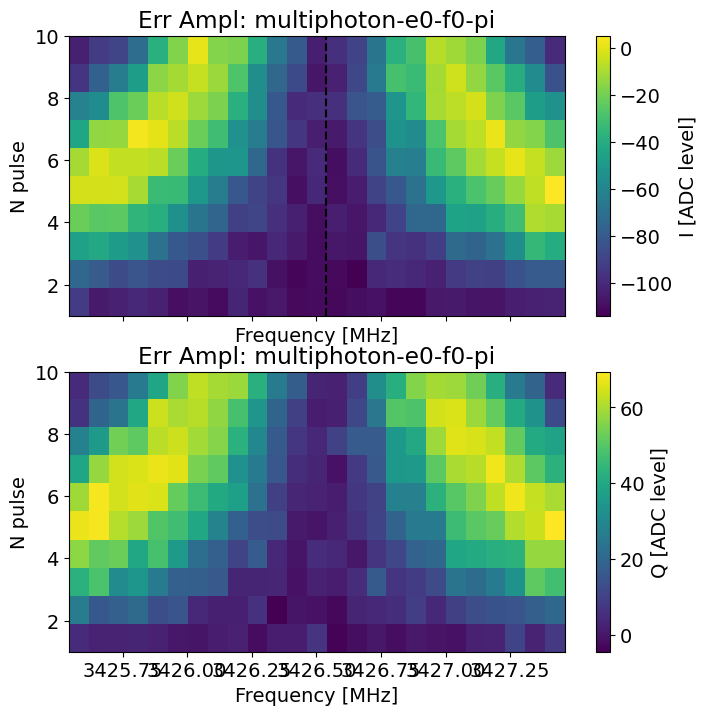

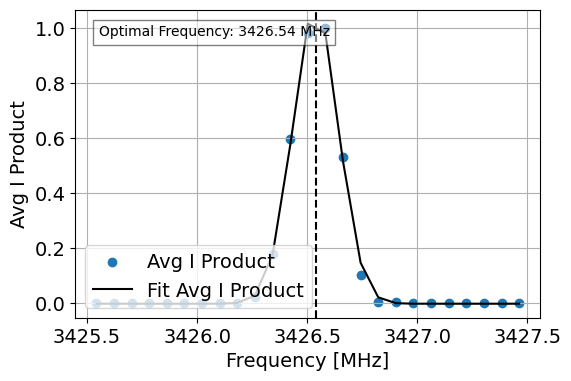

In [95]:
err_amp.analyze()
err_amp.display()

In [96]:
print("Qubit pi frequency before update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i] = err_amp.data['fit_avgi'][2]
print("Qubit pi frequency after update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i])

Qubit pi frequency before update: 3426.5424661385628
Qubit pi frequency after update: 3426.5378606043196


In [97]:
expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency']

[3426.5378606043196, 3427.984451944102, 3427.712094472353, 3427.4772366132443]

### Amplitude

In [98]:
band = 500
expts = 25
gain_start = expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i] - band
step = 2 * band / expts
print(f'Gain start: {gain_start}, Step: {step}')

err_amp = do_error_amplification(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    reps=100,
    rounds=1,
    n_pulses = 10,
    expts=expts,
    start=gain_start,
    step=step,
    pulse_type=['multiphoton', transition, 'pi', 0],
    parameter_to_test='gain',
)

Gain start: 2410, Step: 40.0
cfg at start of acquire {'reps': 100, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 2410, 'expts': 25, 'step': 40.0, 'n_pulses': 10, 'pulse_type': ['multiphoton', 'e0-f0', 'pi', 0], 'parameter_to_test': 'gain', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
post_pulse: [[3577.310358346167], [19292], [0], [0], [2], ['gauss'], [0.007]]
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00316_ErrorAmplificationExperiment.h5


fitparams [-2.407820657986499e-05, 1.00002407820658, 2930.0, 96.0]


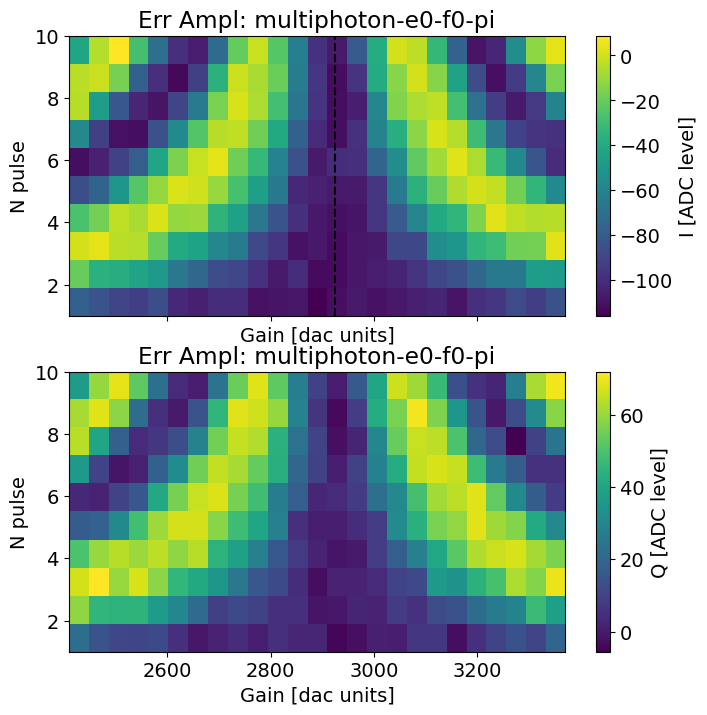

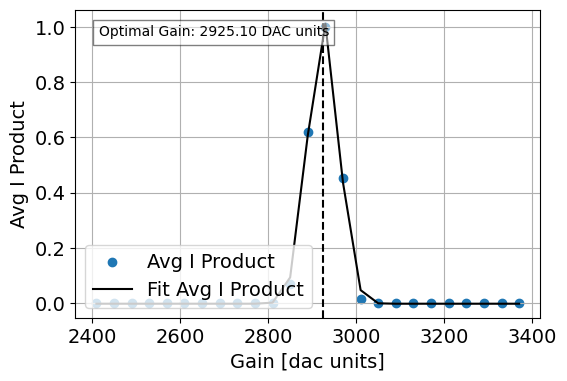

In [99]:
err_amp.analyze()
err_amp.display()

In [100]:
print("Qubit pi amplitude before update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i] = int(err_amp.data['fit_avgi'][2])
print("Qubit pi amplitude after update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['gain'][i])

Qubit pi amplitude before update: 2910
Qubit pi amplitude after update: 2925


### Error amplification $\pi/2$ pulse

### Frequency

In [86]:
expts = 25
band = 3
# expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['sigma'][i] = 0.035
freq_start = expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i] - band
# freq_start = expts_base_inst.config_thisrun.device.multiphoton['pi'][_transition]['frequency'][i] - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

err_amp = do_error_amplification(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    reps=100,
    rounds=1,
    n_pulses = 10,
    expts=expts,
    start=freq_start,
    step=step,
    pulse_type=['multiphoton', transition, 'hpi', 0],
    parameter_to_test='frequency',
)

Frequency start: 3567.9117350856664, Step: 0.24
cfg at start of acquire {'reps': 100, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 3567.9117350856664, 'expts': 25, 'step': 0.24, 'n_pulses': 10, 'pulse_type': ['multiphoton', 'g0-e0', 'hpi', 0], 'parameter_to_test': 'frequency', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00313_ErrorAmplificationExperiment.h5


fitparams [-1.924116707627381e-05, 1.0000192411670763, 3570.7917350856665, 0.5760000000000218]


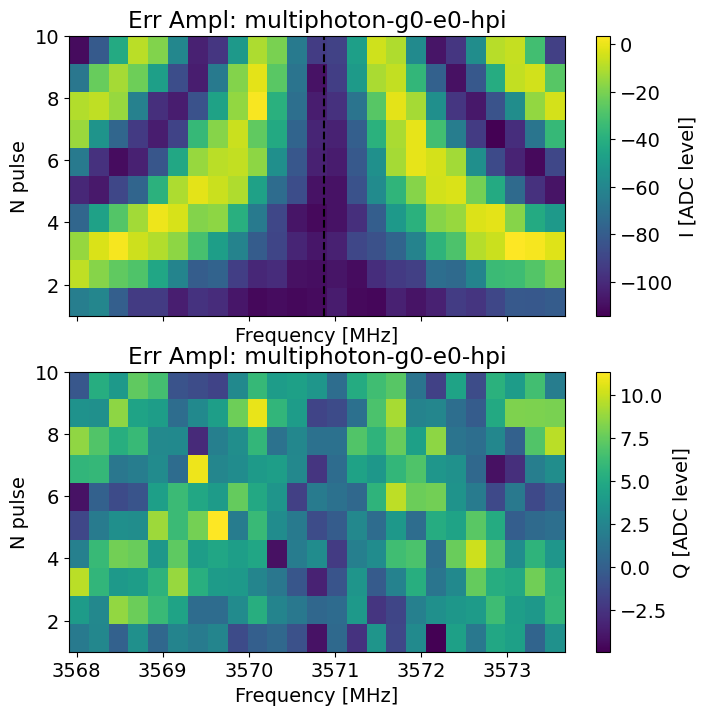

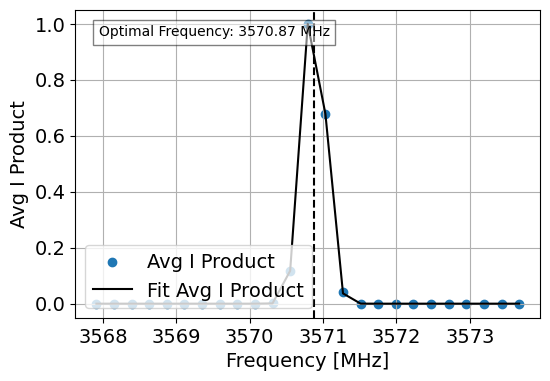

In [87]:
err_amp.analyze()
err_amp.display()

In [88]:
print("Qubit pi frequency before update:",expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i])
expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i] = err_amp.data['fit_avgi'][2]
print("Qubit pi frequency after update:",expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['frequency'][i])

Qubit pi frequency before update: 3570.9117350856664
Qubit pi frequency after update: 3570.8749895266005


### Amplitude

In [89]:
band = 1000
expts = 25
# gain_start = 18000/2 - band
gain_start = expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i] - band
step = 2 * band / expts
print(f'Gain start: {gain_start}, Step: {step}')

err_amp = do_error_amplification(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    reps=100,
    rounds=1,
    n_pulses = 10,
    expts=expts,
    start=gain_start,
    step=step,
    pulse_type=['multiphoton', transition, 'hpi', 0],
    parameter_to_test='gain',
)

Gain start: 7978, Step: 80.0
cfg at start of acquire {'reps': 100, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 7978, 'expts': 25, 'step': 80.0, 'n_pulses': 10, 'pulse_type': ['multiphoton', 'g0-e0', 'hpi', 0], 'parameter_to_test': 'gain', 'rounds': 1}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00314_ErrorAmplificationExperiment.h5


fitparams [-7.063764809997911e-07, 1.000000706376481, 9018.0, 192.0]


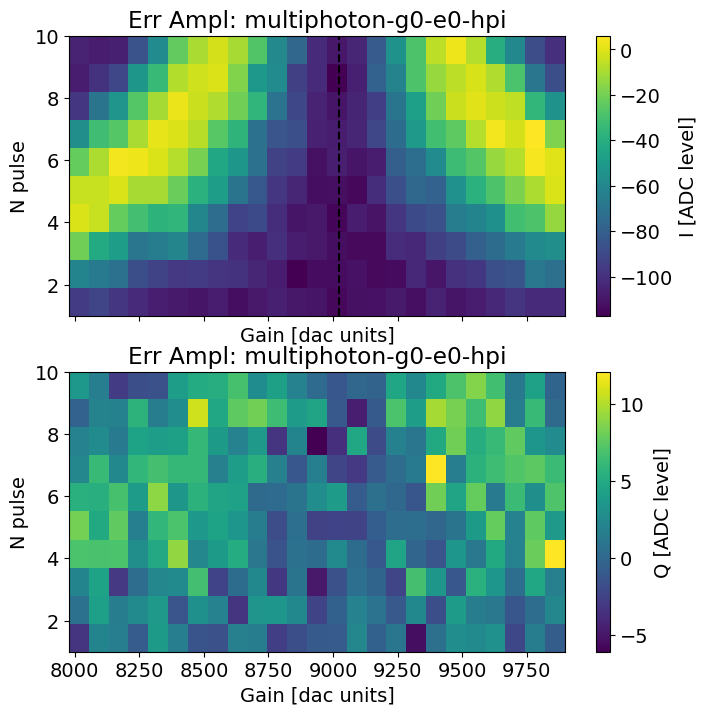

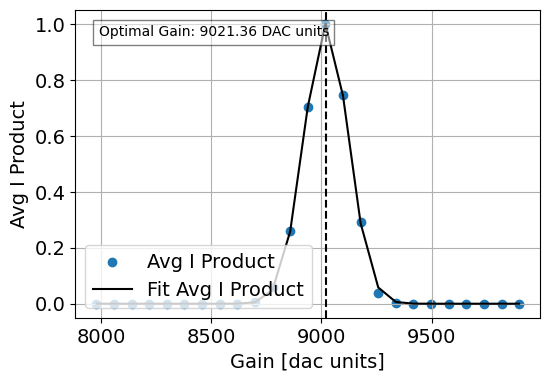

In [91]:
err_amp.analyze()
err_amp.display()

In [92]:
print("Qubit hpi gain before update:",expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i])
expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i] = int(err_amp.data['fit_avgi'][2])
print("Qubit hpi gain after update:",expts_base_inst.config_thisrun.device.multiphoton['hpi'][_transition]['gain'][i])

Qubit hpi gain before update: 8978
Qubit hpi gain after update: 9021


## Define the sideband we want to calibrate

In [20]:
sideband = 'f0-g1'
_sideband = sideband[0] + 'n' + '-' + sideband[3] + 'n+1'
i = int(sideband[1])
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=i)
print(f"pre_sweep_pulse: {pre_sweep_pulse}")
pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
pre_sweep_pulse.append(['multiphoton', 'e'+str(i)+'-f'+str(i), 'pi', 0])
# pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, expts_base_inst.config_thisrun).pulse.tolist()

pre_sweep_pulse: []


In [21]:
def do_pulse_probe_any(
    config_thisrun,
    ds_thisrun,
    man_mode_no=1,
    start=2006,
    step=0.01,
    expts=500,
    reps=500,
    rounds=1,
    length=1,
    gain=5000,
    pulse_type='gaussian',
    qubit_f=False,
    qubits=[0],
    prepulse=True,
    pre_sweep_pulse=pre_sweep_pulse,
    relax_delay=200
):
    """
    Run the Pulse Probe F0g1 Spectroscopy experiment with configurable parameters.
    """
    qspec = expts_base_inst.meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=expts_base_inst.config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    if start is None:
        start = ds_thisrun.get_freq('M' + str(man_mode_no)) - 5
    if pre_sweep_pulse is None:
        pre_sweep_pulse = [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]

    qspec.cfg.expt = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'length': length,
        'gain': gain,
        'pulse_type': pulse_type,
        'qubit_f': qubit_f,
        'qubits': qubits,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }

    qspec.cfg.device.readout.relax_delay = [relax_delay]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_any(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

  0%|          | 0/250000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00092_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2018.7574609248743, HWHM 0.2404535283995917
Found peak in I at [MHz] 2018.7626972682972, HWHM -0.29985557430209253
Found peak in Q at [MHz] 2018.7802962024045, HWHM 0.3995048148141443


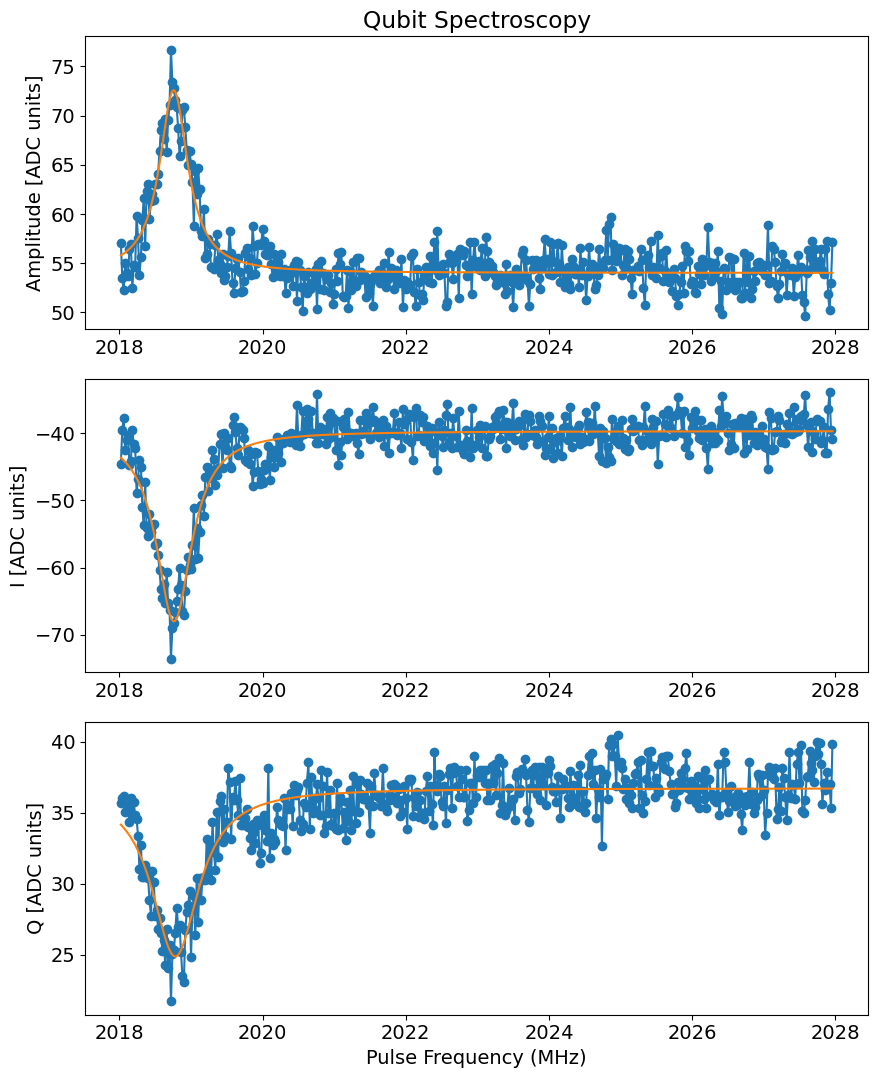

In [23]:
man_spec = do_pulse_probe_any(expts_base_inst.config_thisrun,
                                expts_base_inst.ds_thisrun, 
                                man_mode_no = 1, 
                                # start = 2006, 
                                start = 2018, 
                                step=0.02,
                                expts=500,
                                length=1,
                                gain = 3000,
                                prepulse = True, pre_sweep_pulse=pre_sweep_pulse)
analyze_and_display_pulse_probe_any(man_spec)

In [30]:
# print("Transition frequency before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])
# multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'] =  man_spec.data['fit_avgi'][2]
# print('Updated transition frequency to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])
print("Transition frequency before update:",  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] = man_spec.data['fit_avgi'][2]
print('Updated transition frequency to:',  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])

Transition frequency before update: 2008.3046663331068
Updated transition frequency to: 2018.7626972682972


### Quick chevron

In [31]:
def do_length_rabi_any_sweep(
    config_thisrun,
    expt_path,
    config_path,
    freq_start,
    freq_stop,
    freq_step,
    start=2,
    step=0.1,
    qubits=[0],
    expts=25,
    reps=100,
    rounds=1,
    gain=8000,
    ramp_sigma=0.005,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    check_man_reset=[False, 0],
    check_man_reset_pi=[],
    prepulse=True,
    postpulse=postpulse,
    pre_sweep_pulse=None,
    post_sweep_pulse=post_pulse,
    err_amp_reps=0
):
    """Run the Length Rabi General F0g1 Experiment Sweep with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(
        soccfg=expts_base_inst.soc,
        path=expt_path,
        prefix=sweep_experiment_name,
        config_file=config_path,
        exp_param_file=expts_base_inst.exp_param_file,
        config_thisrun=config_thisrun
    )

    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop': freq_stop,
        'freq_step': freq_step,
        'start': start,
        'step': step,
        'qubits': qubits,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'gain': gain,
        'ramp_sigma': ramp_sigma,
        'use_arb_waveform': use_arb_waveform,
        'pi_ge_before': pi_ge_before,
        'pi_ef_before': pi_ef_before,
        'pi_ge_after': pi_ge_after,
        'normalize': normalize,
        'active_reset': active_reset,
        'check_man_reset': check_man_reset,
        'check_man_reset_pi': check_man_reset_pi,
        'prepulse': prepulse,
        'postpulse': postpulse,
        'post_sweep_pulse': post_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'err_amp_reps': err_amp_reps,
    }
    return eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)


In [ ]:
# expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] = 2008.3046663331068

In [32]:
expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i]


2018.7626972682972

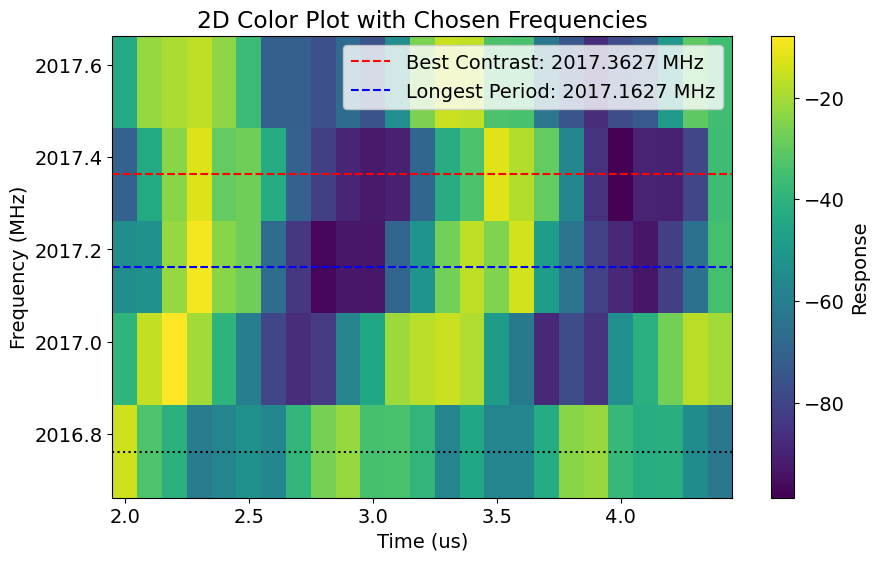

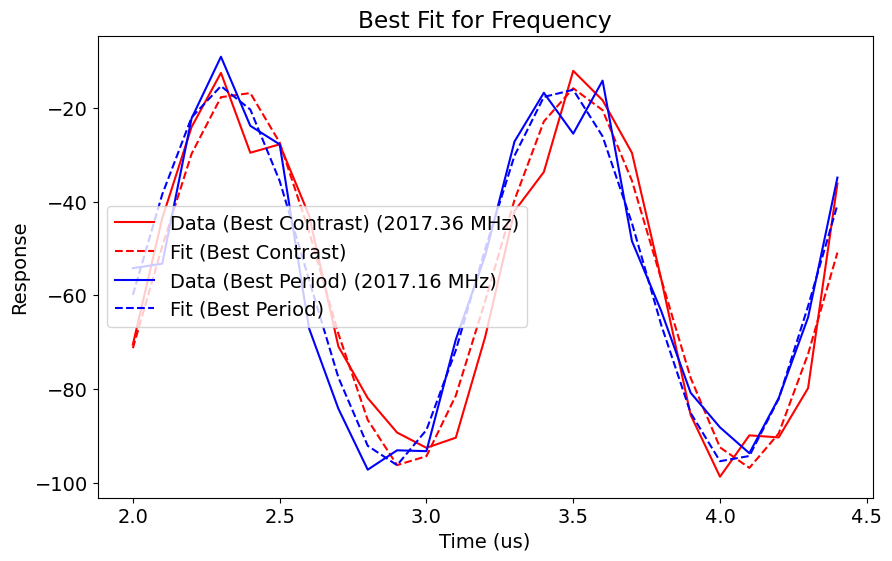

In [35]:
# guess_freq =  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency']
# expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['gain'][i] = 5000
guess_freq = expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i]
freq_start = guess_freq- 0.5
# freq_start = guess_freq- 2.5
freq_stop = guess_freq + 0.5
# freq_stop = guess_freq + 2.5
# freq_start = 2015
# freq_stop = 2025
freq_step = 0.2
man_chevrons = do_length_rabi_any_sweep(expts_base_inst.config_thisrun, expts_base_inst.expt_path, expts_base_inst.config_file, 
                                                freq_start, freq_stop, freq_step,
                                                prepulse = True, 
                                                gain=expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['gain'][i],
                                                pre_sweep_pulse= pre_sweep_pulse,
                                                postpulse = postpulse ,
                                                post_sweep_pulse=post_pulse,
                                                )

In [36]:
# print("Transition frequency before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])
# multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'] =  man_chevrons.results['best_frequency_contrast']
# print('Updated transition frequency to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])

print("Transition frequency before update:",  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] = man_chevrons.results['best_frequency_contrast']
print('Updated transition frequency to:',  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])

Transition frequency before update: 2017.2626972682974
Updated transition frequency to: 2017.3626972682976


### Length rabi first round

In [37]:
def do_length_rabi_f0g1_general(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    man_mode_no=1,
    start=None,
    step=0.045,
    qubits=[0],
    expts=50,
    reps=100,
    rounds=1,
    gain=8000,
    freq=None,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    man_reset=True,
    stor_reset=True,
    check_man_reset=[False, 0],
    swap_lossy=False,
    check_man_reset_pi=[],
    prepulse=True,
    postpulse=postpulse,
    post_sweep_pulse=None,
    pre_sweep_pulse=None,
    err_amp_reps=0,
    relax_delay=2500
):
    """
    Run the Length Rabi General F0g1 Experiment with all config params as function arguments.
    """
    length_rabi = expts_base_inst.meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    if freq is None:
        freq = ds_thisrun.get_freq('M' + str(man_mode_no))
    if start is None:
        start = expts_base_inst.soc.cycles2us(3)
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []

    print('gain', gain)

    length_rabi.cfg.expt = dict(
        start=start,
        step=step,
        qubits=qubits,
        expts=expts,
        reps=reps,
        rounds=rounds,
        gain=gain,
        freq=freq,
        use_arb_waveform=use_arb_waveform,
        pi_ge_before=pi_ge_before,
        pi_ef_before=pi_ef_before,
        pi_ge_after=pi_ge_after,
        normalize=normalize,
        active_reset=active_reset,
        man_reset=man_reset,
        stor_reset=stor_reset,
        check_man_reset=check_man_reset,
        swap_lossy=swap_lossy,
        check_man_reset_pi=check_man_reset_pi,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse,
        postpulse=postpulse,
        post_sweep_pulse= post_sweep_pulse,
        err_amp_reps=err_amp_reps,
    )

    length_rabi.cfg.device.readout.relax_delay = [relax_delay]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config=length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')

    return length_rabi_analysis

gain 8000


  0%|          | 0/50 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00134_LengthRabiGeneralF0g1Experiment.h5
p1: 0.8525433065260447
p2: 91.71165718964586
Pi length: 0.5809035070763279
Pi/2 length: 0.28766327155245347
p1: 0.8523362510134919
p2: 91.02503583325817
Pi length: 0.583282334465767
Pi/2 length: 0.2899708629629051


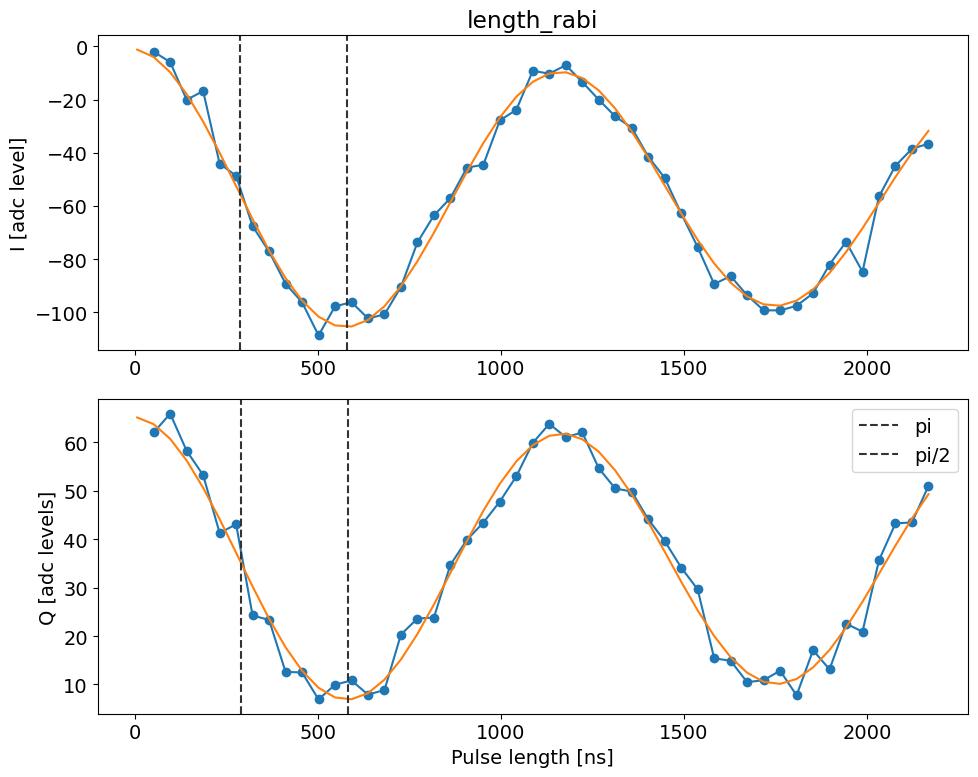

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_18-53-34_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md


In [38]:

len_rabis_mans = do_length_rabi_f0g1_general(expts_base_inst.config_thisrun, expts_base_inst.ds_thisrun,
                                              expts_base_inst.expt_path, expts_base_inst.config_file, man_mode_no= 1,
                                              # gain = 1000,
                                              gain = expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['gain'][i],
                                              freq = expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i],
                                              prepulse=True,pre_sweep_pulse=pre_sweep_pulse, postpulse=postpulse, post_sweep_pulse=post_pulse
                                              )
        

In [39]:
# print("Transition length before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'])
# multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'] = len_rabis_mans.results['pi_length']
# print('Updated transition length to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'])
print("Transition length before update:",  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i] = len_rabis_mans.results['pi_length']
print('Updated transition length to:',  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i])

Transition length before update: 0.5923919650175945
Updated transition length to: 0.5809035070763279


### Error amplification

In [42]:
expts = 50
band = 0.25
# expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][0] = 0.5491206701698654
freq_start = expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] - band
# freq_start = 2011 - band
step = 2 * band / expts
print(f'Frequency start: {freq_start}, Step: {step}')

err_amp = do_error_amplification(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    reps=100,
    rounds=1,
    n_pulses = 7,
    expts=expts,
    start=freq_start,
    step=step,
    pulse_type=['multiphoton', sideband, 'pi', 0],
    parameter_to_test='frequency',
)

Frequency start: 2017.1126972682976, Step: 0.01
cfg at start of acquire {'reps': 100, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 2017.1126972682976, 'expts': 50, 'step': 0.01, 'n_pulses': 7, 'pulse_type': ['multiphoton', 'f0-g1', 'pi', 0], 'parameter_to_test': 'frequency', 'rounds': 1}
n_pts [1 2 3 4 5 6 7]


  0%|          | 0/7 [00:00<?, ?it/s]

post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
post_pulse: [[3578.0021446833534, 3426.5424661385628], [19004, 2910], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.007, 0.035]]
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00309_ErrorAmplificati

fitparams [0.027417896439046928, 0.9725821035609531, 2017.3526972682976, 0.04900000000000091]


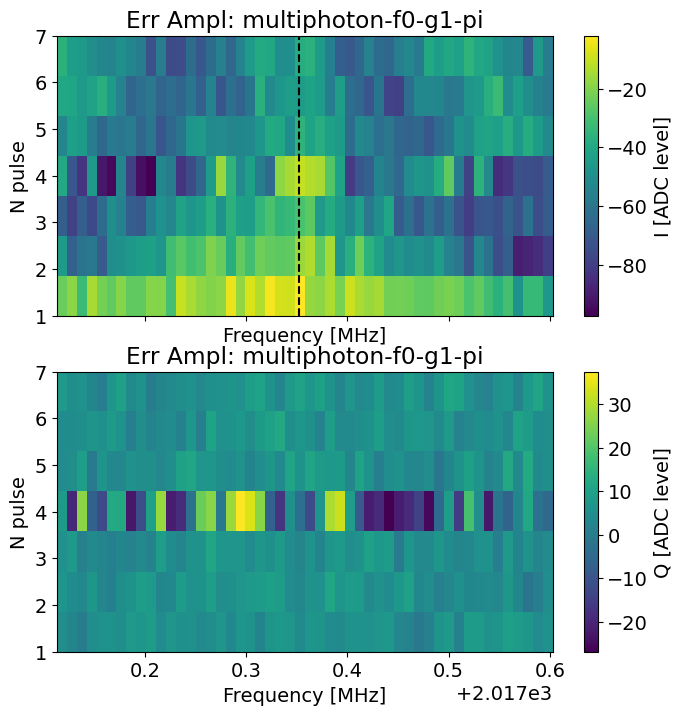

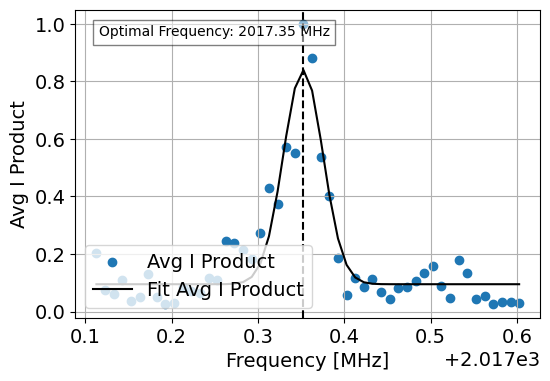

In [43]:
err_amp.analyze(state_fin='e')
err_amp.display()

In [44]:
print("Qubit pi frequency before update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i] = err_amp.data['fit_avgi'][2]
print("Qubit pi frequency after update:",expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i])

Qubit pi frequency before update: 2017.3626972682976
Qubit pi frequency after update: 2017.352384126685


### Length Rabi

gain 8000


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00135_LengthRabiGeneralF0g1Experiment.h5
p1: 0.8797218706520447
p2: 86.9814846537406
Pi length: 0.5778926065279119
Pi/2 length: 0.293711880391478
p1: 0.927603844009127
p2: 75.30927330157026
Pi length: 0.5830156673617489
Pi/2 length: 0.3135040632274951


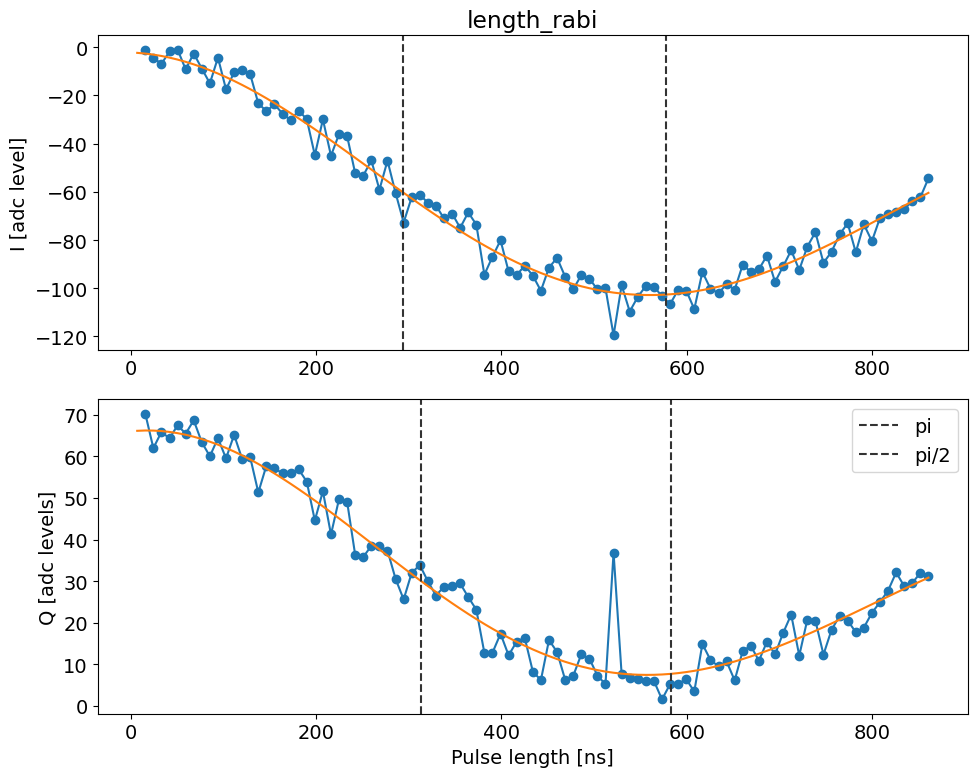

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_18-59-06_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md


In [45]:
stop = 1.5 * expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i]
expts = 100
step = stop / expts


len_rabis_mans = do_length_rabi_f0g1_general(expts_base_inst.config_thisrun, expts_base_inst.ds_thisrun,
                                              expts_base_inst.expt_path, expts_base_inst.config_file, man_mode_no= 1,
                                              step=step, expts=expts,
                                              gain = expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['gain'][i],
                                            #   freq =  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'],
                                              freq = expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['frequency'][i],
                                              prepulse=True,pre_sweep_pulse=pre_sweep_pulse, postpulse=postpulse, post_sweep_pulse=post_pulse
                                              )

In [46]:
# print("Transition length before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'])
# multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'] = len_rabis_mans.results['pi_length']
# print('Updated transition length to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'])
print("Transition length before update:",  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i])
expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i] = len_rabis_mans.results['pi_length']
print('Updated transition length to:',  expts_base_inst.config_thisrun.device.multiphoton['pi'][_sideband]['length'][i])

Transition length before update: 0.5809035070763279
Updated transition length to: 0.5778926065279119


## Single shot
To check broadband pulses and recalibrate phase

### Some fake optimal control pulse to test

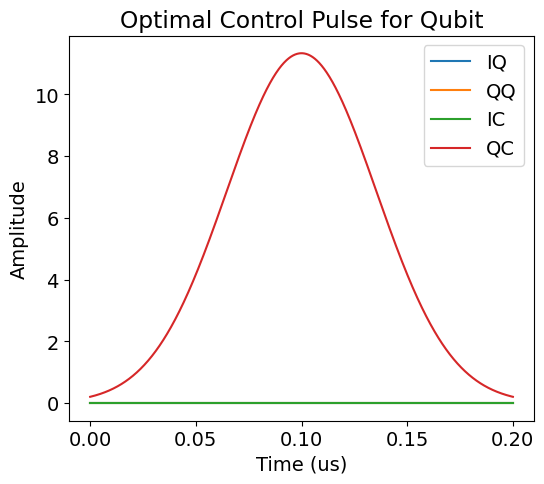

In [249]:
from scipy import special
sigma_qb = expts_base_inst.config_thisrun.device.qubit.pulses.pi_ge.sigma[0]
sigma_cav = expts_base_inst.config_thisrun.device.manipulate.displace_sigma[0]
gain_qb = expts_base_inst.config_thisrun.device.qubit.pulses.pi_ge.gain[0]
n=4
# t_vec = np.linspace(0 ,n*sigma_qb ,1000)
t_vec = np.linspace(0 ,n*sigma_cav ,1000)
theta_to_gain = np.pi/2/gain_qb
alpha_to_gain = expts_base_inst.config_thisrun.device.manipulate.gain_to_alpha[0]

# drive_to_gain_qb = sigma_qb * np.sqrt(2*np.pi)/theta_to_gain * special.erf(n/2/np.sqrt(2))
# drive_to_gain_cav = sigma_cav * np.sqrt(2*np.pi)/alpha_to_gain * special.erf(n/2/np.sqrt(2))
drive_to_gain_qb = sigma_qb * np.sqrt(np.pi)/theta_to_gain * special.erf(n/2)
drive_to_gain_cav = sigma_cav * np.sqrt(np.pi)/alpha_to_gain * special.erf(n/2)

# epsilon_pi = np.sqrt(np.pi/8/sigma_qb**2) * 1/special.erf(n/2/np.sqrt(2))
rot = 0.5
epsilon_pi = np.sqrt(np.pi/4/sigma_qb**2) * 1/special.erf(n/2) * rot
alpha = 1
epsilon_1 = 1j*((1)*alpha)/(np.sqrt(np.pi)*sigma_cav*special.erf(n/2))

# iq = np.exp(-(t_vec - n*sigma_qb/2)**2/(2*sigma_qb**2)) * epsilon_pi * drive_to_gain_qb
# iq = np.exp(-(t_vec - n*sigma_qb/2)**2/(sigma_qb**2)) * epsilon_pi
iq = np.zeros_like(t_vec)
qq = np.zeros_like(iq)
ic = np.real(np.exp(-(t_vec - n*sigma_cav/2)**2/(sigma_cav**2)) * epsilon_1)
qc = np.imag(np.exp(-(t_vec - n*sigma_cav/2)**2/(sigma_cav**2)) * epsilon_1)
# ic =np.zeros_like(t_vec)
# qc =np.zeros_like(t_vec)

# pad with 100ns of zeros at the end
# dt = t_vec[1] - t_vec[0]
# t_vec = np.append(t_vec, t_vec[-1] + dt * np.arange(1, 8001))
# iq = np.append(iq, np.zeros(8000))
# qq = np.append(qq, np.zeros(8000))
# ic = np.append(ic, np.zeros(8000))
# qc = np.append(qc, np.zeros(8000))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(t_vec, iq, label='IQ')
ax.plot(t_vec, qq, label='QQ')
ax.plot(t_vec, ic, label='IC')
ax.plot(t_vec, qc, label='QC')
ax.set_xlabel('Time (us)')
ax.set_ylabel('Amplitude')
ax.set_title('Optimal Control Pulse for Qubit')
ax.legend()



data = {
    'times': t_vec*1e3,
    'I_q' : iq/2/np.pi*1e-3,
    'Q_q' : qq/2/np.pi*1e-3,
    'I_c' : ic/2/np.pi*1e-3,
    'Q_c' : qc/2/np.pi*1e-3
}

filepath = "H://Shared drives//SLab//Multimode//optimal_control//"
filename = "test_pi"
# save in the npz format
np.savez_compressed(filepath + filename, **data)


In [15]:
def do_single_shot(
    config_thisrun,
    expt_path,
    config_path,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=250
):
    """Run the single shot experiment with configurable parameters."""

   
    hstgrm = expts_base_inst.meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
    }

    hstgrm.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import Histogram
    
    hist_analysis = Histogram(
            hstgrm.data, verbose=True,
             span=300, threshold=None, config=hstgrm.cfg,
        )
    return hstgrm, hist_analysis


def update_single_shot(hist_analysis, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']
    print(fids)

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hist_analysis.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hist_analysis.data['Ig_rot'])
    if hist_analysis.cfg.expt.active_reset:
        config_thisrun.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [16]:
prepulse = [
     # ['qubit', 'ge', 'pi', 0],
     ['optimal_control', 'test', '1', [0, 0]]
     ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav
# gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[1])
# print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
# expts_base_inst.config_thisrun.device.optimal_control[prepulse[1][1]][prepulse[1][2]]['gain'][0]= gain_qb
# expts_base_inst.config_thisrun.device.optimal_control[prepulse[1][1]][prepulse[1][2]]['gain'][1]= gain_cav
prepulse_seq = mm_base_calib.get_prepulse_creator(prepulse, cfg=expts_base_inst.config_thisrun).pulse.tolist()
print(f'Prepulse: {prepulse_seq}')

Gain for qubit: 867, Gain for cavity: 2580
Prepulse: [[3569.6978631006828, 4984.8599830542125], [867, 2580], [0, 0], [0.0, 0.0], [2, 3], [['opt_cont', 'test', '1'], ['opt_cont', 'test', '1']], [0, 0]]


In [17]:
hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        pre_sweep_pulse=prepulse_seq,
                        relax_delay = 2500)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00404_HistogramExperiment.h5
{'device': {'qubit': {'T1': [433.0775501808963], 'f_ge': [3569.7028312412162], 'f_ef': [3426.624285537752], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [3522], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [1740], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [2931], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [1470], 'sigma': [0.035], 'type': ['gauss']}, 'slow_pi_ge': {'gain': [15], 'sigma': [0.1], 'length': [10], 'type': ['flat_top']}}, 'T1_ef': [127.19717490775781]}, 'readout': {'trig_offset': [450], 'frequency': [749.1893739821222], 'gain': [800], 'phase': [-198.29582042684413], 'threshold': [-55.83482007380013], 'threshold_list': [[-55.83482007380013]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'confusion_matrix_

Unrotated:
Ig -108.75865800865802 +/- 34.90385782598205 	 Qg 49.16991341991342 +/- 32.18641086384725 	 Amp g 119.35713668468264
Ie -3.5054112554112553 +/- 35.48676991674098 	 Qe 9.535714285714286 +/- 32.28656109595742 	 Amp e 10.159613920240249
updating temp data
Rotated:
Ig -119.3841286880012 +/- 35.319957197540866 	 Qg 8.159931922707605 +/- 31.72924453870015 	 Amp g 119.6626703344717
Ie -6.101299460807052 +/- 36.384960536940184 	 Qe 7.281562095914298 +/- 31.270873240957133 	 Amp e 9.499842191694567


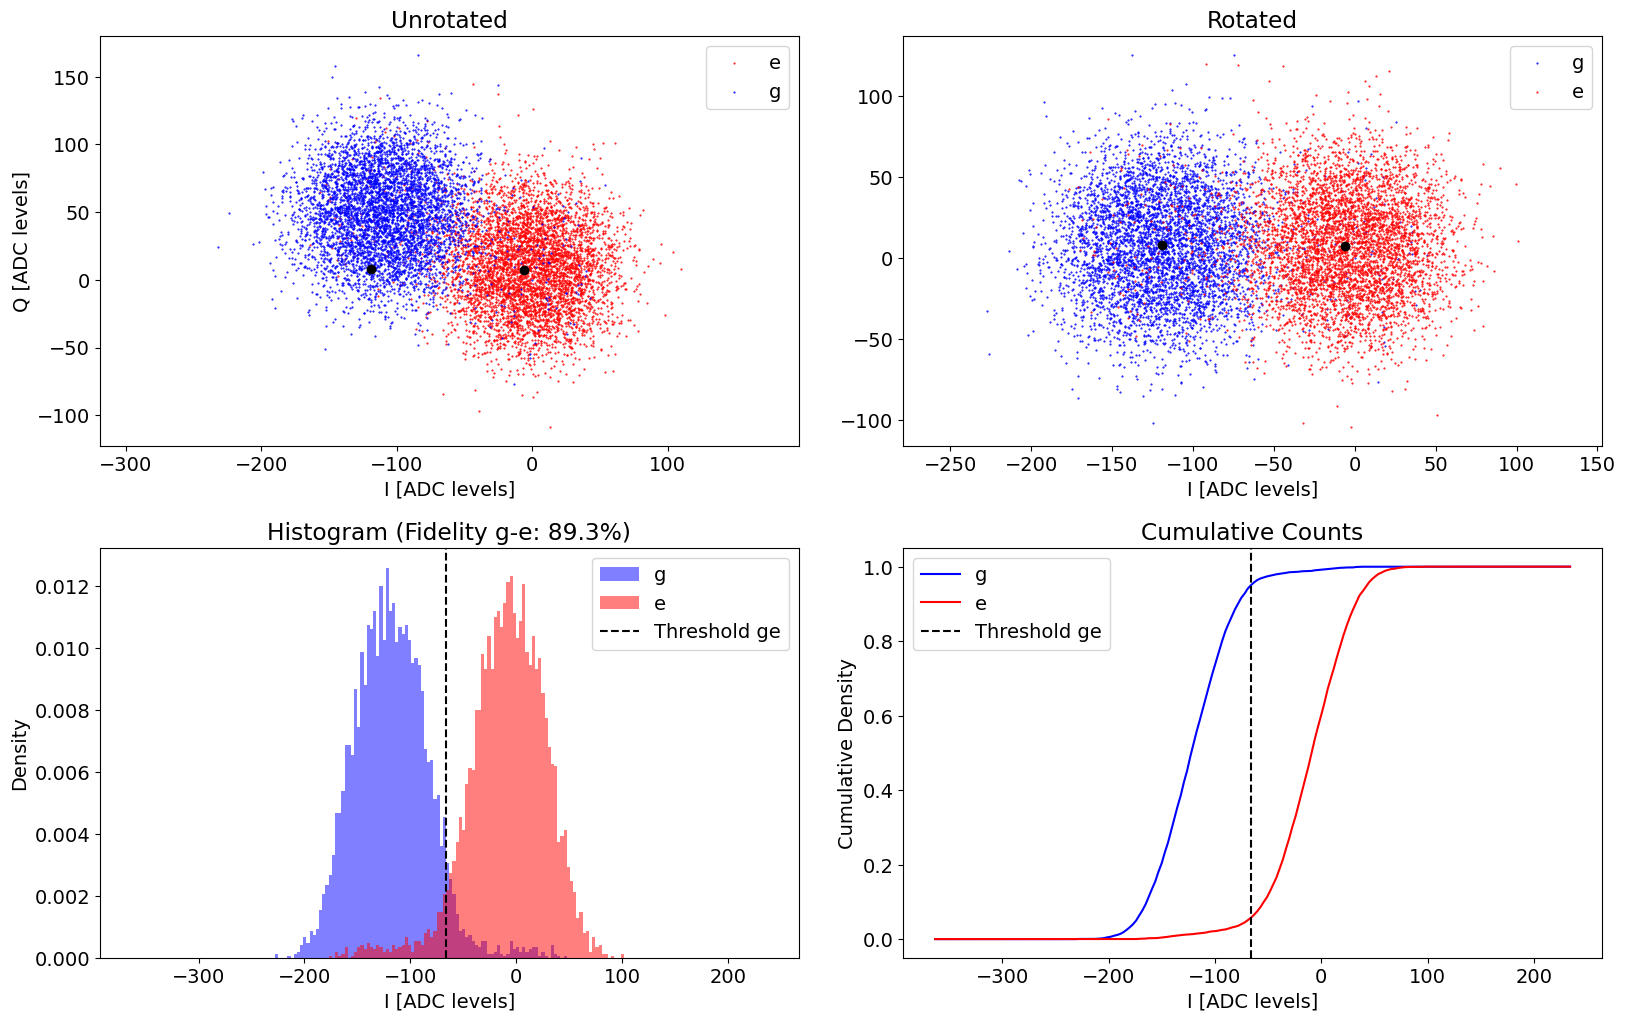

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_18-06-23_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md


In [18]:
hstgrm[1].analyze(plot = True)

Unrotated:
Ig -108.75865800865802 +/- 34.90385782598205 	 Qg 49.16991341991342 +/- 32.18641086384725 	 Amp g 119.35713668468264
Ie -3.5054112554112553 +/- 35.48676991674098 	 Qe 9.535714285714286 +/- 32.28656109595742 	 Amp e 10.159613920240249
updating temp data
Rotated:
Ig -119.3841286880012 +/- 35.319957197540866 	 Qg 8.159931922707605 +/- 31.72924453870015 	 Amp g 119.6626703344717
Ie -6.101299460807052 +/- 36.384960536940184 	 Qe 7.281562095914298 +/- 31.270873240957133 	 Amp e 9.499842191694567


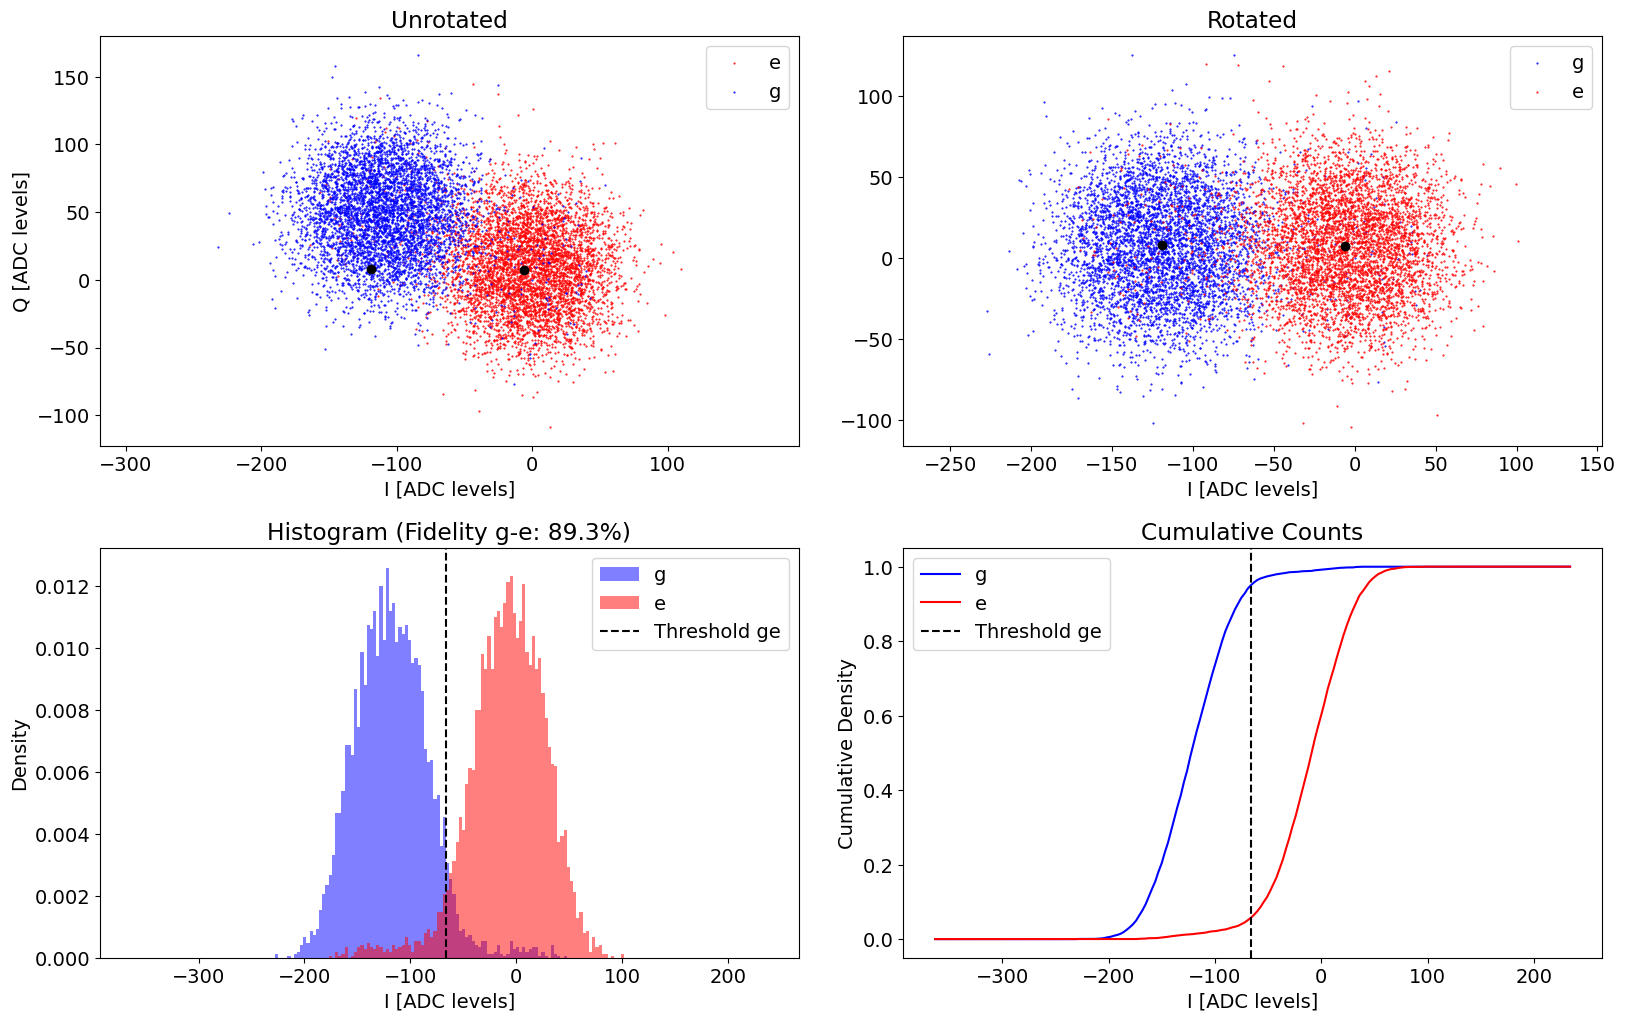

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_18-06-26_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md
[0.8929999999999998]
Updated readout!
Single shot done!


In [19]:
update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)
print('Single shot done!')

## Photon Number Resolved  Spectroscopy

This is used to check that the fock states are well prepared before we do the tomography

In [ ]:
def do_pulse_probe(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=400,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
    ): 
    qspec = expts_base_inst.meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='PulseProbeSpectroscopyExperiment', 
        config_file=expts_base_inst.config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        qubits = [0],
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        qubit=qubit,
        prepulse = prepulse, 
        pre_sweep_pulse = pre_sweep_pulse,
        gate_based = gate_based,
    )

    qspec.cfg.device.readout.relax_delay = [relax_delay] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

In [ ]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=0)
# pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, expts_base_inst.config_thisrun).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

In [ ]:
qspec= do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=expts_base_inst.config_thisrun.device.qubit.f_ge[0]-1.5,  # [MHz]
    step=0.020,  # min step ~1 MHz
    expts=100,  # Number of experiments stepping from start
    reps=30,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=10,  # Qubit probe constant pulse length [us]
    gain=5,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=True,
    pre_sweep_pulse=pre_sweep_pulse,
    gate_based=False,
    relax_delay=8000  # Wait time between experiments [us]
)

# Setting up the Wigner tomography

## Parity Delay

In [101]:
def do_parity_delay(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,
    step=0.05,
    expts=50,
    reps=250,
    rounds=1,
    qubits=[0],
    prepulse=True,
    parity_fast=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    gate_based=False,
    storage_reset=True,
    pre_sweep_pulse=[],
    man_mode_no=1,
    relax_delay=2500
):
    print("Prepulse:", pre_sweep_pulse)

    pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, expts_base_inst.config_thisrun).pulse.tolist()
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'prepulse': prepulse,
        'normalize': normalize,
        'active_reset': active_reset,
        'parity_fast': parity_fast,
        'man_reset': man_reset,
        'gate_based': gate_based,
        'storage_reset': storage_reset,
        'pre_sweep_pulse': pre_sweep_pulse,
    }
    # print("expt_path:", expt_path)
    # print("config_path:", config_path)
    
    
    parity_delay_exp = expts_base_inst.meas.single_qubit.parity_delay.ParityDelayExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityDelayExperiment', config_file=config_path
    )
    parity_delay_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_delay_exp.cfg.expt = expt_cfg
    parity_delay_exp.cfg.device.readout.relax_delay = [relax_delay] 
    parity_delay_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_delay_exp


### Calibrate first the AC stark shift

Manipulate in 0, qubit should not rotate

In [104]:
pre_sweep_pulse = []
parity_delay_exp = do_parity_delay(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    parity_fast=True,
    config_path=expts_base_inst.config_file,
    pre_sweep_pulse=pre_sweep_pulse,
    step=0.5,
    expts=100,
    reps=500,
    )

Prepulse: []


KeyboardInterrupt: 

p1: 0.4535121541274618
p2: -145.9841095025736
Pi length: 1.445410909760738
Pi/2 length: 0.89415776753572
p1: 0.9319450009083792
p2: 58.00490555819461
Pi length: 0.6318776985383942
Pi/2 length: 0.3636215248840243


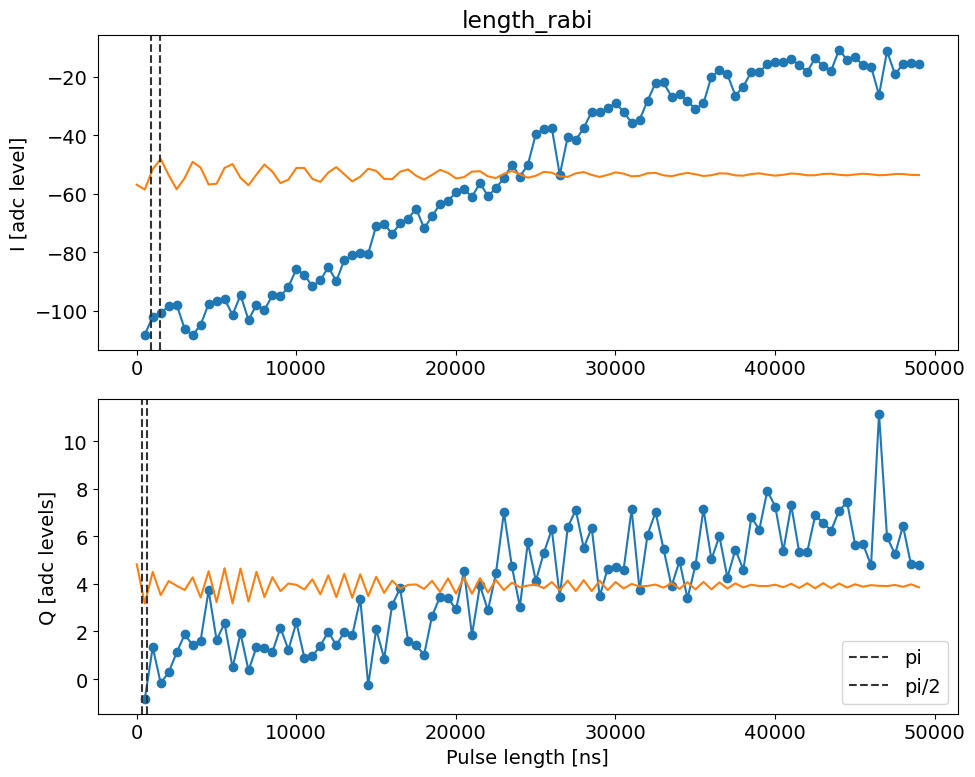

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_19-19-53_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md
-10.728683982683982 -110.03823376623376


In [ ]:
from multimode_expts.fit_display_classes import LengthRabiFitting
# Analyze the data
length_rabi_analysis = LengthRabiFitting(parity_delay_exp.data, config = parity_delay_exp.cfg)
# length_rabi_analysis.analyze(fitparams = [100, 0.1, 0, None, None, None])
length_rabi_analysis.analyze()
length_rabi_analysis.display(title_str='Length Rabi General F0g1')
print(np.max(parity_delay_exp.data['avgi']), np.min(parity_delay_exp.data['avgi']))

In [ ]:
freq = length_rabi_analysis.data['fit_avgi'][1]
print('AC Stark frequency:', freq)
print('Current revival_stark_shift:', expts_base_inst.config_thisrun.device.manipulate.revival_stark_shift[0])
expts_base_inst.config_thisrun.device.manipulate.revival_stark_shift[0] += -freq
# print('Updated revival_stark_shift:', expts_base_inst.config_thisrun.device.manipulate.revival_stark_shift[0])
# expts_base_inst.config_thisrun.device.manipulate.revival_stark_shift[0] = -1.3008346758366192

AC Stark frequency: 0.004480502335394667
Current revival_stark_shift: -1.195859246649853


### Now parity length after the AC stark shift is calibrated

In [109]:
pre_sweep_pulse

[['multiphoton', 'g0-e0', 'pi', 0],
 ['multiphoton', 'e0-f0', 'pi', 0],
 ['multiphoton', 'f0-g1', 'pi', 0]]

In [113]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=0, photon_no=1)
parity_delay_exp = do_parity_delay(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    parity_fast=True,
    config_path=expts_base_inst.config_file,
    pre_sweep_pulse=pre_sweep_pulse,
    reps=100,
    # step=0.01,
    expts=100,
    )

Prepulse: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0]]


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00093_ParityDelayExperiment.h5


Attempted to init fitparam 2 to -500, which is out of bounds -360 to 360. Instead init to 0.0
Attempted to init fitparam 4 to 0.16117866981503348, which is out of bounds 54.08458874458875 to 74.74028138528139. Instead init to 64.41243506493507
p1: 0.5959171077154458
p2: -11.790225076915142
Pi length: 0.4744797918247858
Pi/2 length: 0.05495835710978081
p1: 0.6936496122011117
p2: -17.79397134001236
Pi length: 0.4316699568483103
Pi/2 length: 0.0712574436679283


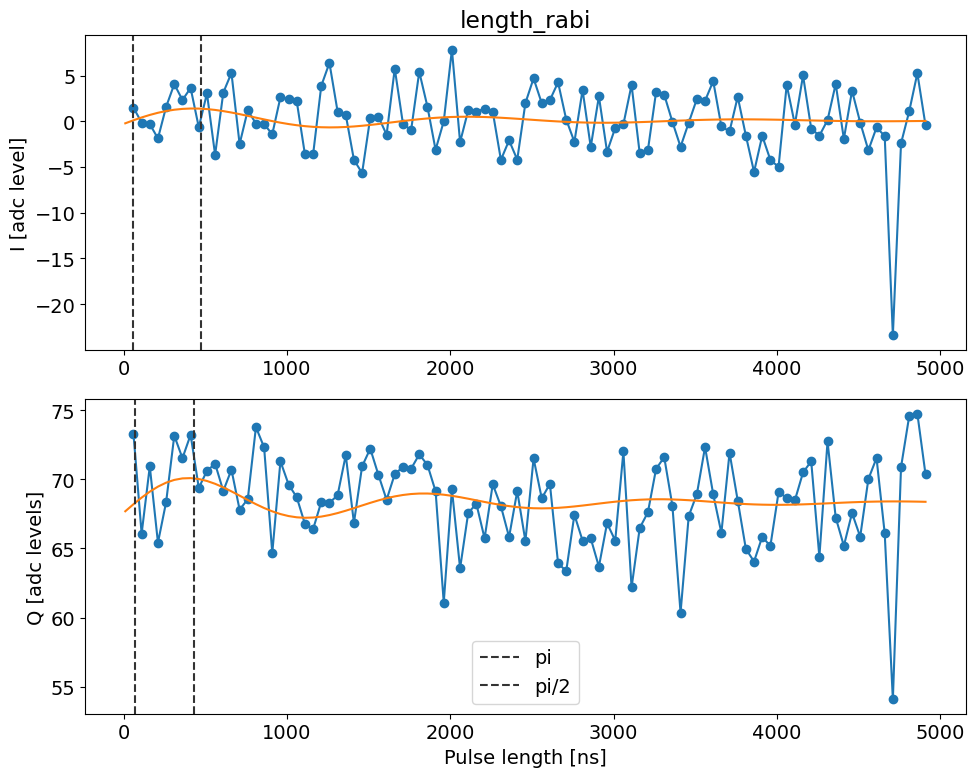

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-11_12-02-03_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-11.md
7.841125541125541 -23.429372294372296


In [114]:
from multimode_expts.fit_display_classes import LengthRabiFitting
# Analyze the data
length_rabi_analysis = LengthRabiFitting(parity_delay_exp.data, config = parity_delay_exp.cfg)
length_rabi_analysis.analyze(fitparams = [100, 0.5, -500, None, None, None])
# length_rabi_analysis.analyze()
length_rabi_analysis.display(title_str='Length Rabi General F0g1')
print(np.max(parity_delay_exp.data['avgi']), np.min(parity_delay_exp.data['avgi']))

In [429]:
## Assign to config 
print('revival time:', length_rabi_analysis.results['pi_length'])
expts_base_inst.config_thisrun.device.manipulate.revival_time[0] = length_rabi_analysis.results['pi_length']


revival time: 1.6426250410354661


## Manipulate Parity Spectroscopy

In [49]:
def do_parity_freq_experiment(
    start=4960,
    stop=5020,
    step=0.60,
    reps=500,
    rounds=1,
    qubit=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=20,
    manipulate_no=1,
    displace=(True, 0.1, 1000),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500
):
    """
    Run the Parity Frequency Experiment with configurable parameters.
    """
    
    expt_cfg = {
        'start': start,
        'stop': stop,
        'step': step,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubit,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'span': span,
        'manipulate': manipulate_no,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }
    # Example usage of relax_delay in experiment config:
    parity_freq_exp = expts_base_inst.meas.single_qubit.parity_freq.ParityFreqExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, 
        prefix='ParityFreqExperiment', config_file=expts_base_inst.config_file
    )
    parity_freq_exp.cfg = AttrDict(deepcopy(expts_base_inst.config_thisrun))
    parity_freq_exp.cfg.expt = expt_cfg
    parity_freq_exp.cfg.device.readout.relax_delay = [relax_delay]
    parity_freq_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_freq_exp


In [50]:
parity_freq_exp = do_parity_freq_experiment()

  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00020_ParityFreqExperiment.h5


Found peak in amps at [MHz] 4975.640290832626, HWHM 2.1937488557110907
Found peak in I at [MHz] 4975.653546874147, HWHM 2.222433261984817
Found peak in Q at [MHz] 4976.78311848614, HWHM 1.6102029708947072


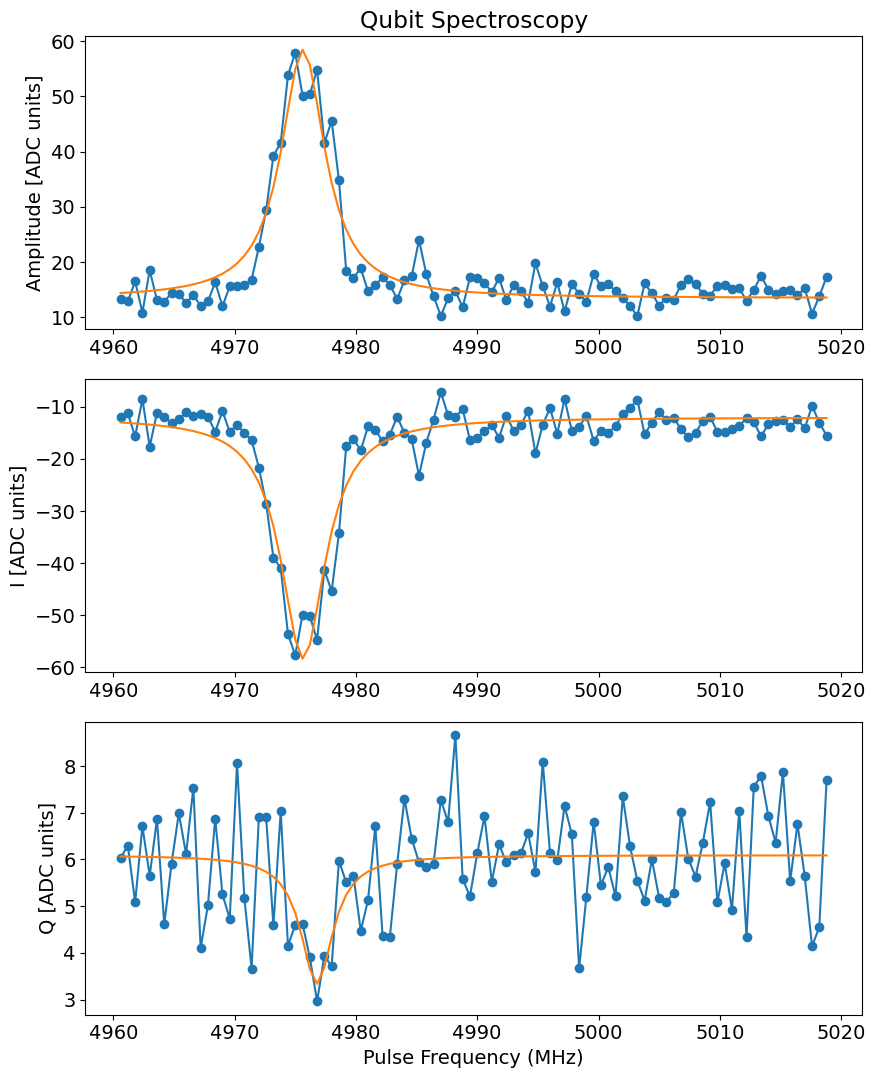

In [52]:
from fit_display_classes import Spectroscopy
spec = Spectroscopy(parity_freq_exp.data, config=parity_freq_exp.cfg)
spec.analyze()
spec.display()

In [53]:
spec.data['fit_avgi'][2]

4975.653546874147

In [54]:
expts_base_inst.config_thisrun.device.manipulate.f_ge[0] = spec.data['fit_avgi'][2]

## Manipulate Ramsey (to finetune frequency)
- This will use displace pulse instead do qubit pi/2 to calibrate; we want fine calibration of manipulate frequency not some fast way of extracting T2 time or finding stark shift on f0g1 transition
- Make sure displacements are small $(\alpha \approx 0.2)$
- Somehow i don't get full contrast, like the lowst i,q value dont correspond to g 




In [55]:
def do_cavity_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True, config_thisrun.device.manipulate.f_ge[man_mode_no-1], 10, 
                                config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 0,
                                  4]
        
    #[on/off, freq, gain, sigma (mus), phase, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = expts_base_inst.meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        prep_e_first=prep_e_first,  # prepare e first
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey



def do_cavity_ramsey_gain_sweep(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    gain_start = 1000,  # start gain
    gain_step = 1000,      # step size for gain
    gain_expts = 5,        # number of experiments for gain
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    relax_delay=2500,      # relax delay
    do_g_and_e=False, # do e-f first
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True, config_thisrun.device.manipulate.f_ge[man_mode_no-1], 1000, 
                                config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 0,
                                  4]
    #[on/off, freq, gain, sigma (mus), phase, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = expts_base_inst.meas.single_qubit.t2_cavity.CavityRamseyGainSweepExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavityRamseyGainSweepExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        gain_start=gain_start,          # start gain
        gain_step=gain_step,            # step size for gain
        gain_expts=gain_expts,          # number of experiments for gain
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        do_g_and_e=do_g_and_e,  # do e-f first
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey



In [56]:
cavity_ramsey = do_cavity_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    man_mode_no=1, 
    # ramsey_freq=0.4,
    # step = 0.05, 
    # prepulse = [['qubit', 'ge', 'pi', 0]],
    # gate_based=True,
    ramsey_freq=1.6,
    step = 0.025, 
    expts = 150, 
    reps = 200,
    prep_e_first = False,
    user_defined_pulse=[True, expts_base_inst.config_thisrun.device.manipulate.f_ge[0], 1500, 
                                expts_base_inst.config_thisrun.device.manipulate.displace_sigma[0],
                                  0, 4])
    #user defined pulse [on/off, freq, gain, sigma (mus), phase, channel] )

150


  0%|          | 0/30000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00102_CavityRamseyExperiment.h5


No echoes in the data
length 150 150
Attempted to init fitparam 4 to -76.58109653679654, which is out of bounds -2.3120779220779224 to 9.226244588744589. Instead init to 3.4570833333333333
Using user defined frequency: 4975.653546874147 MHz
Current pi pulse frequency: 4975.653546874147
Fit frequency from I [MHz]: 1.7072609131910552 +/- 0.00637558994521034
Suggested new pi pulse frequency from fit I [MHz]:
 	4975.546285960956
 	4978.960807787338
T2 Ramsey from fit I [us]: 2.3013276249760106
Fit frequency from Q [MHz]: 1.7186206230960226 +/- 0.05588225936681415
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4975.534926251051
 	4978.9721674972425
T2 Ramsey from fit Q [us]: 1.3311259870738164


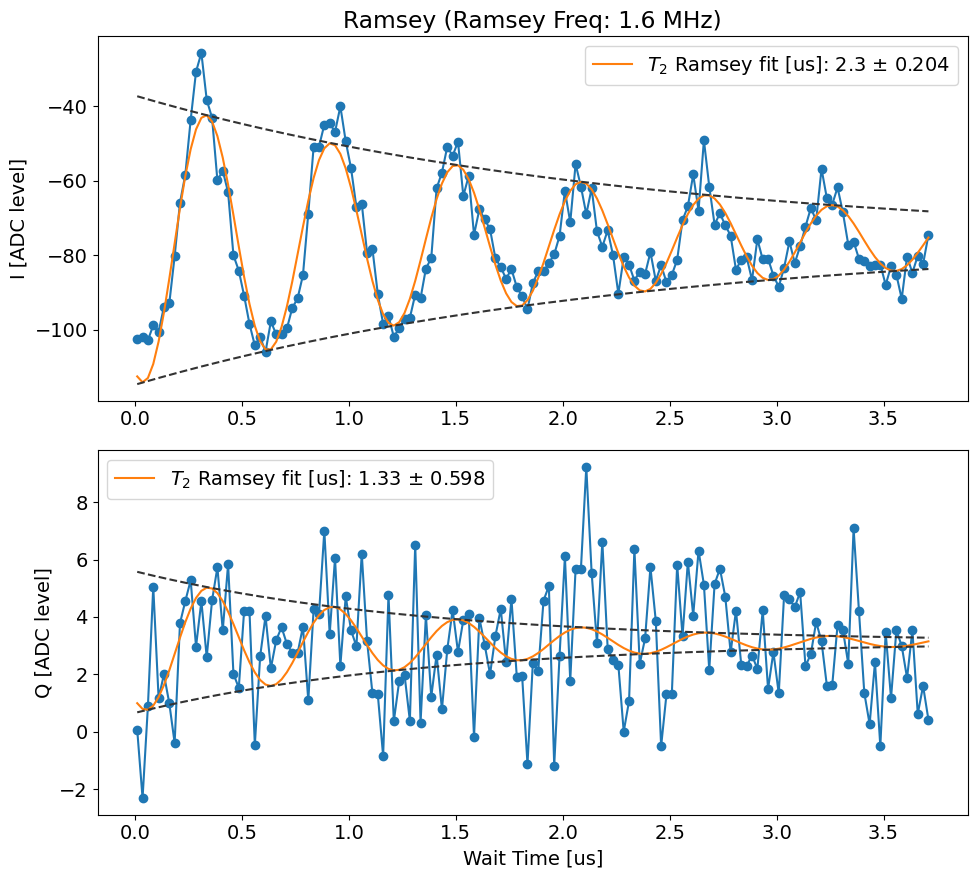

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_19-09-32_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md


In [57]:
cavity_ramsey.analyze()
cavity_ramsey.display()

In [58]:
adjusted_freq = cavity_ramsey.data['f_adjust_ramsey_avgi']
_delta_freq = adjusted_freq[np.argmin(np.abs(adjusted_freq))]
print(f"Adjusted frequency: {_delta_freq} MHz")
expts_base_inst.config_thisrun.device.manipulate.f_ge[0] += _delta_freq
print(f"Updated f_ge frequency: {expts_base_inst.config_thisrun.device.manipulate.f_ge[0]} MHz")

Adjusted frequency: -0.10726091319105513 MHz
Updated f_ge frequency: 4975.546285960956 MHz


## Gain to Alpha Calibration

Will do tomography on the vaccum state 

$W_{\alpha} (|0\rangle\langle0|) = \frac{2}{\pi} e^{-2|\alpha|^2}$

In [59]:
def do_parity_gain_experiment(
    config_thisrun,
    expt_path,
    config_path,
    start=0,
    step=200//3,
    expts=40,
    reps=250,
    rounds=1,
    qubit=0,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=1000,
    singleshot_active_reset=False,
    singleshot_man_reset=True,
    singleshot_storage_reset=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    span=1000,
    prep_e=False,
    manipulate=1,
    displace=(True, 0.05),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500, 
    pulse_correction=False
):
    """
    Run the Parity Gain Experiment with configurable parameters.
    """
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubit': qubit,
        'qubits': qubits,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'singleshot_active_reset': singleshot_active_reset,
        'singleshot_man_reset': singleshot_man_reset,
        'singleshot_storage_reset': singleshot_storage_reset,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'span': span,
        'prep_e': prep_e,
        'manipulate': manipulate,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pulse_correction': pulse_correction
    }
    parity_gain_exp = expts_base_inst.meas.single_qubit.parity_gain.ParityGainExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityGainExperiment', config_file=config_path
    )
    parity_gain_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_gain_exp.cfg.expt = expt_cfg
    parity_gain_exp.cfg.device.readout.relax_delay = [relax_delay]
    
    parity_gain_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_gain_exp


In [60]:
parity_gain_expt = do_parity_gain_experiment(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    pulse_correction=True,
    reps=500,
)

Pulse correction is applied
[3]
1
Parity Gain Program initialized
parity pulse: [[3570.9117350856664, 3569.7028312412162, 3570.9117350856664], [8978, 0, 8978], [0, 1.6426250410354661, 0], [0, 0, 192.83459612369165], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.007, 0.0, 0.007]]
Updating gain register 66


  0%|          | 0/20000 [00:00<?, ?it/s]

[3]
1
Parity Gain Program initialized
parity pulse: [[3570.9117350856664, 3569.7028312412162, 3570.9117350856664], [8978, 0, 8978], [0, 1.6426250410354661, 0], [0, 0, 12.834596123691654], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.007, 0.0, 0.007]]
Updating gain register 66


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00133_ParityGainExperiment.h5


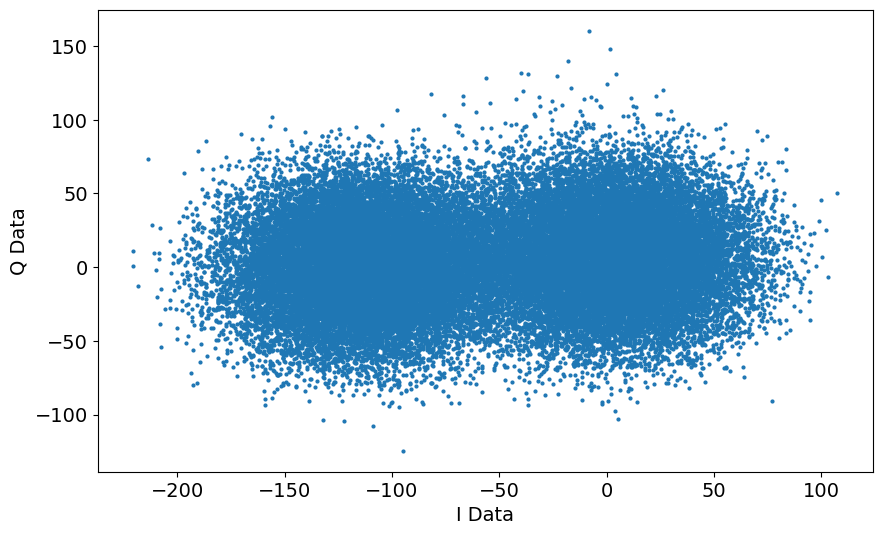

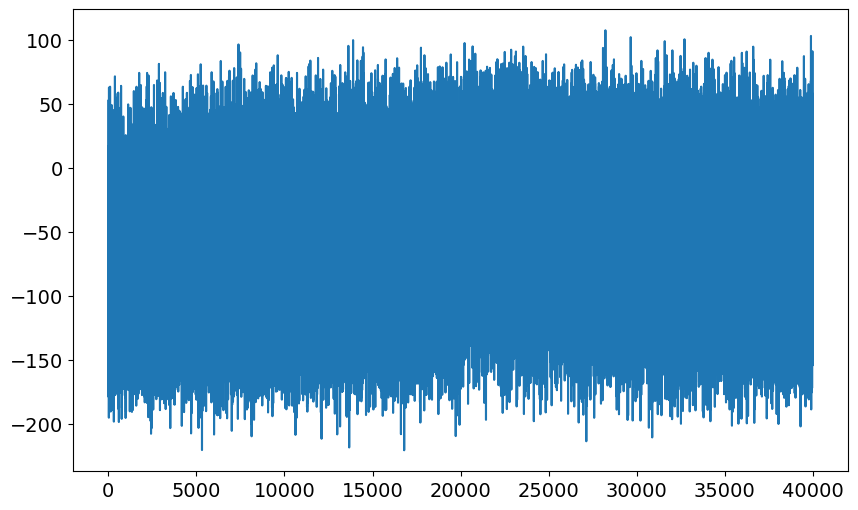

In [61]:
i_data = parity_gain_expt.data['idata']
q_data = parity_gain_expt.data['qdata']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(i_data, q_data, 'o', markersize=2)
ax.set_xlabel('I Data')
ax.set_ylabel('Q Data')
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.plot(i_data)


(500, 40)
(500, 40)
Gain to Alpha Conversion Factor: 0.00069125567448699


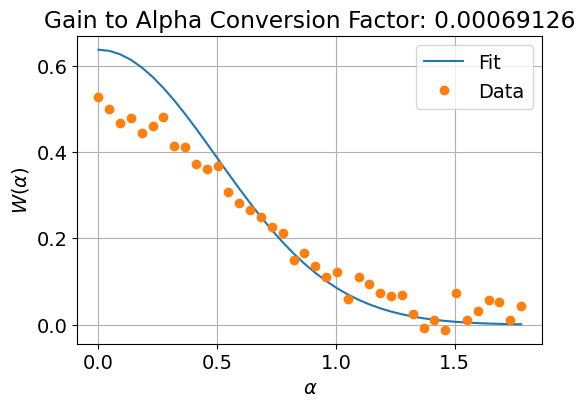

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-10_19-11-51_Gain_to_Alpha_Conversion_Factor_0.00069126.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-10.md
alpha = 1 requires gain of : 1446.64273569


{'xpts': array([   0,   66,  132,  198,  264,  330,  396,  462,  528,  594,  660,
         726,  792,  858,  924,  990, 1056, 1122, 1188, 1254, 1320, 1386,
        1452, 1518, 1584, 1650, 1716, 1782, 1848, 1914, 1980, 2046, 2112,
        2178, 2244, 2310, 2376, 2442, 2508, 2574,    0,   66,  132,  198,
         264,  330,  396,  462,  528,  594,  660,  726,  792,  858,  924,
         990, 1056, 1122, 1188, 1254, 1320, 1386, 1452, 1518, 1584, 1650,
        1716, 1782, 1848, 1914, 1980, 2046, 2112, 2178, 2244, 2310, 2376,
        2442, 2508, 2574]),
 'avgi': array([-101.87204329,  -98.00700866,  -98.17083983,  -97.11135065,
         -96.70564502,  -97.14023377,  -99.30661472,  -91.56145887,
         -91.37254113,  -89.01178355,  -86.9621645 ,  -90.07115584,
         -82.31316883,  -79.98669264,  -78.66430736,  -74.54604762,
         -72.981     ,  -73.31935065,  -70.34329004,  -66.42774026,
         -61.32442857,  -66.22935931,  -67.72874892,  -60.49035498,
         -65.36384848,  -66.13

In [62]:
parity_gain_expt.analyze()

In [63]:
#update device
gain_to_alpha = parity_gain_expt.data['gain_to_alpha']
print(f'Gain to alpha: {gain_to_alpha}')
expts_base_inst.config_thisrun.device.manipulate.gain_to_alpha[0] = gain_to_alpha

Gain to alpha: 0.00069125567448699


## Cavity Ramsey versus gain 

This this to find out $\chi$, $\chi'$, $\Delta$ and $K_c$

In [ ]:
gain_start = 2000//3
gain_stop = 10000//3
gain_step = 600000//3
gain_expts = int((gain_stop - gain_start) / gain_step) + 1
print(f'Gain start: {gain_start}, Gain stop: {gain_stop}, Gain step: {gain_step}, Gain expts: {gain_expts}')

Gain start: 666, Gain stop: 3000, Gain step: 200, Gain expts: 12


In [501]:
cavity_ramsey_sweep = do_cavity_ramsey_gain_sweep(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    gain_start=gain_start,  # start gain
    gain_step=gain_step,      # step size for gain
    gain_expts=gain_expts,        # number of experiments for gain
    ramsey_freq=1.6,
    step = 0.025, 
    expts = 150, 
    reps = 500,
    do_g_and_e=True,
    
    )

  0%|          | 0/12 [00:00<?, ?it/s]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


  8%|▊         | 1/12 [06:17<1:09:13, 377.61s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 17%|█▋        | 2/12 [12:35<1:02:56, 377.61s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 25%|██▌       | 3/12 [18:52<56:38, 377.61s/it]  

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 33%|███▎      | 4/12 [25:10<50:20, 377.61s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 42%|████▏     | 5/12 [31:28<44:03, 377.60s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 50%|█████     | 6/12 [37:45<37:45, 377.62s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 58%|█████▊    | 7/12 [44:03<31:28, 377.62s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 67%|██████▋   | 8/12 [50:20<25:10, 377.61s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 75%|███████▌  | 9/12 [56:38<18:53, 377.73s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 83%|████████▎ | 10/12 [1:02:56<12:35, 377.69s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


 92%|█████████▏| 11/12 [1:09:14<06:17, 377.66s/it]

prep e first
Custom pulse
[[3569.7028312412162], [3522], [0.0], [0], [2], ['gauss'], [0.035]]


100%|██████████| 12/12 [1:15:31<00:00, 377.64s/it]


Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00029_CavityRamseyGainSweepExperiment.h5


gain_to_alpha 0.0006768565439494518
Kerr : -5.595 +/- 1.394 kHz
detuning Ground State: -3.210 +/- 2.787 kHz
Chi: -293.002 +/- 3.400 kHz
Chi2: -3.008 +/- 0.850 kHz
Plot saved to CavityRamseyGainSweep.png
Fit plot saved to CavityRamseyGainSweep_detuning.png


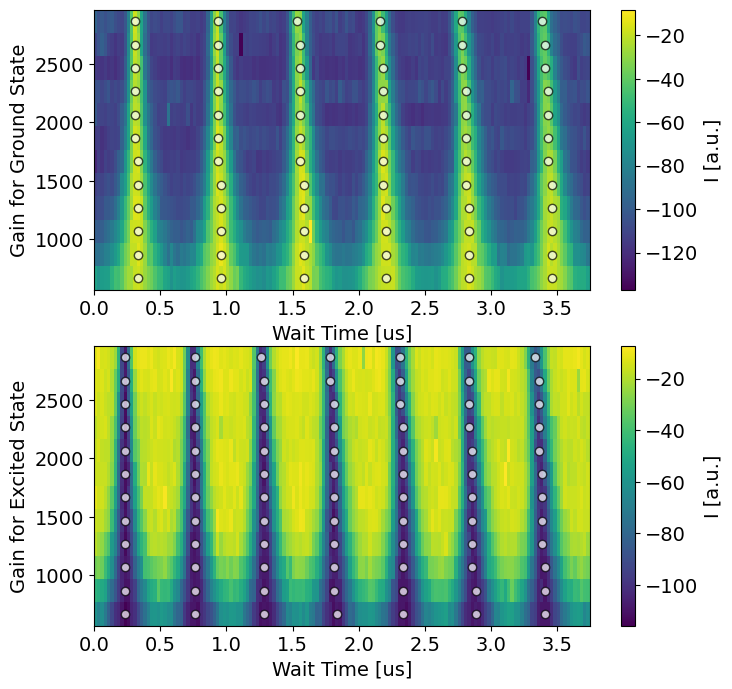

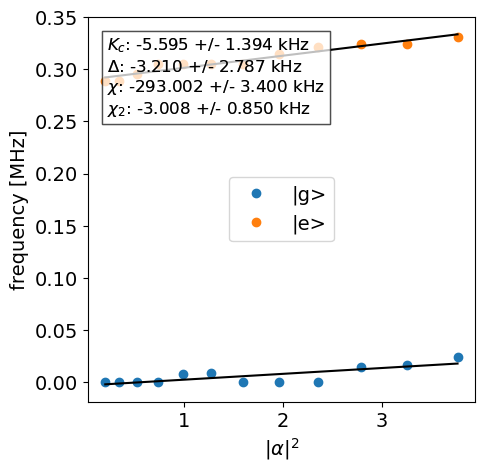

In [504]:
cavity_ramsey_sweep.analyze()
cavity_ramsey_sweep.display(save_fig=True)

In [503]:
delta_g = cavity_ramsey_sweep.data['detuning_g']

expts_base_inst.config_thisrun.device.manipulate.f_ge[0] -= delta_g
print(f"Updated f_ge frequency: {expts_base_inst.config_thisrun.device.manipulate.f_ge[0]} MHz")

Updated f_ge frequency: 4984.848033498723 MHz


## Cavity T1

This is to find out $\kappa$

In [47]:
def do_t1_manipulate(config_thisrun,
                    expt_path,
                    config_path,
                    man_mode_no=1,
                    f0g1_param=None,
                    start = 0, 
                    step = 8,
                    expts = 120,
                    reps = 500,
                    rounds=1, 
                          ):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = expts_base_inst.meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    if f0g1_param is None:
        pulse_param = expts_base_inst.config_thisrun.device.multiphoton.pi['fn-gn+1']
        f0g1_param = [pulse_param['frequency'][0],
                       pulse_param['gain'][0],
                         pulse_param['length'][0], 
                         pulse_param['sigma'][0],
        ]   


    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps= reps,
        rounds= rounds,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param= f0g1_param,  # Use the f0g1_param defined above
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    # t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



This experiment is very broken and needs an update
Using user defined pi-gain and f0g1 parameters


  0%|          | 0/60000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00008_T1CavityExperiment.h5
Fit T1 avgi [us]: 164.36052561886433
Fit T1 avgq [us]: 151.58456673475914


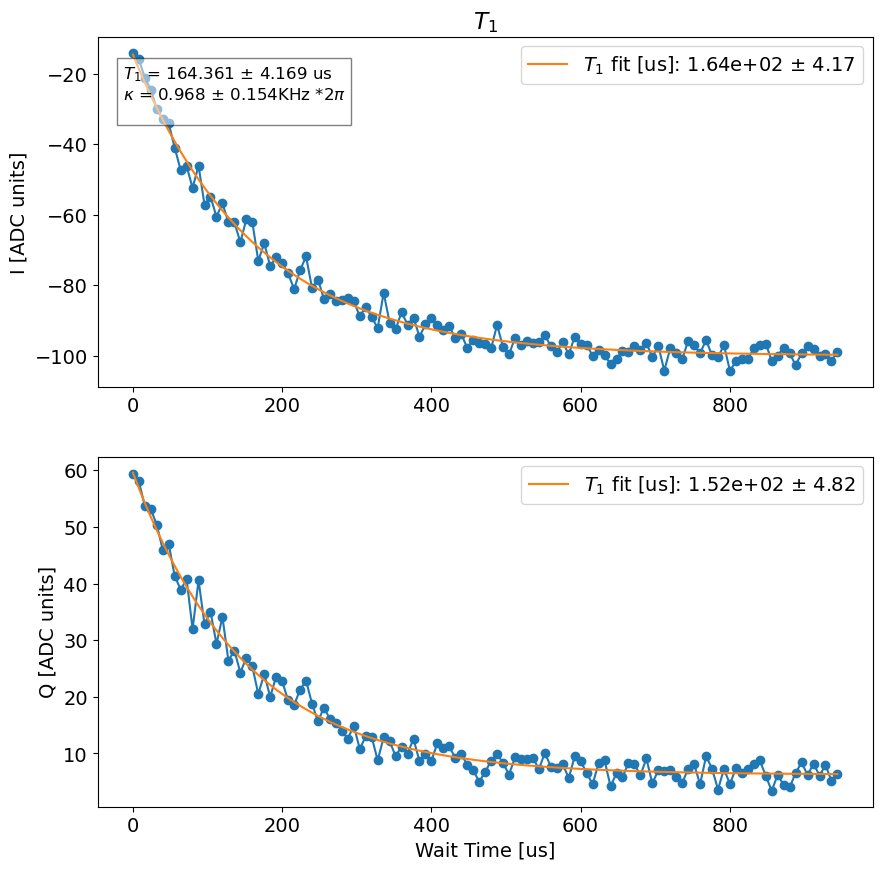

In [48]:
t1_manipulate = do_t1_manipulate(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
)
    

## Cavity T2 

# Wigner Tomography

## Generate Optimal Displacements 

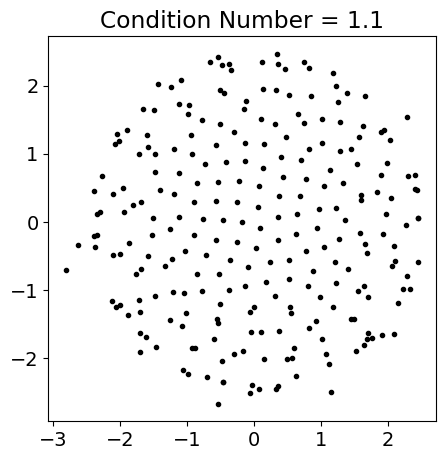

Displacements saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\optimized_displacements_96.npy


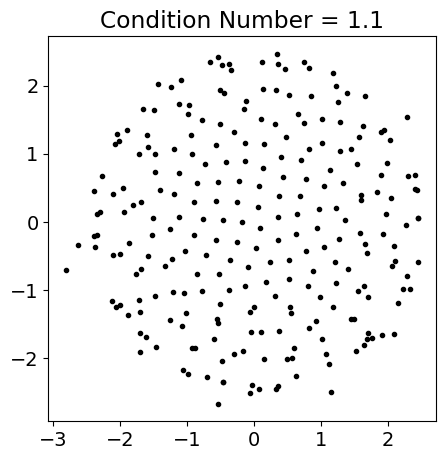

In [577]:
from fitting_folder.wigner import OptimalDisplacementGeneration
# Number of photons 
n_photon = 8
n_disps = 250
opt_alphas = OptimalDisplacementGeneration(FD = n_photon, n_disps=n_disps)
return_dict = opt_alphas.optimize(save_dir = expts_base_inst.expt_path )


In [578]:
# Get frunc from |2>
def do_wigner_tomography_1mode(
    config_thisrun,
    expt_path,
    config_path,
    displace_length=0.05,
    displacement_path=None,
    prepulse=False,
    pre_sweep_pulse=None,
    pre_gate_sweep_pulse=None,
    reps = 1000,
    qubits=[0],
    gate_based=True,
    pulse_correction=False,
    relax_delay=2500,
    post_select_pre_pulse=False,
    opt_pulse=None,
    IQ_table=None,
    active_reset=False,
):
    """
    Run the Wigner Tomography 1 Mode Experiment with configurable parameters.
    """
    expt_cfg = {
        'displace_length': displace_length,
        'displacement_path': displacement_path,
        'reps': reps,
        'rounds': 1,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
        'qubits': qubits,
        'pulse_correction': pulse_correction,
        'post_select_pre_pulse': post_select_pre_pulse,
        'opt_pulse': opt_pulse, 
        'IQ_table': IQ_table,
        'active_reset': active_reset,
    }




    wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomography1ModeExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomography1ModeExperiment', config_file=config_path
    )
    wigner_exp.cfg = AttrDict(deepcopy(config_thisrun))
    wigner_exp.cfg.expt = expt_cfg
    wigner_exp.cfg.expt.gate_based = gate_based  # Set gate_based to False for Wigner tomography
    wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
    # wigner_exp.cfg.device.readout.phase = 90.0  # Set readout phase to 0.0

    wigner_exp.go(analyze=True, display=False, progress=True, save=False)
    return wigner_exp

print(expts_base_inst)
# print(wigner_exp)


def do_wigner_tomography_1mode_optimal(
    config_thisrun,
    expt_path,
    config_path,
    pulse_to_test,
    nb_plot = 3, 
    displace_length=0.05,
    displacement_path=None,
    prepulse=False,
    pre_sweep_pulse=None,
    pre_gate_sweep_pulse=None,
    reps = 1000,
    qubits=[0],
    gate_based=True,
    pulse_correction=False,
    relax_delay=2500,
    post_select_pre_pulse=False,
    opt_pulse=None,
    IQ_table=None,
    active_reset=False,
):
    

    expt_cfg = {
        'displace_length': displace_length,
        'displacement_path': displacement_path,
        'reps': reps,
        'rounds': 1,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
        'qubits': qubits,
        'pulse_correction': pulse_correction,
        'post_select_pre_pulse': post_select_pre_pulse,
        'opt_pulse': opt_pulse, 
        'IQ_table': IQ_table,
        'pulse_to_test': pulse_to_test,  # Add pulse_to_test to the configuration   
        'nb_plot': nb_plot,  # Number of plots to generate
        'active_reset': active_reset,
    }

    wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomographyOptimalPulseExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomographyOptimalPulseExperiment', config_file=config_path
    )
    wigner_exp.cfg = AttrDict(deepcopy(config_thisrun))
    wigner_exp.cfg.expt = expt_cfg
    wigner_exp.cfg.expt.gate_based = gate_based
    wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
    # wigner_exp.cfg.device.readout.phase = 90.0  # Set readout phase to 0.0

    wigner_exp.go(analyze=True, display=False, progress=True, save=True)
    return wigner_exp
        

## Wigner Tomography

### Sidebands

In [579]:
photon_list_pre = [1]
prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list_pre, broadband=True)
# prep_man_pi.append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse
# photon_list = [0, 2]
# prep_man_bis = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list, broadband=True)
# for _pulse in prep_man_bis:
#     prep_man_pi.append(_pulse)
# print(f'Prepulse: {prep_man_pi}')
pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()

### Optimal control 

In [580]:
prepulse = [
            # ['optimal_control', 'fock', '0+2', [0, 0]], 
            ['optimal_control', 'fock', '2', [0, 0]], 
            ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav
pulse = mm_base_calib.get_prepulse_creator(prepulse, cfg=expts_base_inst.config_thisrun).pulse.tolist()

Gain for qubit: 800, Gain for cavity: 1405


In [ ]:
wigner = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 1000,
    displacement_path=return_dict['path'], #optimal displacement path
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based = False,
    pulse_correction=True,
    # relax_delay=1000, 
    relax_delay=2500, 
    post_select_pre_pulse=False,
    # active_reset=True
)

  0%|          | 0/251 [00:00<?, ?it/s]

In [564]:
wigner.analyze()

(500, 151)
(500, 151)


{'alpha': array([ 0.        +0.j        , -0.98474093+2.20656723j,
        -0.44920186+0.44179983j,  0.44258306-0.4356475j ,
        -1.18457708-0.94016488j, -1.26388314+0.95005001j,
        -2.2100879 -0.61946015j,  0.09455735+0.04959361j,
         0.80110811-2.22280757j, -0.25506755-1.19703597j,
         1.2191098 -0.37022896j, -2.04318584+1.01501558j,
        -0.16672986+1.55205695j,  2.12222943+1.18011937j,
        -0.93535456+1.16087237j, -0.20738138-0.79282334j,
         2.05296354-0.24925951j,  2.27246388-0.26207652j,
         0.34968019-2.29403236j,  1.68368781+0.28059317j,
         0.58627704-1.12281998j,  0.58356769+1.7420054j ,
        -1.5950992 +1.78443668j,  0.87632636-1.69166446j,
        -0.91487455+0.74567081j, -0.42356953+0.83485775j,
         0.23955585-1.18557298j, -0.48913217+0.09960941j,
         0.46584918+1.4680114j , -0.2354893 +2.01277253j,
         0.78203371-0.45930194j,  1.78906676+1.67469543j,
        -0.20361753-0.10283144j,  1.49881191-1.91983238j,
     

In [565]:
wigner.data['alpha'].shape

(151,)

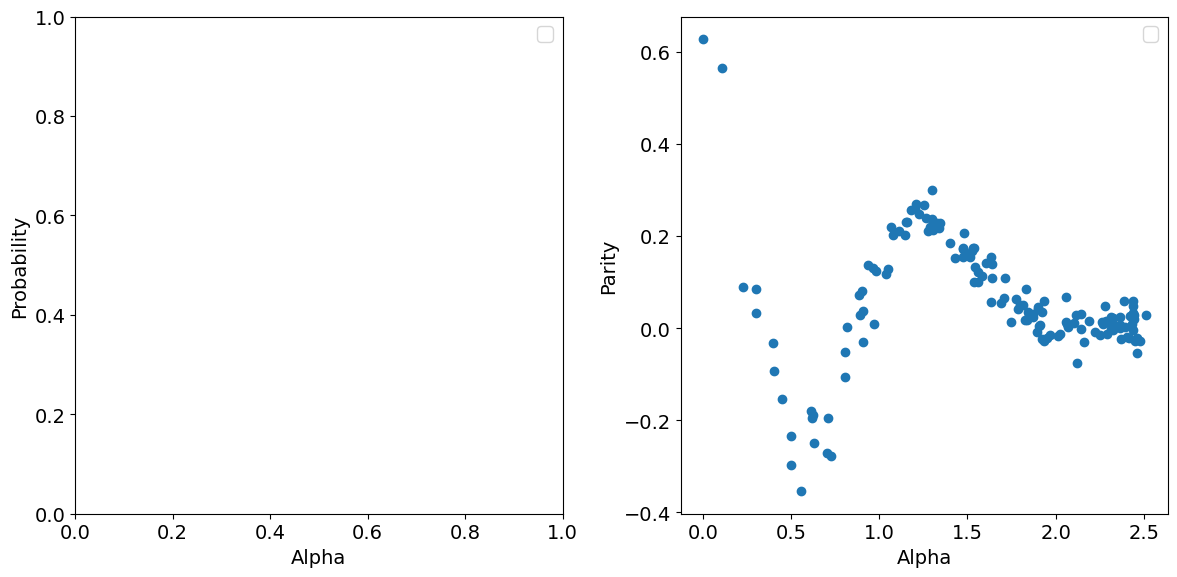

In [566]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# pe_plus = wigner.data['pe_plus']
# pe_minus = wigner.data['pe_minus']
# pe = pe_plus + pe_minus
# ax[0].plot(np.abs(wigner.data['alpha']), pe, 'o')
# ax[0].plot(np.abs(wigner.data['alpha']), pe_plus, 'o', label='pe_plus')
# ax[0].plot(np.abs(wigner.data['alpha']), pe_minus, 'o', label='pe_minus')

# parity_plus = wigner.data['parity_plus']
# parity_minus = wigner.data['parity_minus']
parity = wigner.data['parity']
ax[1].plot(np.abs(wigner.data['alpha']), 2 / np.pi *parity, 'o')
# ax[1].plot(np.abs(wigner.data['alpha']), 2 / np.pi *parity_plus, 'o', label='parity_plus')
# ax[1].plot(np.abs(wigner.data['alpha']), 2 / np.pi *parity_minus, 'o', label='parity_minus')

ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Probability')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Parity')
ax[0].legend()
ax[1].legend()
plt.tight_layout()

In [567]:
# get GKP states
def get_hex_GKP(Delta,d,N):
    psi_list = [0*qt.basis(N,0) for _ in range(d)]
    e1 = np.sqrt(2*np.pi/d/np.sqrt(3))*(np.sqrt(3)/2-0.5j)
    e2 = np.sqrt(2*np.pi/d/np.sqrt(3))*1j
    for n1 in range(-30,31):
        for n2 in range(-30,31):
            for mu in range(d):
                a1 = e1*(d*n1+mu)
                a2 = e2*n2
                psi_list[mu] += np.exp((a1*np.conj(a2)-np.conj(a1)*a2)/2)*qt.coherent(N,a1+a2,method='analytic')

    psis = [((-Delta**2*qt.num(N)).expm()*psi).unit() for psi in psi_list]
    return psis[0]

supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.8957')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-10-06_22-34-44_.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-10-06.md


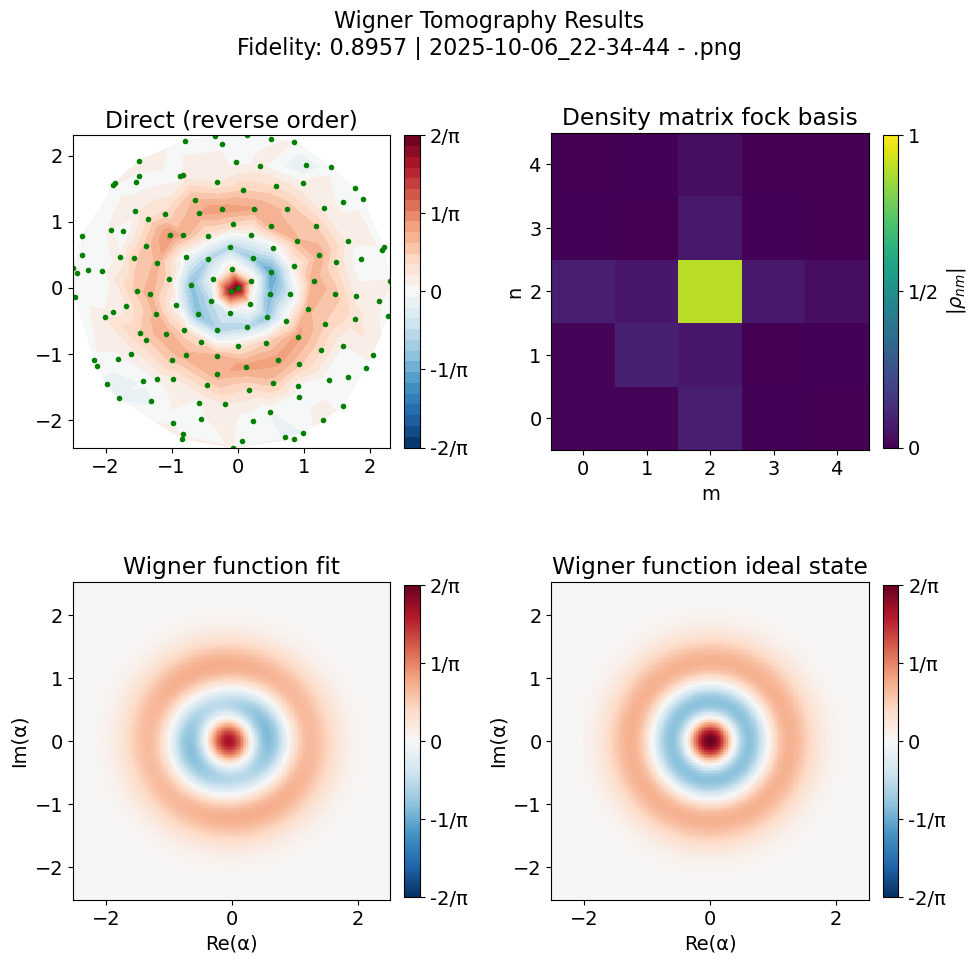

In [569]:
from fitting_folder.wigner import WignerAnalysis
wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=5, alphas = wigner.data['alpha'])
import qutip as qt
state_list = qt.zero_ket(wigner_analysis.m)  # Initialize the state list with the zero state |0>
# for i in photon_list_pre:

#     coeff = i/np.abs(i) if np.abs(i)>0 else 1
#     state_list += coeff*qt.fock(wigner_analysis.m, int(np.abs(i)))
# initial_state = state_list.unit()  # Normalize the state
# initial_state = get_hex_GKP(0.408,2,wigner_analysis.m)
# initial_state = (qt.fock(wigner_analysis.m, 0)).unit()  # Fock state |2>

# Dp = qt.displace(wigner_analysis.m, 1.2)  # Displacement operator with displacement parameter 1
# Dm = qt.displace(wigner_analysis.m, -1.2)  # Displacement operator with displacement parameter 1
initial_state = (qt.fock(wigner_analysis.m, 2)).unit()  # Displaced vacuum state |0> with displacement parameter 1
# initial_state = ((Dp+Dm)*qt.fock(wigner_analysis.m, 0)).unit()  # Displaced vacuum state |0> with displacement parameter 1



results = wigner_analysis.wigner_analysis_results(wigner.data['parity'], initial_state=initial_state, rotate=True)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '')

In [239]:
results.keys()
# save results in a npz file
np.savez_compressed(expts_base_inst.expt_path + 'WignerResults.npz',
                    rho = results['rho'],
                    fidelity = results['fidelity'],
                    target_state = initial_state.full(),
                    Wigner = results['W_fit'],
                    alpha_wigner = results['x_vec']
                    )

In [245]:
# reopen and check
data = np.load(expts_base_inst.expt_path + 'WignerResults.npz')
data['Wigner'].shape

(200, 200)

## Debug optimal control
This is taking one optimal control pulse and measure both the qubit and cavity tomography for several time slices. 

In [305]:
# prepulse = [['optimal_control', 'test', '2', [0, 0]]]
# gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
# print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
# expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
# expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav
# prepulse = mm_base_calib.get_prepulse_creator(prepulse, cfg=expts_base_inst.config_thisrun).pulse.tolist()


pulse_to_test = [['optimal_control', 'fock', '1', [0, 0]]]
pulse_conf = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]

# set gain 
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_to_test[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
# expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= 20000
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
# expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= 20000
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav



# import the I, Q, times 
filename = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['filename']
data = np.load(filename, allow_pickle=True)
times = data['times'] * 1e-3
Ic = data['I_c']
Qc = -data['Q_c']
Iq = data['I_q']
Qq = -data['Q_q']
qb_scale = max((np.max(np.abs(Iq)), np.max(np.abs(Qq))))
cav_scale = max((np.max(np.abs(Ic)), np.max(np.abs(Qc))))

if qb_scale !=0: 
    Iq /= qb_scale
    Qq /= qb_scale

if cav_scale !=0: 
    Ic /= cav_scale
    Qc /= cav_scale

t_length = len(times)
nb_plot = 1
t_step = (times[-1] - times[0]) / nb_plot
# t_to_plot = np.arange(0, times[-1]+t_step, t_step)
t_to_plot = np.array([times[-1]])
# t_to_plot[0] +=0.05

data_tot = []
data.close()


Gain for qubit: 667, Gain for cavity: 1381


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(times, Ic, label='Cavity I')
ax.scatter(times, Qc, label='Cavity Q')
ax.scatter(times, Iq, label='Qubit I')
ax.scatter(times, Qq, label='Qubit Q')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Normalized Signal')
ax.legend()
# add vertical lines at t_to_plot
for t in t_to_plot:
    ax.axvline(t, color='k', linestyle='--', alpha=0.5)

In [ ]:
for i in range(len(t_to_plot)):

    idx_t = np.argmin(np.abs(times - t_to_plot[i]))
    IQ_table = {
        'I_c': Ic[:idx_t],
        'Q_c': Qc[:idx_t],
        'I_q': Iq[:idx_t],
        'Q_q': Qq[:idx_t],
        'times': times[:idx_t]
    }

    wigner = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 250,
    displacement_path=return_dict['path'], #optimal displacement path
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based = False,
    pulse_correction=True,
    active_reset=True,
    relax_delay=2500, 
    post_select_pre_pulse=False,
    IQ_table=IQ_table,
    opt_pulse=pulse_to_test
    )

    wigner.analyze()
    wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                      mode_state_num=10, alphas = wigner.data['alpha'])
    results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                       initial_state=qt.fock(wigner_analysis.m, 0), rotate=False)
    fig = wigner_analysis.plot_wigner_reconstruction_results(results, 
                                                             initial_state=qt.fock(wigner_analysis.m, 0), state_label = '')


    rho = results['rho']
    wigner.data['rho'] = rho
    data_tot.append(wigner.data)

In [ ]:
plot_wigner = True
n_distr = np.zeros((len(data_tot), wigner_analysis.m))
p_vec =np.zeros((len(data_tot), 2))
# for each time slice use the rho to compute the photon number distribution
for i in range(len(data_tot)):
    _n_distr = np.diag(data_tot[i]['rho'])
    n_distr[i, :] = _n_distr
    p_vec[i, 1] = data_tot[i]['pe_postpulse']
    p_vec[i, 0] = 1 - p_vec[i, 1]



# open simulation data
if 'pulse' in filename:
    filename_th = filename.replace('pulse', 'pop_sim\populations')
else:
    filename_th = filename.replace('optimal_control\\', 'optimal_control\\pop_sim\\populations_')
data_th = np.load(filename_th, allow_pickle=True)
n_distr_th = data_th['cavity']
p_vec_th = data_th['qubit'][1, :]
times_th = data_th['times'] * 1e-3
rho_cav_t = data_th['rho_cav_t']

F_vec = np.zeros(len(data_tot))

for i in range(len(data_tot)):
    rho_exp = qt.Qobj(data_tot[i]['rho'])
    cutoff_exp = rho_exp.shape[0]
    cutoff_th = rho_cav_t.shape[1]
    cutoff = min(cutoff_exp, cutoff_th)
    idx_t = np.argmin(np.abs(times_th - t_to_plot[i]))
    rho_th = qt.Qobj(rho_cav_t[:cutoff, :cutoff, idx_t])
    rho_exp = qt.Qobj(rho_exp[:cutoff, :cutoff])
    F_vec[i] = qt.fidelity(rho_exp, rho_th)

    if plot_wigner:
        vmin = -2 / np.pi
        vmax = 2 / np.pi
        alpha_list = data_tot[i]['alpha']
        alpha_max = np.max(np.abs(alpha_list))*1.5
        x_vec = np.linspace(-alpha_max, alpha_max, 150)
        W_exp= qt.wigner(rho_exp, x_vec, x_vec)
        W_th = qt.wigner(rho_th, x_vec, x_vec)
        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        # ax[0].set_aspect('equal')
        ax[0].pcolormesh(x_vec, x_vec, W_exp, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        ax[0].set_xlabel('Re(α)')
        ax[0].set_ylabel('Im(α)')
        ax[0].set_title(f'Exp at t={t_to_plot[i]:.2f} us')

        # ax[1].set_aspect('equal')
        ax[1].pcolormesh(x_vec, x_vec, W_th, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        ax[1].set_xlabel('Re(α)')
        ax[1].set_ylabel('Im(α)')
        ax[1].set_title(f'Th')
        fig.tight_layout()

        # save the figure the the filemane for pop
        fig.savefig(filename_th.replace('.npz', f'_wigner_{i}.png'), dpi=300)


    


# plot a heatmap of the photon number distribution and qubit

fig1, ax1 = plt.subplots(2, 1, figsize=(6, 6))
cax = ax1[0].imshow(n_distr.T, 
                   aspect='auto', origin='lower', cmap='viridis', 
                   extent=[t_to_plot[0], t_to_plot[-1], 0, n_distr.shape[1]-1])
ax1[0].set_xlabel('Time (us)')
ax1[0].set_ylabel('Photon Number')
ax1[0].set_title('Photon Number Distribution exp/theory')

cax2 = ax1[1].imshow(n_distr_th[:n_distr.T.shape[0], ],
                     aspect='auto', origin='lower', cmap='viridis',
                     extent=[times_th[0], times_th[-1], 0,n_distr.T.shape[0]-1])
ax1[1].set_xlabel('Time (us)')
ax1[1].set_ylabel('Photon Number')
# fig.colorbar(cax, ax=ax[0])
fig1.tight_layout()
# save the figure
fig1.savefig(filename_th.replace('.npz', '_photon_distribution.png'), dpi=300)

fig2, ax2 = plt.subplots(2, 1, figsize=(6, 6))

ax2[0].plot(t_to_plot, p_vec[:, 0], 'o-', label='e',
           color='tab:blue', markersize=4, linewidth=1.2)
ax2[0].plot(t_to_plot, p_vec[:, 1], 'o-', label='g',
           color='tab:red', markersize=4, linewidth=1.2)
ax2[0].plot(times_th, p_vec_th, linestyle='--', color = 'tab:blue')
ax2[0].plot(times_th, 1-p_vec_th, linestyle='--', color='tab:red')
ax2[0].set_xlabel('Time (us)')
ax2[0].set_ylabel('Probability')
ax2[0].set_title('Qubit Probabilities')
ax2[0].legend()

ax2[1].plot(t_to_plot, F_vec, 'o-', color='tab:green', markersize=4, linewidth=1.2)
ax2[1].set_xlabel('Time (us)')
ax2[1].set_ylabel('Fidelity')
ax2[1].set_title('Cavity state')
fig2.tight_layout()
# save the figure
fig2.savefig(filename_th.replace('.npz', '_qubit_fidelity.png'), dpi=300)


In [ ]:
# close all files npz and plt
plt.close('all')
data_th.close()

In [ ]:
# save the data
np.savez(filename_th.replace('.npz', '_data.npz'),
         n_distr=n_distr, p_vec=p_vec, F_vec=F_vec,
         n_distr_th=n_distr_th, p_vec_th=p_vec_th, times=times_th,
         t_to_plot=t_to_plot, data_tot=data_tot)

## CMA-ES solver

In [143]:
from stable_baselines3 import PPO
from CavityQubitEnv import CavityQubitEnv
import qutip as qt
import numpy as np
import cma 


### Pulse to test 

In [168]:

pulse_to_test = [['optimal_control', 'fock', '2', [0, 0]]]
pulse_conf = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]

# set gain 
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_to_test[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav

# import the I, Q, times 
filename = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['filename']
data = np.load(filename, allow_pickle=True)
times = data['times'] * 1e-3
Ic = data['I_c']
Qc = -data['Q_c']
Iq = data['I_q']
Qq = -data['Q_q']
# qb_scale = max((np.max(np.abs(Iq)), np.max(np.abs(Qq))))
# cav_scale = max((np.max(np.abs(Ic)), np.max(np.abs(Qc))))

# if qb_scale !=0: 
#     Iq /= qb_scale
#     Qq /= qb_scale

# if cav_scale !=0: 
#     Ic /= cav_scale
#     Qc /= cav_scale

t_length = len(times)
nb_plot = 1
t_step = (times[-1] - times[0]) / nb_plot
t_to_plot = np.array([times[-1]])
data.close()


Gain for qubit: 810, Gain for cavity: 2339


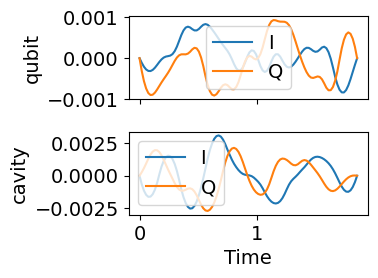

In [190]:
cutoff_cav = 7
psi_0 = qt.fock(cutoff_cav, 0)  # Initial cavity state |0>
# psi_target = (qt.fock(cutoff_cav, 0)+qt.fock(cutoff_cav, 4)).unit()  # Target cavity state |1>
psi_target = (qt.fock(cutoff_cav, 2)).unit()  # Target cavity state |1>
Kc = 0.009422
Kq = -143
chi = 0.310457
system_params = {
    'cutoff_qubit': 2,
    'cutoff_cavity': cutoff_cav,
    'Kc': Kc,
    'Kq': Kq,
    'chi': chi
}
pulse_IQ = {
    'Ic': Ic,
    'Qc': Qc,
    'Iq': Iq,
    'Qq': Qq,
    'times': times
}

amplitude_bound_qb = max(np.max(np.abs(Iq)), np.max(np.abs(Qq)))*0.2
amplitude_bound_cav = max(np.max(np.abs(Ic)), np.max(np.abs(Qc)))*0.2
amplitude_bounds = [amplitude_bound_qb, amplitude_bound_cav]

fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(times, Iq, label='I')
ax[0].plot(times, Qq, label='Q')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(times, Ic, label='I')
ax[1].plot(times, Qc, label='Q')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
ax[1].legend()
fig.tight_layout()




In [196]:
N_points = 25  # number of points of a pulse
nb_sample = None  # number of samples per wigner
n_generations = 100
n_repeat = 4  # number of times to repeat the optimization

env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ, 
    amplitude_bounds=amplitude_bounds,
    N_points=N_points,
    nb_sample=nb_sample
)


dim = env.action_space.shape[0]  # = 4*L
sigma0 = 0.1             # initial standard deviation
x0 = np.zeros(dim)               # initial mean (all zero actions)
# popsize =(4 + int(3 * np.log(dim)))*2
popsize = 5
print(f"popsize={popsize}")

# --- CMA-ES optimizer ---
# Popsize formula: 4 + floor(3*log(dim))
es = cma.CMAEvolutionStrategy(x0, sigma0, {
    "popsize": popsize,
    "bounds": [-1.0, 1.0],  # actions are clipped to [-1,1]
})
fidelity_history = []
logger = es.logger  # attach the default logger

popsize=5
(2_w,5mirr1)-aCMA-ES (mu_w=1.6,w_1=73%) in dimension 92 (seed=62464, Sat Sep 27 18:57:52 2025)


In [197]:
pulse_IQ_temp = env.generate_IQ_pulse(action)
pulse_IQ_test = env.interpolate_IQ_pulse(pulse_IQ_temp)

ValueError: operands could not be broadcast together with shapes (23,) (123,) 

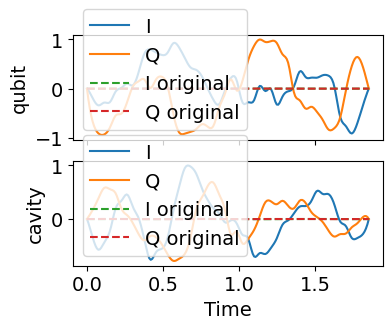

In [198]:
fig , ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(pulse_IQ_test['times'], pulse_IQ_test['Iq'], label='I')
ax[0].plot(pulse_IQ_test['times'], pulse_IQ_test['Qq'], label='Q')
ax[0].plot(pulse_IQ['times'], pulse_IQ['Iq'], linestyle='--', label='I original')
ax[0].plot(pulse_IQ['times'], pulse_IQ['Qq'], linestyle='--', label='Q original')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(pulse_IQ_test['times'], pulse_IQ_test['Ic'], label='I')
ax[1].plot(pulse_IQ_test['times'], pulse_IQ_test['Qc'], label='Q')
ax[1].plot(pulse_IQ['times'], pulse_IQ['Ic'], linestyle='--', label='I original')
ax[1].plot(pulse_IQ['times'], pulse_IQ['Qc'], linestyle='--', label='Q original')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
ax[1].legend()

Generation 73/100 - Action 2/5
Fidelity: 0.8010, Reward: 0.1990


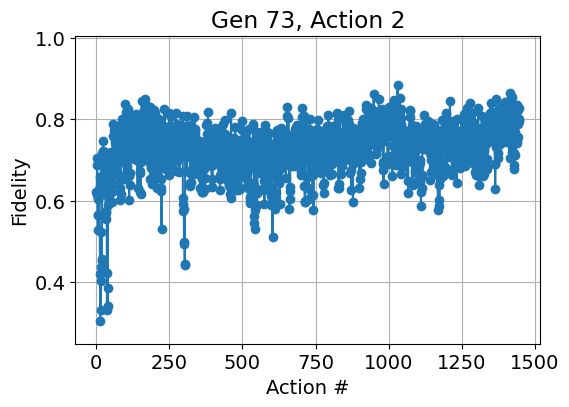

Gain for qubit: 791, Gain for cavity: 2493
  Repeat 1/4 for action 3/5


  0%|          | 0/101 [00:00<?, ?it/s]

(150, 101)
(150, 101)
  Repeat 2/4 for action 3/5


  0%|          | 0/101 [00:00<?, ?it/s]

(150, 101)
(150, 101)
  Repeat 3/4 for action 3/5


  0%|          | 0/101 [00:00<?, ?it/s]

KeyboardInterrupt: 

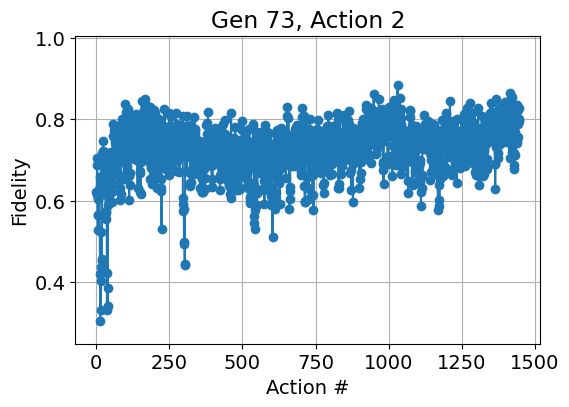

In [199]:
from IPython.display import clear_output
fig, ax = plt.subplots(figsize=(6,4))

# fig1, ax1 = plt.subplots()

for gen in range(n_generations):
    solutions = es.ask()
    rewards = []
    for idx, action in enumerate(solutions):
        vals = []
        pulse_IQ_temp = env.generate_IQ_pulse(action)
        pulse_IQ_test = env.interpolate_IQ_pulse(pulse_IQ_temp)
        gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_IQ=pulse_IQ_test)
        expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
        expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav
        print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
        qb_scale = max(np.max(np.abs(pulse_IQ_test['Iq'])), np.max(np.abs(pulse_IQ_test['Qq'])))
        cav_scale = max(np.max(np.abs(pulse_IQ_test['Ic'])), np.max(np.abs(pulse_IQ_test['Qc'])))
        if qb_scale !=0: 
            pulse_IQ_test['Iq'] /= qb_scale
            pulse_IQ_test['Qq'] /= qb_scale
        if cav_scale !=0:
            pulse_IQ_test['Ic'] /= cav_scale
            pulse_IQ_test['Qc'] /= cav_scale

        IQ_table = {
            'I_c': pulse_IQ_test['Ic'],
            'Q_c': pulse_IQ_test['Qc'],
            'I_q': pulse_IQ_test['Iq'],
            'Q_q': pulse_IQ_test['Qq'],
            'times': pulse_IQ_test['times']
        }

        for r in range(n_repeat):  # repeat the experiment n_repeat times and average the reward
            print(f"  Repeat {r+1}/{n_repeat} for action {idx+1}/{len(solutions)}")

            wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 150,
            displacement_path=return_dict['path'], #optimal displacement path
            prepulse=False,
            pre_sweep_pulse=None,
            gate_based = False,
            pulse_correction=False,
            relax_delay=2500, 
            # relax_delay=1000,
            # active_reset=True, 
            post_select_pre_pulse=False,
            IQ_table=IQ_table,
            opt_pulse=pulse_to_test
            )

            wigner.analyze()
            wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                            mode_state_num=cutoff_cav, alphas = wigner.data['alpha'])
            results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                            initial_state=psi_target, rotate=False)
            # fig1 = wigner_analysis.plot_wigner_reconstruction_results(results, 
                                                                    # initial_state=psi_target, state_label = '')

            fidelity = results['fidelity']
            reward = 1 - fidelity  # reward is 1 - fidelity to minimize
            vals.append(reward)
            fidelity_history.append(fidelity)

        
        rewards.append(np.mean(vals))
        # --- clear notebook cell output ---
        clear_output(wait=True)
        print(f"Generation {gen+1}/{n_generations} - Action {idx+1}/{len(solutions)}")
        print(f"Fidelity: {fidelity:.4f}, Reward: {reward:.4f}")

        # --- redraw plot ---
        ax.clear()
        ax.plot(fidelity_history, marker="o")
        ax.set_title(f"Gen {gen+1}, Action {idx+1}")
        ax.set_xlabel("Action #")
        ax.set_ylabel("Fidelity")
        ylim = ax.get_ylim()
        ax.set_ylim(max(0, ylim[0]*0.9), min(1.1, ylim[1]*1.1))
        plt.grid(True)
        display(fig) 


    es.tell(solutions, rewards)
    es.disp()
    logger.add()      # <-- log this generation
    logger.save()     # <-- save to outcmaes folder



Best solution (xbest): [ 0.32025759 -0.27436624 -0.21549801 -0.08154347 -0.30142285  0.58367401
  0.04709609 -0.00616262  0.81312681 -0.32636764  0.52313141 -0.2535327
 -0.31292705 -0.48237241  0.00113858  0.22698841 -0.59063835 -0.02053545
 -0.24027899 -0.41380738 -0.08698447  0.64957761 -0.11177894  0.37164536
 -0.40007109  0.26349415 -0.09911662 -0.30326915  0.39802666 -0.19674982
  0.14977263  0.83975414  0.23522525 -0.46242255 -0.42177215 -0.36686585
 -0.14082623 -0.10385719  0.19032218  0.3463752  -0.39313608 -0.71401886
  0.5511333  -0.17663541 -0.60262011  0.23854956 -0.64085207 -0.04740133
  0.00318946  0.34760218 -0.16373165  0.1380532  -0.42413465  0.02946793
  0.31040888  0.32824288 -0.21079987 -0.43391502 -0.9321371  -0.12137848
  0.3635427  -0.0308735   0.09290795  0.31491424 -0.0816904   0.00460374
 -0.45466785  0.53456147  0.23340135 -0.45189186  0.48096471 -0.05765001
  0.99915369  0.3034153  -0.09321438 -0.30326304 -0.3675107   0.57825026
  0.09500018 -0.20633365 -0.2

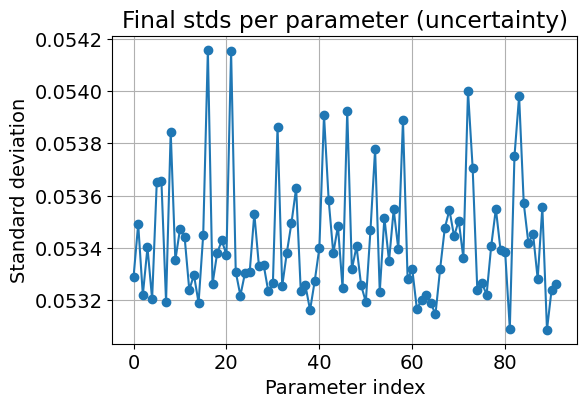

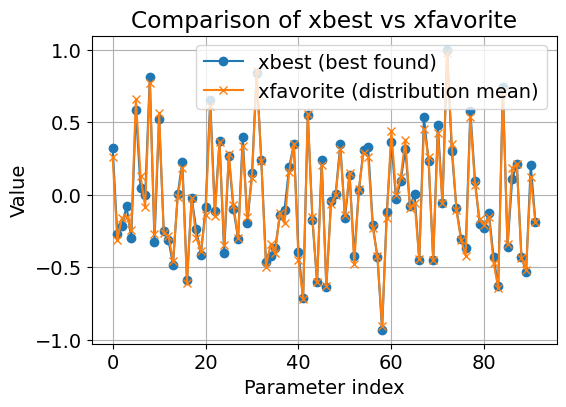

In [200]:
# Suppose `res` is your CMAEvolutionStrategyResult
res = es.result  # replace with your actual result

# --- 1. Best objective value ---
print("Best solution (xbest):", res.xbest)
print("Best fitness (fbest):", res.fbest)
print("Found at evaluation:", res.evals_best)

# --- 2. Plot standard deviations (uncertainty per parameter) ---
plt.figure(figsize=(6,4))
plt.plot(res.stds, marker='o')
plt.title("Final stds per parameter (uncertainty)")
plt.xlabel("Parameter index")
plt.ylabel("Standard deviation")
plt.grid(True)
plt.show()

# --- 3. Compare xbest vs xfavorite ---
plt.figure(figsize=(6,4))
plt.plot(res.xbest, 'o-', label="xbest (best found)")
plt.plot(res.xfavorite, 'x-', label="xfavorite (distribution mean)")
plt.title("Comparison of xbest vs xfavorite")
plt.xlabel("Parameter index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [201]:
# save the best pulse
best_action = res.xbest
times = pulse_IQ['times']
pulse_IQ_updated = env.interpolate_IQ_pulse(env.generate_IQ_pulse(best_action)).values()

# save to the pulse folder 

np.savez_compressed(filename.replace('.npz', '_optimized.npz'),
                    times=times*1e3,  # back to us
                    I_c=pulse_IQ_updated['Ic'],
                    Q_c=pulse_IQ_updated['Qc'],
                    I_q=pulse_IQ_updated['Iq'],
                    Q_q=pulse_IQ_updated['Qq']
                    )

TypeError: 'dict_values' object is not subscriptable

## CMA-ES solver filter function 

In [570]:
from stable_baselines3 import PPO
from CavityQubitEnv import CavityQubitEnv
import qutip as qt
import numpy as np
import cma 
from CavityQubitEnv import PredistortionFilter
import CavityQubitEnv as cav 


### Pulse to test 

In [571]:

pulse_to_test = [['optimal_control', 'fock', '2', [0, 0]]]
pulse_conf = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]

# set gain 
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_to_test[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav

# import the I, Q, times 
filename = expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['filename']
data = np.load(filename, allow_pickle=True)
times = data['times'] * 1e-3
Ic = data['I_c']
Qc = -data['Q_c']
Iq = data['I_q']
Qq = -data['Q_q']


t_length = len(times)
nb_plot = 1
t_step = (times[-1] - times[0]) / nb_plot
t_to_plot = np.array([times[-1]])
data.close()


Gain for qubit: 800, Gain for cavity: 1405


In [572]:
cutoff_cav = 5
psi_0 = qt.fock(cutoff_cav, 0)  # Initial cavity state |0>
# psi_target = (qt.fock(cutoff_cav, 0)+qt.fock(cutoff_cav, 4)).unit()  # Target cavity state |1>
psi_target = (qt.fock(cutoff_cav, 2)).unit()  # Target cavity state |1>
# psi_target = (qt.fock(cutoff_cav, 2)).unit()  # Target cavity state |1>
Kc = 0.009422
Kq = -143
chi = 0.310457
system_params = {
    'cutoff_qubit': 2,
    'cutoff_cavity': cutoff_cav,
    'Kc': Kc,
    'Kq': Kq,
    'chi': chi
}
pulse_IQ = {
    'Ic': Ic,
    'Qc': Qc,
    'Iq': Iq,
    'Qq': Qq,
    'times': times
}

amplitude_bound_qb = max(np.max(np.abs(Iq)), np.max(np.abs(Qq)))*0.2
amplitude_bound_cav = max(np.max(np.abs(Ic)), np.max(np.abs(Qc)))*0.2
amplitude_bounds = [amplitude_bound_qb, amplitude_bound_cav]




(2_w,4mirr1)-aCMA-ES (mu_w=1.5,w_1=80%) in dimension 7 (seed=915524, Mon Oct  6 22:35:54 2025)


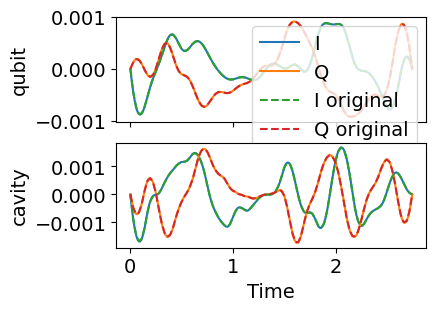

In [573]:
N_points = 100  # number of points of a pulse
nb_sample = None  # number of samples per wigner
n_generations = 100
n_repeat = 5  # number of times to repeat the optimization
N_amp = [2, 2]
N_phase = [1, 2]




env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ, 
    amplitude_bounds=amplitude_bounds,
    N_points=N_points,
    nb_sample=nb_sample,
    n_times = 400
)

# upsample to t_fine
IQ_fine = env.interpolate_IQ_pulse(pulse_IQ)
env.Iq = IQ_fine['Iq']
env.Qq = IQ_fine['Qq']
env.Ic = IQ_fine['Ic']
env.Qc = IQ_fine['Qc']
env.times = IQ_fine['times']

fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(env.times, env.Iq, label='I')
ax[0].plot(env.times, env.Qq, label='Q')
ax[0].plot(times, Iq, linestyle='--', label='I original')
ax[0].plot(times, Qq, linestyle='--', label='Q original')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(env.times, env.Ic, label='I')
ax[1].plot(env.times, env.Qc, label='Q')
ax[1].plot(times, Ic, linestyle='--', label='I original')
ax[1].plot(times, Qc, linestyle='--', label='Q original')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')



# create predistortion filters
filter_qubit = PredistortionFilter(N_amp=N_amp[0], N_phase=N_phase[0])
filter_cavity = PredistortionFilter(N_amp=N_amp[1], N_phase=N_phase[1])


# ------------------------
# Bounds and rescaling functions
# ------------------------
# bounds = [
#     (0.75, 1.25),  # amp_qubit0
#     (0.75, 1.25),  # amp_qubit1
#     (-0.15, 0.15), # phase_qubit0
#     (-0.15, 0.15), # phase_qubit1
#     (0.75, 1.25),  # amp_cavity0
#     (0.75, 1.25),  # amp_cavity1
#     (-0.15, 0.15), # phase_cavity0
#     (-0.15, 0.15), # phase_cavity1
#     (-50e-3, 50e-3)       # t_offset
# ]

# bounds = [
#     (0.75, 1.25),  # amp_qubit0
#     (0.75, 1.25),  # amp_qubit1
#     (0.75, 1.25),  # amp_cavity0
#     (0.75, 1.25),  # amp_cavity1
#     (-0.005, 0.005), # phase_cavity0
#     (-200, 200), # phase_cavity1
# ]

bounds = [
    (0.75, 1.25),  # amp_qubit0
    (-10, 10),  # amp_qubit1
    (-0.15, 0.15), # phase_qubit0
    (0.75, 1.25),  # amp_cavity0
    (-10, 10),  # amp_cavity1
    (-0.15, 0.15), # phase_cavity0
    (-50, 50), # phase_cavity1
#     (-50e-3, 50e-3)       # t_offset
]

# CMA-ES setup
# ------------------------
dim = len(bounds)
# x0 = cav.scale([1, 1, 1, 1, 0, 0], bounds)
x0 = cav.scale([1, 0, 0, 1, 0, 0, 0], bounds)
sigma0 = 0.2
popsize = 4

es = cma.CMAEvolutionStrategy(x0, sigma0, {"popsize": popsize})

fidelity_history = []
fidelity_avg_history = []
logger = es.logger  # attach the default logger

In [574]:
def objective(x_scaled, env, filter_qubit, filter_cavity, repeats=3):
    """
    CMA-ES objective function using rescaled parameters.
    Minimizes 1 - fidelity.
    """
    # Convert scaled [0,1] parameters to real values
    x = cav.unscale(x_scaled, bounds)
    print(f"Testing parameters: {x}")

    # Split x into filter coefficients and time offset
    # check if it has a length has attr or set to 0 if not
    idx = 0
    if filter_qubit.amp_coeffs is None:
        N_amp_q = 0
    else: 
        N_amp_q = len(filter_qubit.amp_coeffs)
        filter_qubit.amp_coeffs[:] = x[idx:idx+N_amp_q]; idx += N_amp_q

    if filter_qubit.phase_coeffs is None:
        N_phase_q = 0
    else:
        N_phase_q = len(filter_qubit.phase_coeffs)
        filter_qubit.phase_coeffs[:] = x[idx:idx+N_phase_q]; idx += N_phase_q
    if filter_cavity.amp_coeffs is None:
        N_amp_c = 0
    else:
        N_amp_c = len(filter_cavity.amp_coeffs)
        filter_cavity.amp_coeffs[:] = x[idx:idx+N_amp_c]; idx += N_amp_c
    if filter_cavity.phase_coeffs is None:
        N_phase_c = 0
    else:
        N_phase_c = len(filter_cavity.phase_coeffs)
        filter_cavity.phase_coeffs[:] = x[idx:idx+N_phase_c]; idx += N_phase_c

    rewards = []
    # Apply filters
    Iq_f, Qq_f = filter_qubit.apply(env.Iq, env.Qq, env.times*1e3)
    # Ic_f, Qc_f = filter_cavity.apply(env.Ic, env.Qc, env.times*1e3, t_offset=t_offset)
    Ic_f, Qc_f = filter_cavity.apply(env.Ic, env.Qc, env.times*1e3)

    pulse_IQ_test = {
        'Iq': Iq_f,
        'Qq': Qq_f,
        'Ic': Ic_f,
        'Qc': Qc_f,
        'times': env.times
    }
    fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
    ax[0].plot(env.times, Iq_f, label='I filtered')
    ax[0].plot(env.times, Qq_f, label='Q filtered')
    ax[0].plot(env.times, env.Iq, linestyle='--', label='I original')
    ax[0].plot(env.times, env.Qq, linestyle='--', label='Q original')
    ax[0].set_ylabel('qubit')
    ax[0].legend()
    ax[1].plot(env.times, Ic_f, label='I filtered')
    ax[1].plot(env.times, Qc_f, label='Q filtered')
    ax[1].plot(env.times, env.Ic, linestyle='--', label='I original')
    ax[1].plot(env.times, env.Qc, linestyle='--', label='Q original')
    ax[1].set_ylabel('cavity')

    gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(pulse_IQ=pulse_IQ_test)
    print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
    expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][0]= gain_qb
    expts_base_inst.config_thisrun.device.optimal_control[pulse_to_test[0][1]][pulse_to_test[0][2]]['gain'][1]= gain_cav
    qb_scale = max(np.max(np.abs(pulse_IQ_test['Iq'])), np.max(np.abs(pulse_IQ_test['Qq'])))
    cav_scale = max(np.max(np.abs(pulse_IQ_test['Ic'])), np.max(np.abs(pulse_IQ_test['Qc'])))
    if qb_scale !=0:
        pulse_IQ_test['Iq'] /= qb_scale
        pulse_IQ_test['Qq'] /= qb_scale
    if cav_scale !=0:
        pulse_IQ_test['Ic'] /= cav_scale
        pulse_IQ_test['Qc'] /= cav_scale


    IQ_table = {
        'I_c': pulse_IQ_test['Ic'],
        'Q_c': pulse_IQ_test['Qc'],
        'I_q': pulse_IQ_test['Iq'],
        'Q_q': pulse_IQ_test['Qq'],
        'times': pulse_IQ_test['times']
    }
    for _ in range(repeats):
        print(f"  Repeat {_+1}/{repeats} for action {idx+1}/{len(solutions)}")

        wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 250,
            displacement_path=return_dict['path'], #optimal displacement path
            prepulse=False,
            pre_sweep_pulse=None,
            gate_based = False,
            pulse_correction=False,
            relax_delay=2500, 
            # relax_delay=1000,
            # active_reset=True, 
            post_select_pre_pulse=False,
            IQ_table=IQ_table,
            opt_pulse=pulse_to_test
            )
        idx+=1
        
        wigner.analyze()
        wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                            mode_state_num=cutoff_cav, alphas = wigner.data['alpha'])
        results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                        initial_state=psi_target, rotate=False)

        fidelity = results['fidelity']
        print(f"    Fidelity: {fidelity:.4f}")
        reward = 1 - fidelity  # reward is 1 - fidelity to minimize
        fidelity_history.append(fidelity)
        rewards.append(reward)  # CMA-ES minimizes
    fidelity_avg = 1 - np.mean(rewards)
    fidelity_avg_history.append(fidelity_avg)

    return np.mean(rewards)

Generation 9/100


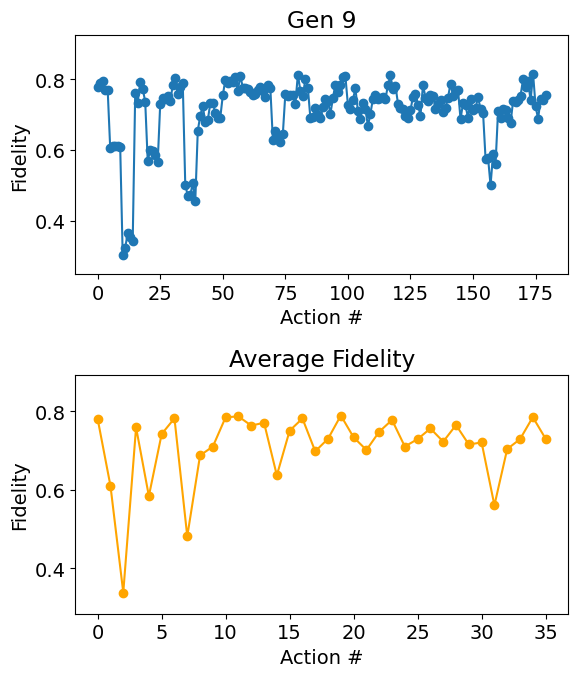

Testing parameters: [ 1.03146844e+00  9.56853571e+00  1.07030022e-01  1.06975821e+00
 -8.54573130e+00  1.75470887e-02 -2.14517172e+01]
Gain for qubit: 822, Gain for cavity: 1644
  Repeat 1/5 for action 8/4


  0%|          | 0/151 [00:00<?, ?it/s]

(250, 151)
(250, 151)
    Fidelity: 0.7538
  Repeat 2/5 for action 9/4


  0%|          | 0/151 [00:00<?, ?it/s]

(250, 151)
(250, 151)
    Fidelity: 0.7637
  Repeat 3/5 for action 10/4


  0%|          | 0/151 [00:00<?, ?it/s]

(250, 151)
(250, 151)
    Fidelity: 0.7296
  Repeat 4/5 for action 11/4


  0%|          | 0/151 [00:00<?, ?it/s]

(250, 151)
(250, 151)
    Fidelity: 0.7699
  Repeat 5/5 for action 12/4


  0%|          | 0/151 [00:00<?, ?it/s]

ConnectionClosedError: receiving: connection lost: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

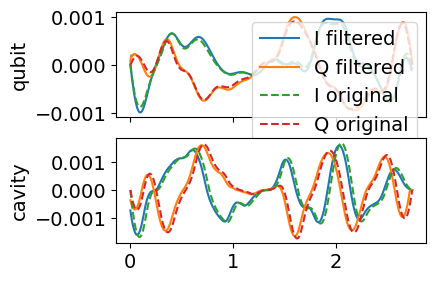

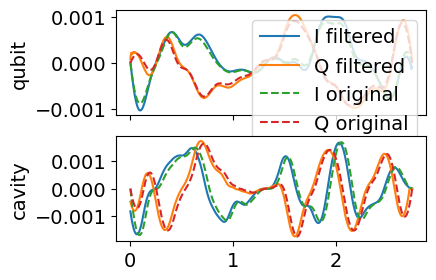

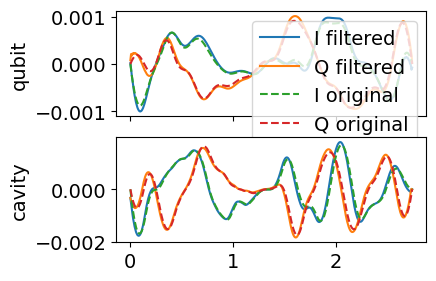

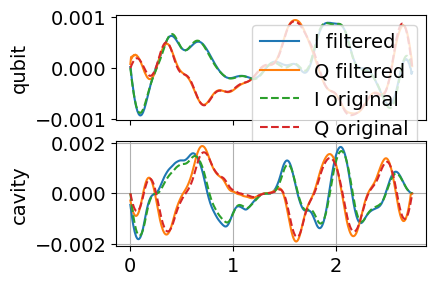

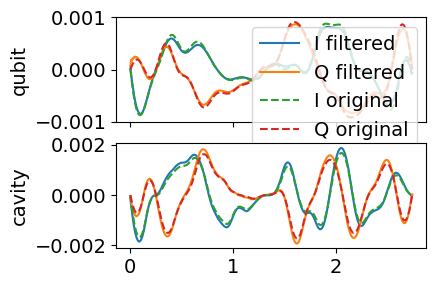

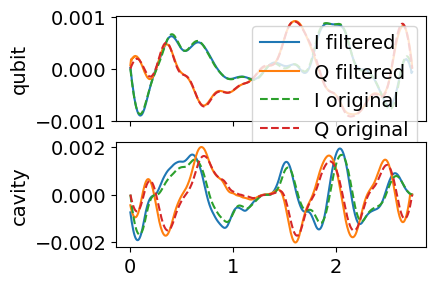

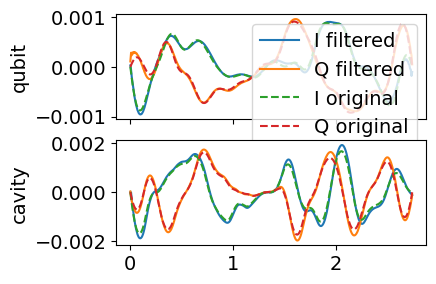

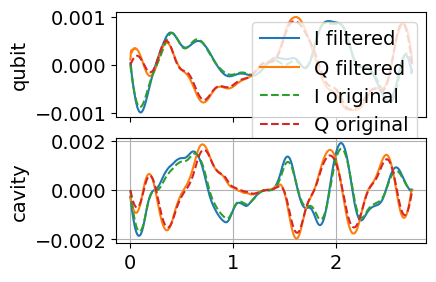

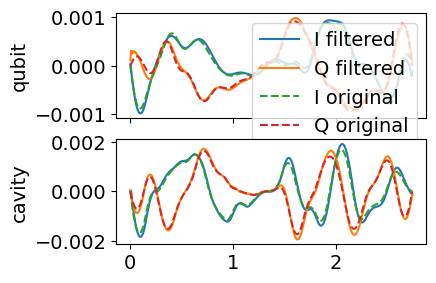

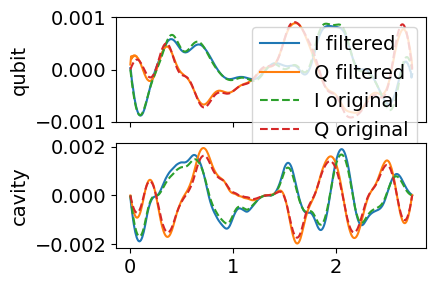

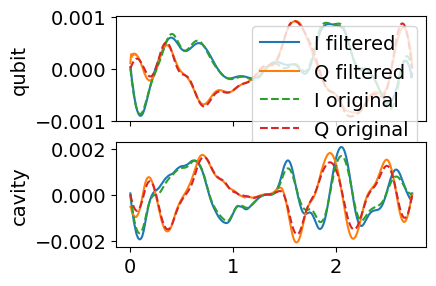

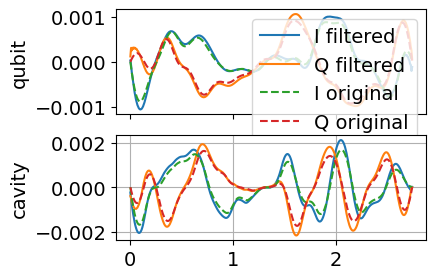

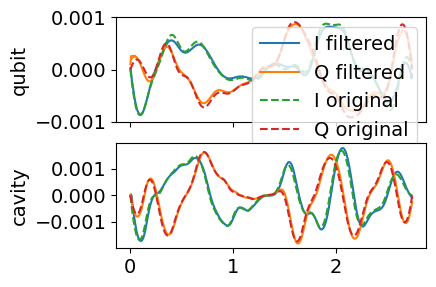

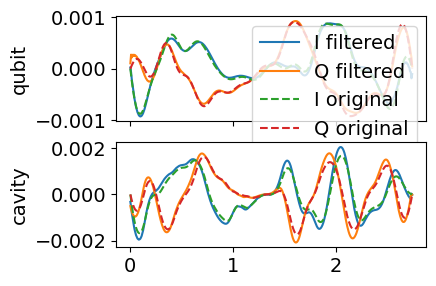

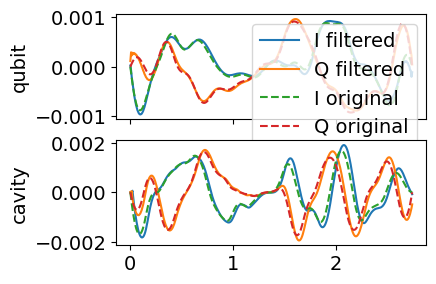

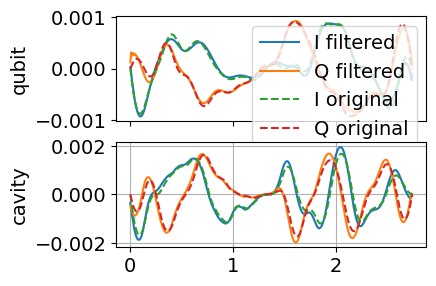

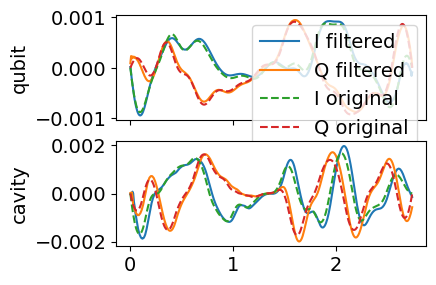

In [575]:
from IPython.display import clear_output
fig, ax = plt.subplots(2, 1, figsize=(6,7))
for gen in range(n_generations):

    if gen % 5 == 0:
    # rerun single shot calibration
        hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, active_reset=False,
                        prepulse=False,
                        gate_based=False,
                        check_f=False,
                        pre_sweep_pulse=prepulse_seq,
                        relax_delay = 2500)
        hstgrm[1].analyze(plot = False)
        update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)
        print('Single shot done!')

    solutions = es.ask()
    costs = [objective(x, env, filter_qubit, filter_cavity, repeats=n_repeat) for x in solutions]
    es.tell(solutions, costs)
    es.disp()
    logger.add()      # <-- log this generation
    logger.save()     # <-- save to outcmaes folder
    # --- clear notebook cell output ---
    clear_output(wait=True)
    print(f"Generation {gen+1}/{n_generations}")
    # print(f"Fidelity: {fidelity:.4f}, Reward: {reward:.4f}")

     # --- redraw plot ---
    ax[0].clear()
    ax[0].plot(fidelity_history, marker="o")

    ax[0].set_title(f"Gen {gen+1}")
    ax[0].set_xlabel("Action #")
    ax[0].set_ylabel("Fidelity")
    ylim = ax[0].get_ylim()
    ax[0].set_ylim(max(0, ylim[0]*0.9), min(1.1, ylim[1]*1.1))
    ax[1].clear()
    ax[1].plot(fidelity_avg_history, marker="o", color='orange')
    ax[1].set_title(f"Average Fidelity")
    ax[1].set_xlabel("Action #")    
    ax[1].set_ylabel("Fidelity")
    ylim = ax[1].get_ylim()
    ax[1].set_ylim(max(0, ylim[0]*0.9), min(1.1, ylim[1]*1.1))
    plt.grid(True)
    fig.tight_layout()
    display(fig)


        
        
        
        
    

Best solution (xbest): [ 1.04364388  6.22955798  0.05842893  1.04957931  1.46214421  0.03354775
 16.45552009]
Best fitness (fbest): 0.21062348029687472
Found at evaluation: 20


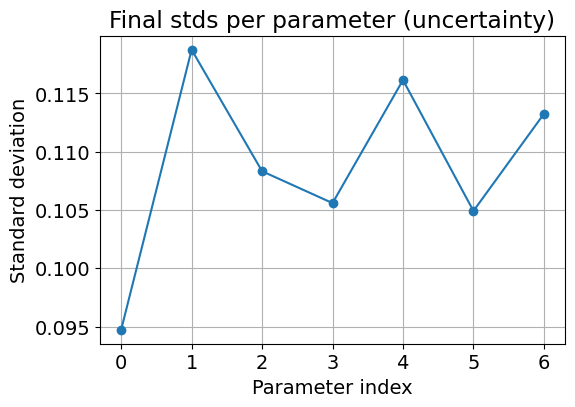

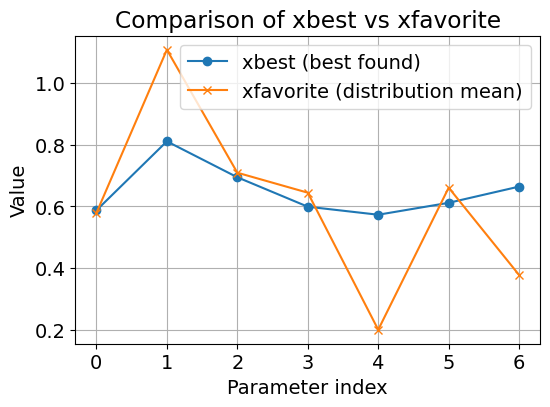

In [576]:
# Suppose `res` is your CMAEvolutionStrategyResult
res = es.result  # replace with your actual result

# --- 1. Best objective value ---
print("Best solution (xbest):", cav.unscale(res.xbest, bounds))
print("Best fitness (fbest):", res.fbest)
print("Found at evaluation:", res.evals_best)

# --- 2. Plot standard deviations (uncertainty per parameter) ---
plt.figure(figsize=(6,4))
plt.plot(res.stds, marker='o')
plt.title("Final stds per parameter (uncertainty)")
plt.xlabel("Parameter index")
plt.ylabel("Standard deviation")
plt.grid(True)
plt.show()

# --- 3. Compare xbest vs xfavorite ---
plt.figure(figsize=(6,4))
plt.plot(res.xbest, 'o-', label="xbest (best found)")
plt.plot(res.xfavorite, 'x-', label="xfavorite (distribution mean)")
plt.title("Comparison of xbest vs xfavorite")
plt.xlabel("Parameter index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Best parameters (real scale): [ 0.98406932  1.65413539  0.00914349  1.08835207  1.86407169  0.15376223
 -0.94706604]


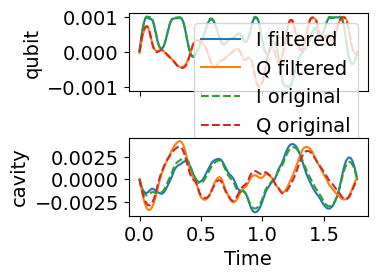

In [290]:
# save the best pulse
best_action = res.xbest

# generate the best pulse

action_real = cav.unscale(best_action, bounds)
print(f"Best parameters (real scale): {action_real}")
# Split x into filter coefficients and time offset
idx = 0
if filter_qubit.amp_coeffs is None:
    N_amp_q = 0
else: 
    N_amp_q = len(filter_qubit.amp_coeffs)
    filter_qubit.amp_coeffs[:] = action_real[idx:idx+N_amp_q]; idx += N_amp_q
if filter_qubit.phase_coeffs is None:
    N_phase_q = 0
else:
    N_phase_q = len(filter_qubit.phase_coeffs)
    filter_qubit.phase_coeffs[:] = action_real[idx:idx+N_phase_q]; idx += N_phase_q
if filter_cavity.amp_coeffs is None:
    N_amp_c = 0
else:
    N_amp_c = len(filter_cavity.amp_coeffs)
    filter_cavity.amp_coeffs[:] = action_real[idx:idx+N_amp_c]; idx += N_amp_c
if filter_cavity.phase_coeffs is None:
    N_phase_c = 0
else:
    N_phase_c = len(filter_cavity.phase_coeffs)
    filter_cavity.phase_coeffs[:] = action_real[idx:idx+N_phase_c]; idx += N_phase_c

# apply filters and save

Iq_f, Qq_f = filter_qubit.apply(env.Iq, env.Qq, env.times*1e3)
Ic_f, Qc_f = filter_cavity.apply(env.Ic, env.Qc, env.times*1e3)
pulse_IQ_updated = {
    'Iq': Iq_f,
    'Qq': Qq_f,
    'Ic': Ic_f,
    'Qc': Qc_f,
    'times': env.times
}

# plot and compare with original
fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(env.times, Iq_f, label='I filtered')
ax[0].plot(env.times, Qq_f, label='Q filtered')
ax[0].plot(env.times, env.Iq, linestyle='--', label='I original')
ax[0].plot(env.times, env.Qq, linestyle='--', label='Q original')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(env.times, Ic_f, label='I filtered')
ax[1].plot(env.times, Qc_f, label='Q filtered')
ax[1].plot(env.times, env.Ic, linestyle='--', label='I original')
ax[1].plot(env.times, env.Qc, linestyle='--', label='Q original')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
fig.tight_layout()



# # times = pulse_IQ['times']
# # pulse_IQ_updated = env.interpolate_IQ_pulse(env.generate_IQ_pulse(best_action)).values()

# # save to the pulse folder 

np.savez_compressed(filename.replace('.npz', '_optimized.npz'),
                    times=pulse_IQ_updated['times']*1e3, 
                    I_c=pulse_IQ_updated['Ic'],
                    Q_c=-pulse_IQ_updated['Qc'],
                    I_q=pulse_IQ_updated['Iq'],
                    Q_q=-pulse_IQ_updated['Qq']
                    )

## Transduction experiment

### Parameters

In [ ]:
cutoff = 8
eta_vec = np.linspace(0.1, 0.6, 15)
print(eta_vec)
theta_vec = np.arccos(np.sqrt(eta_vec))*2
ratio = theta_vec / np.pi
use_optimal_control = False

phase_corr = [0, 0, -127.27272727272728+10.90909090909091+5.4545454545454675
, -261.8181818181818+32.72727272727273+16.363636363636402]

# define pulses before wigner

prepulse_before = [[], [], [], []]
prepulse_after = [[], [], [], []]
# photon_list_pre = [1]
# prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list_pre, broadband=True)
# prep_man_pi.append(['storage', 'M1-S1', 'pi', 0])  # Add a pi pulse on storage after the prepulse
# photon_list = [0, 2]
# prep_man_bis = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=photon_list, broadband=True)
# for _pulse in prep_man_bis:
#     prep_man_pi.append(_pulse)
# print(f'Prepulse: {prep_man_pi}')
# pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()

### Prepare fock 1

In [ ]:
fock_list = [1]
prep_fock_1 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=fock_list, broadband=True)
for _pulse in prep_fock_1:
    for j in range(len(prepulse_before)):
        prepulse_before[j].append(_pulse)
        prepulse_after[j].append(_pulse)

for j in range(len(prepulse_before)):
    prepulse_before[j].append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse
    prepulse_after[j].append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse

### Prepare the cardinal states

In [ ]:
if not use_optimal_control:
    prep_2 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[2], broadband=True)
    prep_0_2 = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0, 2], broadband=True)
    prep_0_2j = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[0, 2j], broadband=True)
    prep_0_2[0][-1] = phase_corr[2]
    prep_0_2j[0][-1] = phase_corr[3]

    for _pulse in prep_2:
        prepulse_before[1].append(_pulse)
        prepulse_after[1].append(_pulse)
    for _pulse in prep_0_2:
        prepulse_before[2].append(_pulse)
        prepulse_after[2].append(_pulse)
    for _pulse in prep_0_2j:
        prepulse_before[3].append(_pulse)
        prepulse_after[3].append(_pulse)
else:
    prepulse_before[1].append(['optimal_control', 'fock', '2', [0, 0]])
    prepulse_after[1].append(['optimal_control', 'fock', '2', [0, 0]])
    prepulse_before[2].append(['optimal_control', 'fock', '0+2', [0, 0]])
    prepulse_after[2].append(['optimal_control', 'fock', '0+2', [0, 0]])
    prepulse_before[3].append(['optimal_control', 'fock', '0+2i', [0, 0]])
    prepulse_after[3].append(['optimal_control', 'fock', '0+2i', [0, 0]])
   

### add the swap we want to test

In [ ]:
for j in range(len(prepulse_before)):
    prepulse_after[j].append(['storage', 'M1-S3', 'pi', 0])  # Add a pi pulse on storage after the prepulse
    

### Measure the tomography before the swap test 

In [ ]:
state_labels = ['0', '2', '0_2', '0_2i']
initial_start_qt = [0 * qt.fock(cutoff, 0) for _ in range(len(state_labels))]
initial_states = [[0], [2], [0, 2], [0, 2j]]
for idx, photon_list in enumerate(initial_states):
    print(f'Initial state: {photon_list}')
    for i in photon_list:
        n = int(np.abs(i))  # photon number
        state = qt.fock(cutoff, n)
        coeff = i/np.abs(i) if np.abs(i) > 0 else 1
        initial_start_qt[idx] += coeff * state
    

In [ ]:
mm_base_calib.get_prepulse_creator(prepulse_before[2], cfg=expts_base_inst.config_thisrun).pulse.tolist()

In [ ]:
# for j in range(len(prepulse_before)):
wigner_data_before = []
for j in range(len(prepulse_before)):
# for j in [0]:
    prepulse = mm_base_calib.get_prepulse_creator(prepulse_before[j], cfg=expts_base_inst.config_thisrun).pulse.tolist()
    print(f'Prepulse {j}: {prepulse_before[j]}')
    wigner = do_wigner_tomography_1mode(
        config_thisrun=expts_base_inst.config_thisrun,
        expt_path=expts_base_inst.expt_path,
        config_path=expts_base_inst.config_file,
        displace_length=0.05,
        reps = 250,
        displacement_path=return_dict['path'], #optimal displacement path
        prepulse=True,
        pre_sweep_pulse=prepulse,
        gate_based = False,
        pulse_correction=True,
        relax_delay=7000, 
        post_select_pre_pulse=False,
    )
    wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                      mode_state_num=10, alphas = wigner.data['alpha'])
    results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                       initial_state=initial_start_qt[j], rotate=True)
    # add the the keys of results to wigner.data
    for key in results:
        if key != 'wigner_analysis':
            wigner.data[key] = results[key].full() if isinstance(results[key], qt.Qobj) else results[key]
    
    wigner.save_data()
    fig = wigner_analysis.plot_wigner_reconstruction_results(results, 
                                                             initial_state=initial_start_qt[j],
                                                               state_label = state_labels[j] + ' initial')
    wigner_data_before.append(wigner.data)
    

### For the 4 cardinal states measure the tomography versus eta 

In [ ]:
wigner_data_after = [[], [], [], []]
# for j in tqdm(range(2,len(prepulse_after))):
for j in tqdm(range(0,2)):
    prepulse = mm_base_calib.get_prepulse_creator(prepulse_after[j], cfg=expts_base_inst.config_thisrun).pulse.tolist()
    print(f'Prepulse {j}: {prepulse}')
    pulse_length = prepulse[2][-1]
    for r in range(len(ratio)):
    # update the pulse length 
        prepulse[2][-1] = pulse_length*ratio[r]
        print(prepulse[2][-1])
        wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 250,
            displacement_path=return_dict['path'], #optimal displacement path
            prepulse=True,
            pre_sweep_pulse=prepulse,
            gate_based = False,
            pulse_correction=True,
            relax_delay=7000, 
            post_select_pre_pulse=False,
        )
        wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg,
                                          mode_state_num=8, alphas = wigner.data['alpha'])
        results = wigner_analysis.wigner_analysis_results(wigner.data['parity'],
                                                           initial_state=initial_start_qt[j], rotate=True)
        # add the the keys of results to wigner.data
        for key in results:
            if key != 'wigner_analysis':
                wigner.data[key] = results[key].full() if isinstance(results[key], qt.Qobj) else results[key]

        wigner.data['pulse_length'] = prepulse[2][-1]
        wigner.data['eta'] = eta_vec[r]
        # wigner.data['state_label'] = np.array([state_labels[j]])
        
        
        wigner.save_data()
        fig = wigner_analysis.plot_wigner_reconstruction_results(results,
                                                                    initial_state=initial_start_qt[j],
                                                                    state_label = state_labels[j] + f' final r={ratio[r]:.2f}')
        wigner_data_after[j].append(wigner.data)
        


## Swap against fidelity

In [ ]:
## Checking code
# stor = 7 #storage number from 1
# fock_n = 5 #fock numbers from 0
# swap_iter = 6 #even swaps from 0
# swaps_plot = [2*i for i in range(swap_iter)]


# for k in range(stor): #storage number
#     fock_dict = {"fock_"+str(fock_n): [] for fock_n in range(fock_n)}

#     for j in range(fock_n): #fock states 0 to 4
#         photon = j
#         fid_results = []
        
#         for i in range(swap_iter): #even no. of swaps from 0 to 10
#             swaps = 2*i
#             fid_results += [swaps+j+k]

#         print(f'Fidelity-swap results for fock ' +str(j) + ' in storage ' + str(k+1) + ':')
#         print(fid_results)
#         print(swaps_plot)
#         fock_dict['fock_'+str(j)].append(fid_results)

#     print(f'Storage {k+1} swap fidelity results:')
#     print(fock_dict)
#     plt.figure(figsize=(10, 6))    
#     for l in range(fock_n):
#         fock_i = fock_dict['fock_'+str(l)][0]
#         plt.plot(swaps_plot, fock_i, marker='o', label='Fock ' + str(fock_n))
#     # plt.plot(indices, fock_0, marker='o', label='Fock 0')
#     plt.xlabel('Number of Swaps')
#     plt.ylabel('Fidelity')
#     plt.title(f'Fidelity vs Number of Swaps for Fock ' + str(j) + ' in Storage ' + str(k+1))
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

Gain for qubit: 850, Gain for cavity: 7213
doing 0 swaps for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.7410089282301159
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00978_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.7410')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_14-41-43_GKP_after_0_swaps.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
doing 2 swaps for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.6568817763273174
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00979_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.6569')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_14-58-27_GKP_after_2_swaps.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
doing 4 swaps for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.4902144374544171
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00980_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4902')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_15-15-23_GKP_after_4_swaps.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
doing 6 swaps for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.4028180413039157
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00981_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4028')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_15-32-37_GKP_after_6_swaps.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
doing 8 swaps for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.43608921347791174
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00982_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4361')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_15-49-54_GKP_after_8_swaps.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
Fidelity-swap results for GKP in storage 1:
[0.7410089282301159, 0.6568817763273174, 0.4902144374544171, 0.4028180413039157, 0.43608921347791174]
[0, 2, 4, 6, 8]
Storage 1 swap fidelity results:


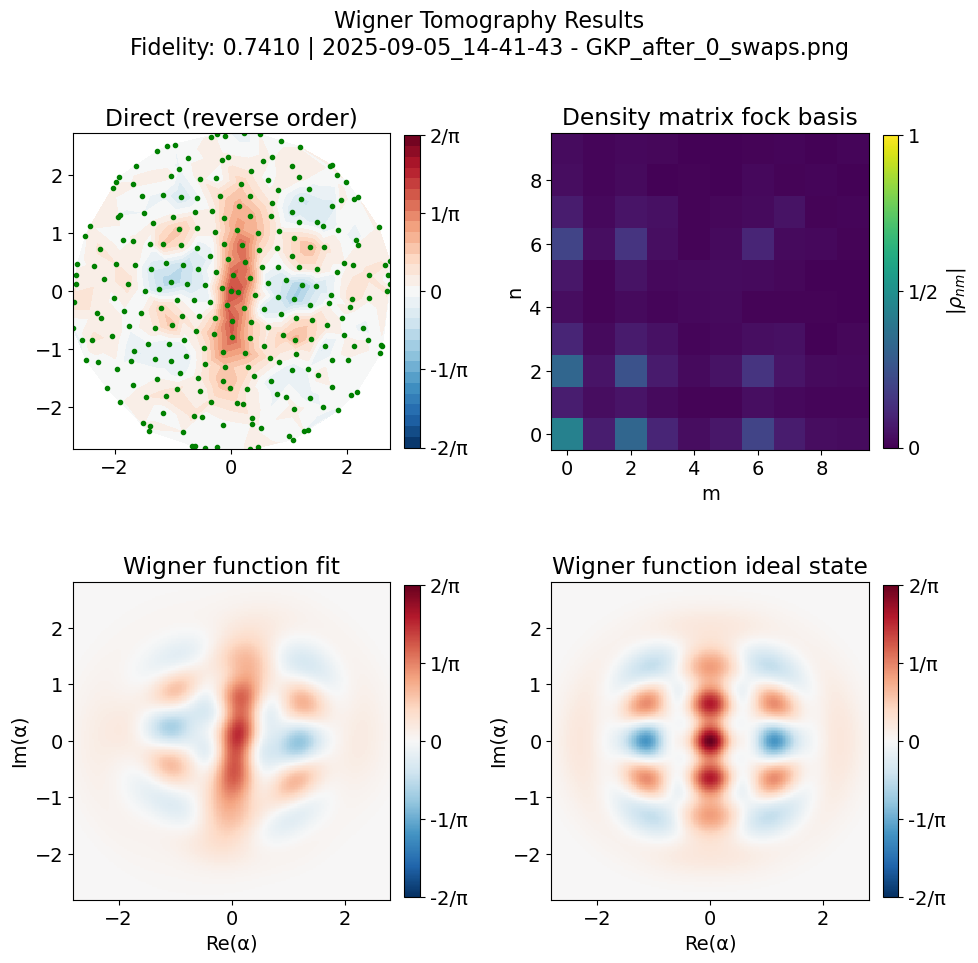

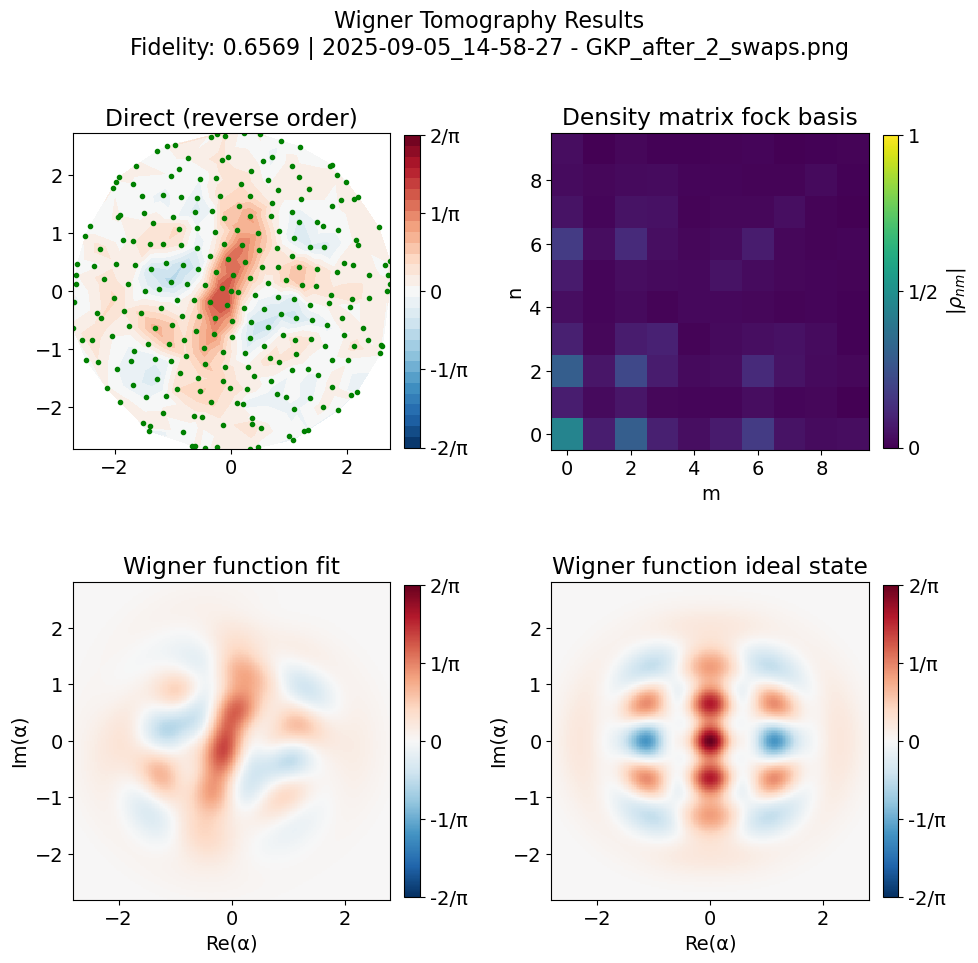

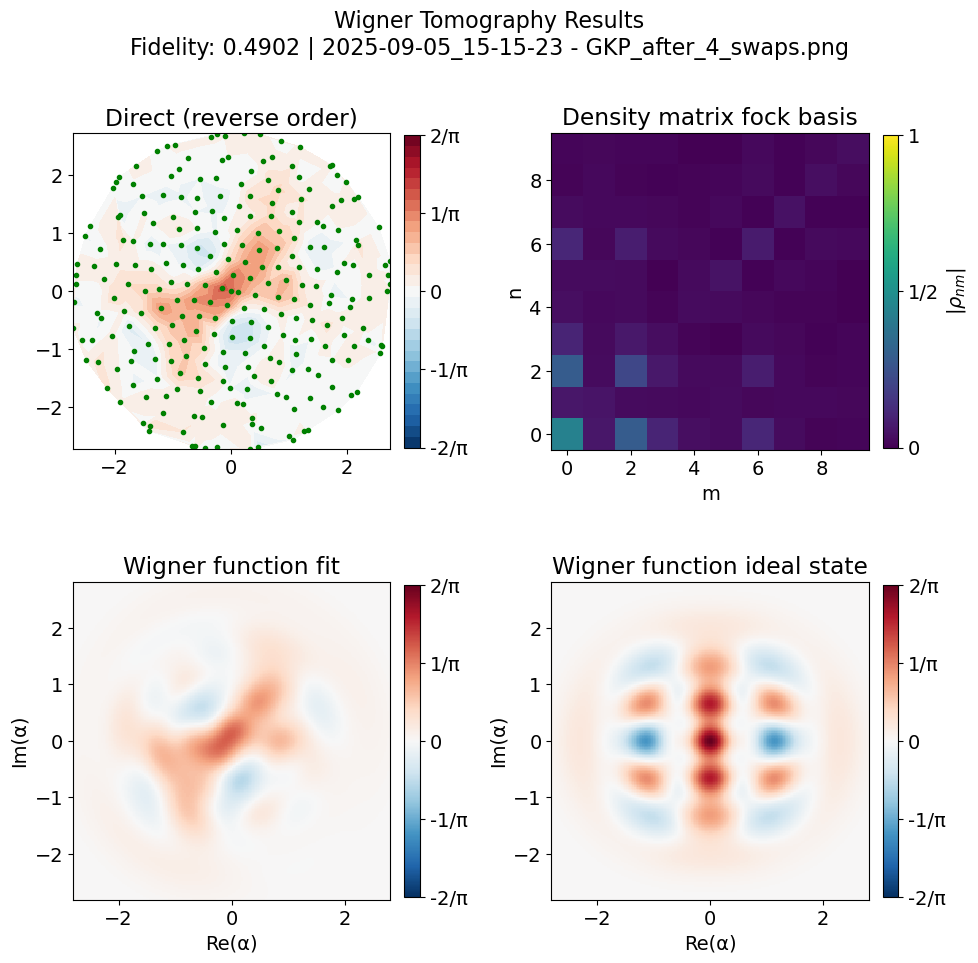

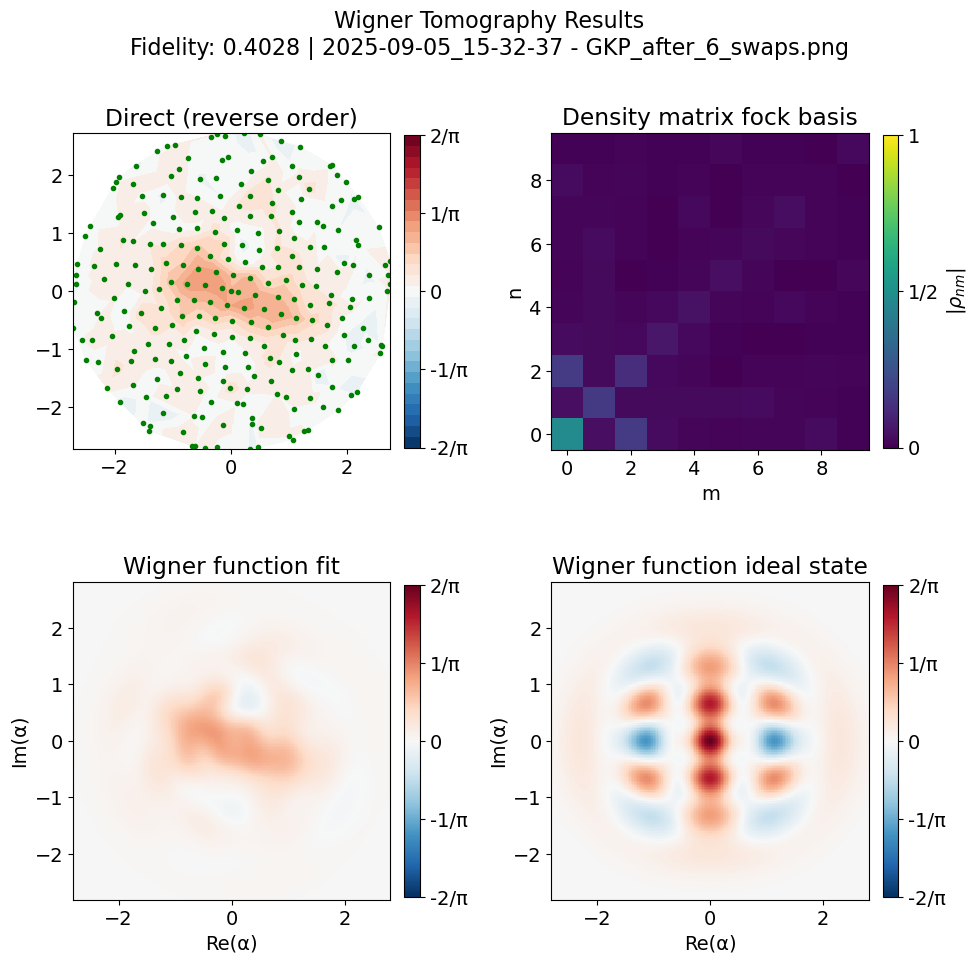

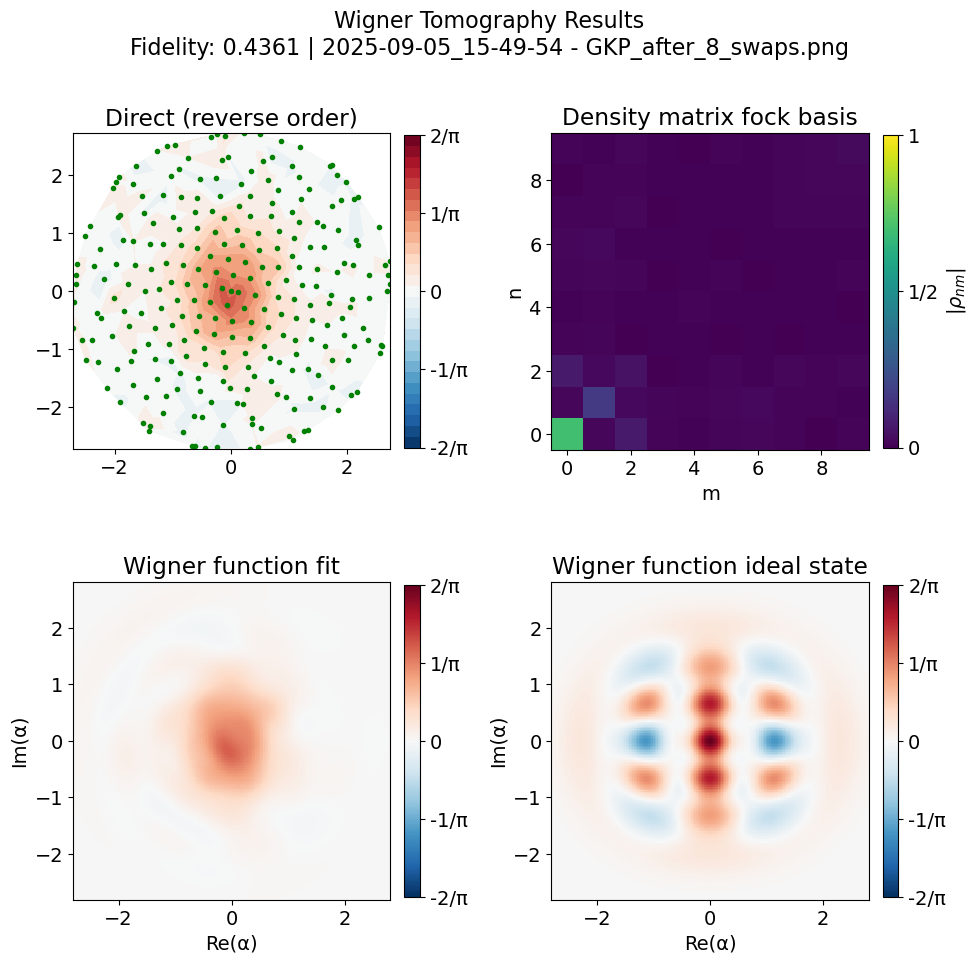

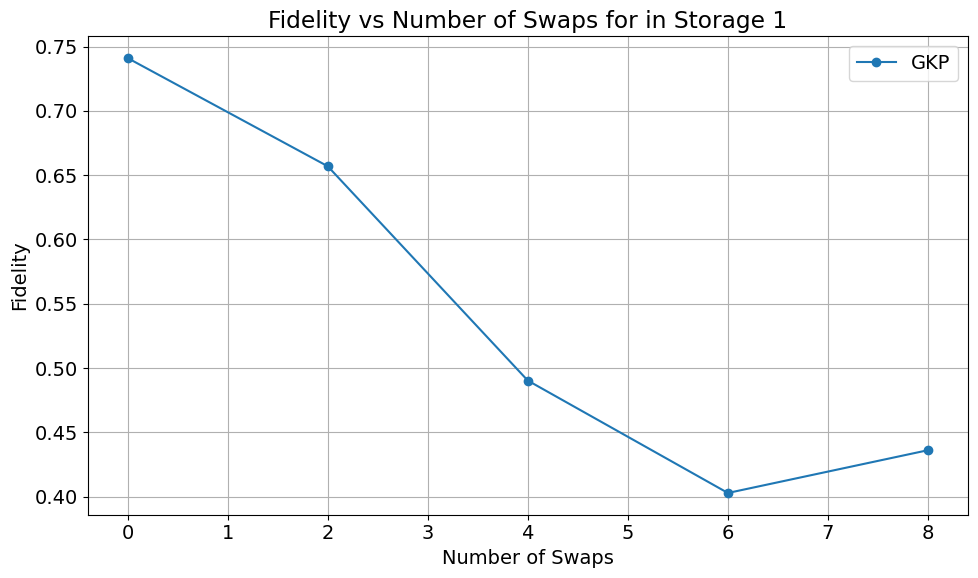

In [755]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

stor = 1 #storage number from 1
# fock_n = 5 #fock numbers from 0
swap_iter = 5 #even swaps from 0
swaps_plot = [2*i for i in range(swap_iter)]

prepulse = [
            ['optimal_control', 'test', '2', [0, 0]], 
            ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav

wigner_swap_fid_data = []

for k in range(stor): #storage number
    fid_results = []
            
    for i in range(swap_iter): #even no. of swaps from 0 to 10
        swaps = 2*i
        prep_man_pi = prepulse
        for s in range(swaps):
            prep_man_pi.append(['storage', 'M1-S'+str(k+1), 'pi', 0])  
        pulse = mm_base_calib.get_prepulse_creator(prep_man_pi, cfg=expts_base_inst.config_thisrun).pulse.tolist()
        print(f'doing ' + str(swaps) + ' swaps for GKP in storage ' + str(k+1))

        wigner = do_wigner_tomography_1mode(
            config_thisrun=expts_base_inst.config_thisrun,
            expt_path=expts_base_inst.expt_path,
            config_path=expts_base_inst.config_file,
            displace_length=0.05,
            reps = 250,
            displacement_path=return_dict['path'],
            prepulse=True,
            pre_sweep_pulse=pulse,
            gate_based = False,
            # relax_delay=8000
            relax_delay=5000,
            pulse_correction=True
        )

        wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
        initial_state = get_hex_GKP(0.408,2,wigner_analysis.m)
        # allocated_counts = wigner_analysis.bin_ss_data()
        # p_e = allocated_counts # Probability of measuring the state |e
        # p_g = 1 - allocated_counts  # Probability of measuring the state |g
        results = wigner_analysis.wigner_analysis_results(wigner.data['parity'], initial_state=initial_state, rotate=True)
        print(results['fidelity'])
        fid_results += [results['fidelity']]
        wigner.save_data()
        wigner_swap_fid_data.append(wigner.data)
        fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = f'GKP after {swaps} swaps')
    
    print(f'Fidelity-swap results for GKP in storage ' + str(k+1) + ':')
    print(fid_results)
    print(swaps_plot)

    print(f'Storage {k+1} swap fidelity results:')
    plt.figure(figsize=(10, 6))    
    plt.plot(swaps_plot, fid_results, marker='o', label='GKP')
    plt.xlabel('Number of Swaps')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # filename = title.replace(' ', '_').replace(':', '') + '.png'
    # self.save_plot(fig, filename=filename)

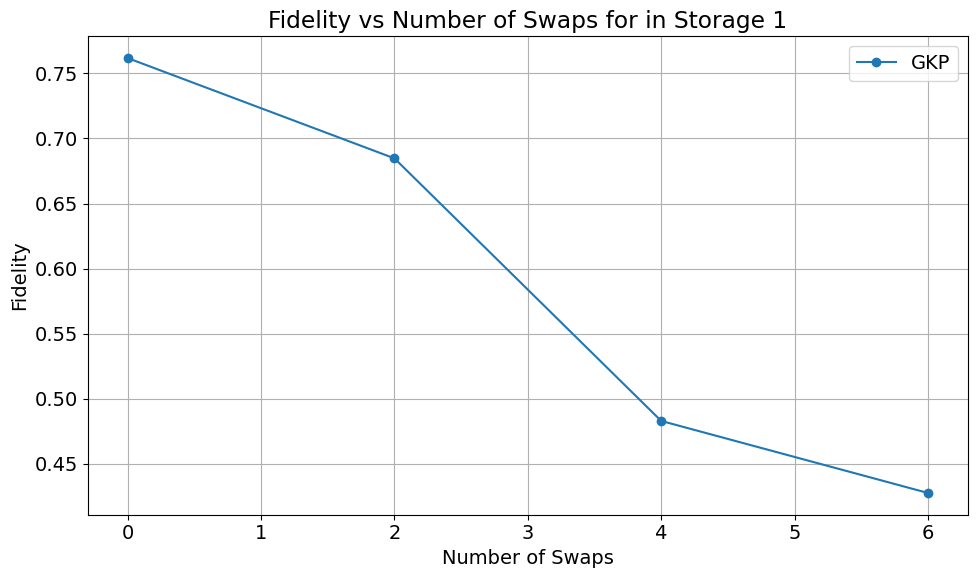

In [687]:
plt.plot(swaps_plot, fid_results, marker='o', label='GKP')
plt.xlabel('Number of Swaps')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4275')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-04_14-47-34_.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-04.md


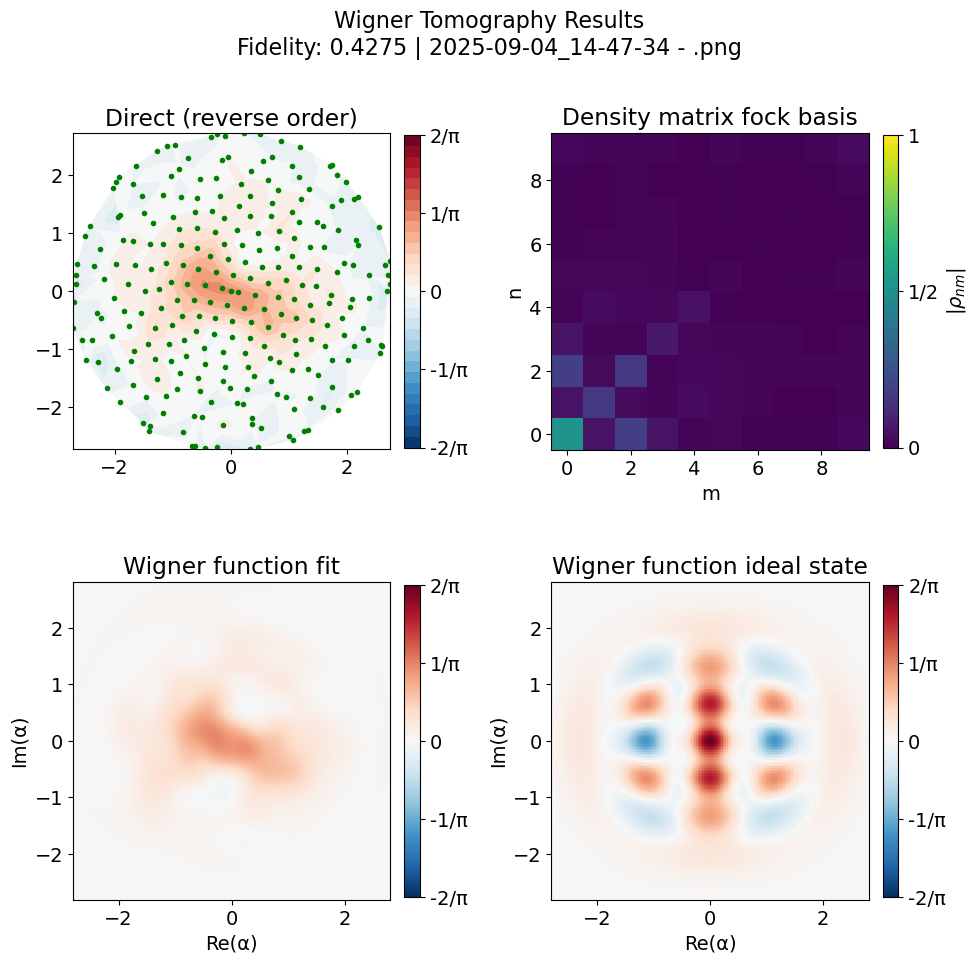

In [ ]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

stor = 7 #storage number from 1
fock_n = 5 #fock numbers from 0
swap_iter = 6 #even swaps from 0
swaps_plot = [2*i for i in range(swap_iter)]

for k in range(stor): #storage number
    fock_dict = {"fock_"+str(fock_n): [] for fock_n in range(fock_n)}

    for j in range(fock_n): #fock states 0 to 4
        photon = j
        fid_results = []
        
        for i in range(swap_iter): #even no. of swaps from 0 to 10
            swaps = 2*i
            prep_man_pi = mm_base_calib.prep_man_photon(man_no=1, photon_no=photon)
            for s in range(swaps):
                prep_man_pi.append(['storage', 'M1-S'+str(k+1), 'pi', 0])  


            pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
            print(f'doing ' + str(swaps) + ' swaps for fock ' + str(photon) + ' in storage ' + str(k+1))
            wigner = do_wigner_tomography_1mode(
                config_thisrun=expts_base_inst.config_thisrun,
                expt_path=expts_base_inst.expt_path,
                config_path=expts_base_inst.config_file,
                displace_length=0.05,
                reps = 1000,
                displacement_path=return_dict['path'],
                prepulse=True,
                pre_sweep_pulse=pulse,
                gate_based = False,
                # relax_delay=8000
                relax_delay=5000
            )

            wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
            initial_state = (fock(wigner_analysis.m, photon)).unit() 
            allocated_counts = wigner_analysis.bin_ss_data()
            p_e = allocated_counts # Probability of measuring the state |e
            p_g = 1 - allocated_counts  # Probability of measuring the state |g
            plt.plot(np.abs(wigner.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')
            results = wigner_analysis.wigner_analysis_results((p_g-p_e), initial_state=initial_state, rotate=True)
            print(results['fidelity'])
            fid_results += [results['fidelity']]
            

        print(f'Fidelity-swap results for fock ' +str(j) + ' in storage ' + str(k+1) + ':')
        print(fid_results)
        print(swaps_plot)
        fock_dict['fock_'+str(j)].append(fid_results)

    print(f'Storage {k+1} swap fidelity results:')
    print(fock_dict)
    plt.figure(figsize=(10, 6))    
    for l in range(fock_n):
        fock_i = fock_dict['fock_'+str(l)][0]
        plt.plot(swaps_plot, fock_i, marker='o', label='Fock ' + str(l))
    plt.xlabel('Number of Swaps')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # filename = title.replace(' ', '_').replace(':', '') + '.png'
    # self.save_plot(fig, filename=filename)

## GKP T1

In [708]:
prepulse = [
            ['optimal_control', 'test', '2', [0, 0]], 
            ]
prep_man_pi = prepulse
prep_man_pi.append(['wait', '700', '', ''])
pulse = mm_base_calib.get_prepulse_creator(prep_man_pi, cfg=expts_base_inst.config_thisrun).pulse.tolist()

print(prep_man_pi)
print(pulse)

[['optimal_control', 'test', '2', [0, 0]], ['wait', '700', '', '']]
[[3571.6994214615424, 4984.779973902164, 4984.779973902164], [850, 7213, 0], [0, 0, 700.0], [0.0, 0.0, 0.0], [2, 3, 3], [['opt_cont', 'test', '2'], ['opt_cont', 'test', '2'], 'const'], [0, 0, 0]]


Gain for qubit: 850, Gain for cavity: 7213
wating 30 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.5398231623953127
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00966_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.5398')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_10-52-04_GKP_after_30_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 60 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.4295759718999858
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00967_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4296')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_11-09-09_GKP_after_60_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 90 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.31406985977973917
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00968_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3141')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_11-26-32_GKP_after_90_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 120 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.34481326189320666
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00969_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3448')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_11-44-08_GKP_after_120_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 150 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.3151247474296892
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00970_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3151')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_12-02-07_GKP_after_150_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 180 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.33089457873534867
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00971_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3309')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_12-20-40_GKP_after_180_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 210 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.33975205309579454
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00972_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3398')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_12-39-52_GKP_after_210_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 240 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.3565403824141126
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00973_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3565')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_12-59-19_GKP_after_240_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 270 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.3930947266860987
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00974_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.3931')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_13-19-34_GKP_after_270_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 300 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.40135530506116746
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00975_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4014')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_13-40-34_GKP_after_300_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 330 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.4375086483781074
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00976_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4375')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_14-02-15_GKP_after_330_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
wating 360 us for GKP in storage 1


  0%|          | 0/261 [00:00<?, ?it/s]

(250, 261)
(250, 261)
0.4496897249571141
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00977_WignerTomography1ModeExperiment.h5
supertitle is  Text(0.5, 0.98, 'Wigner Tomography Results\nFidelity: 0.4497')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-09-05_14-24-49_GKP_after_360_us.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-09-05.md
GKP T1 results: 
[0.5398231623953127, 0.4295759718999858, 0.31406985977973917, 0.34481326189320666, 0.3151247474296892, 0.33089457873534867, 0.33975205309579454, 0.3565403824141126, 0.3930947266860987, 0.40135530506116746, 0.4375086483781074, 0.4496897249571141]
[ 30  60  90 120 150 180 210 240 270 300 330 360]


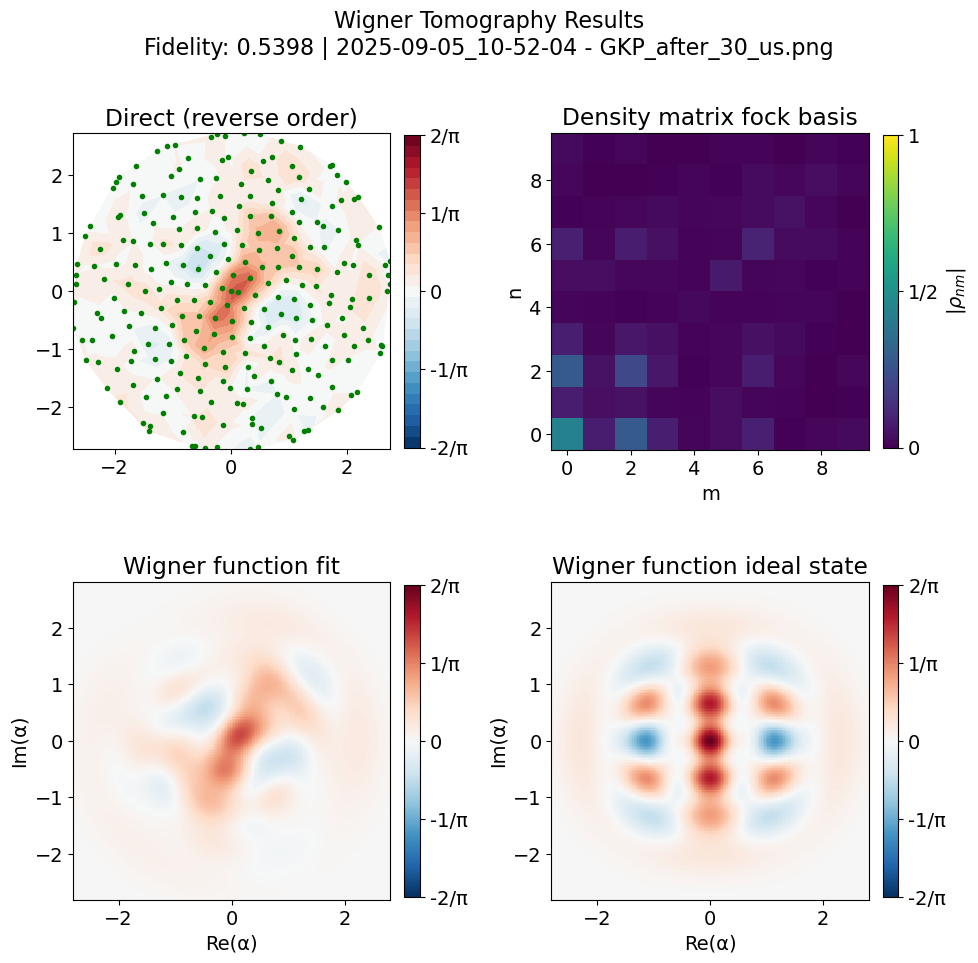

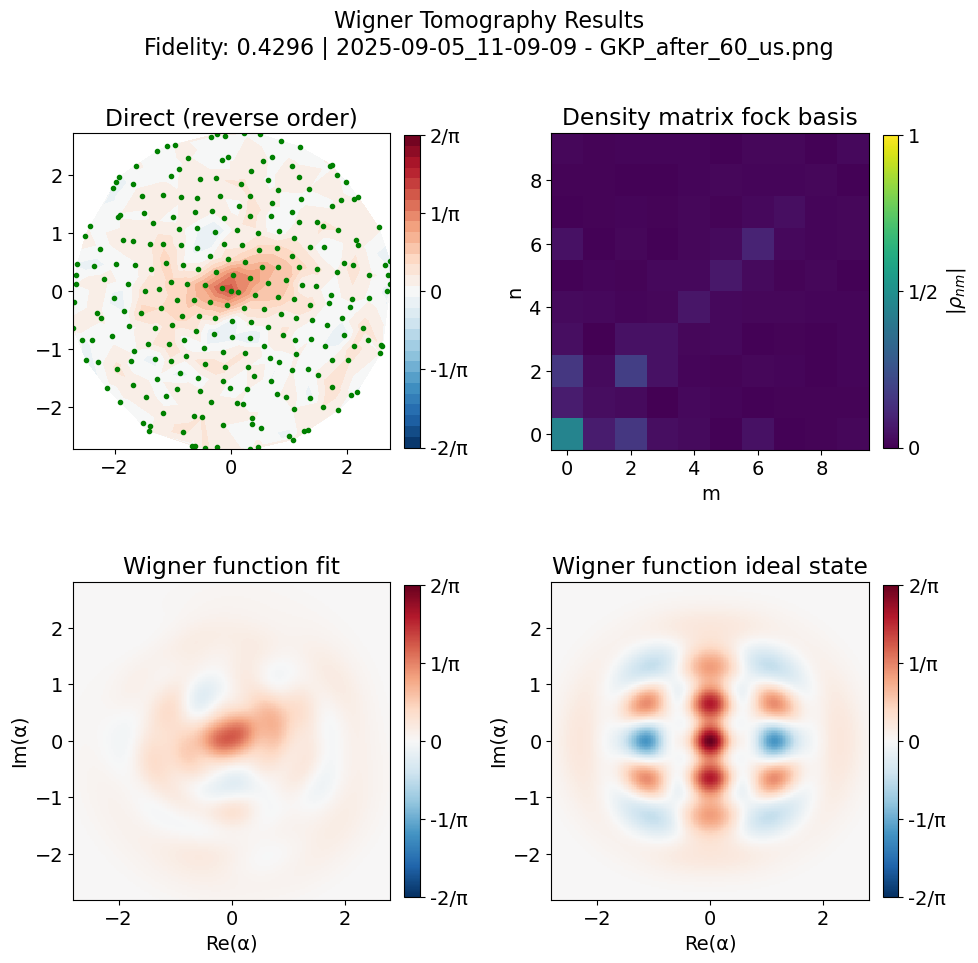

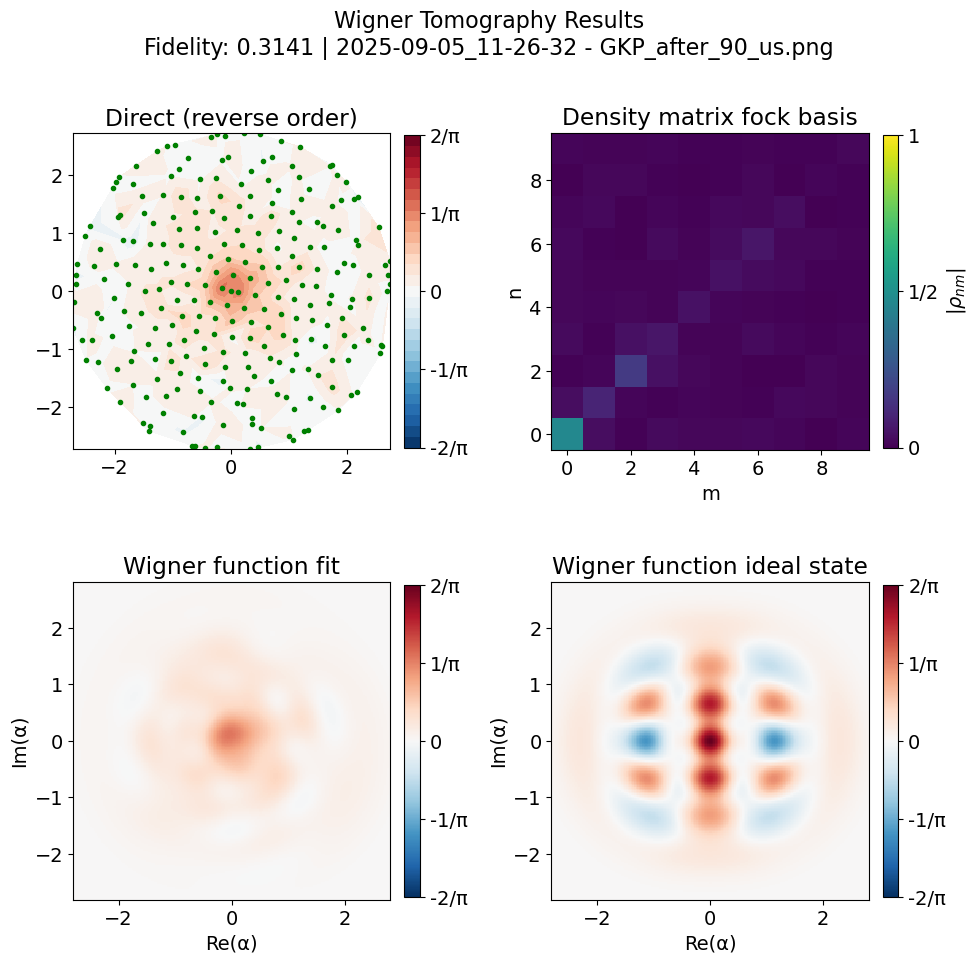

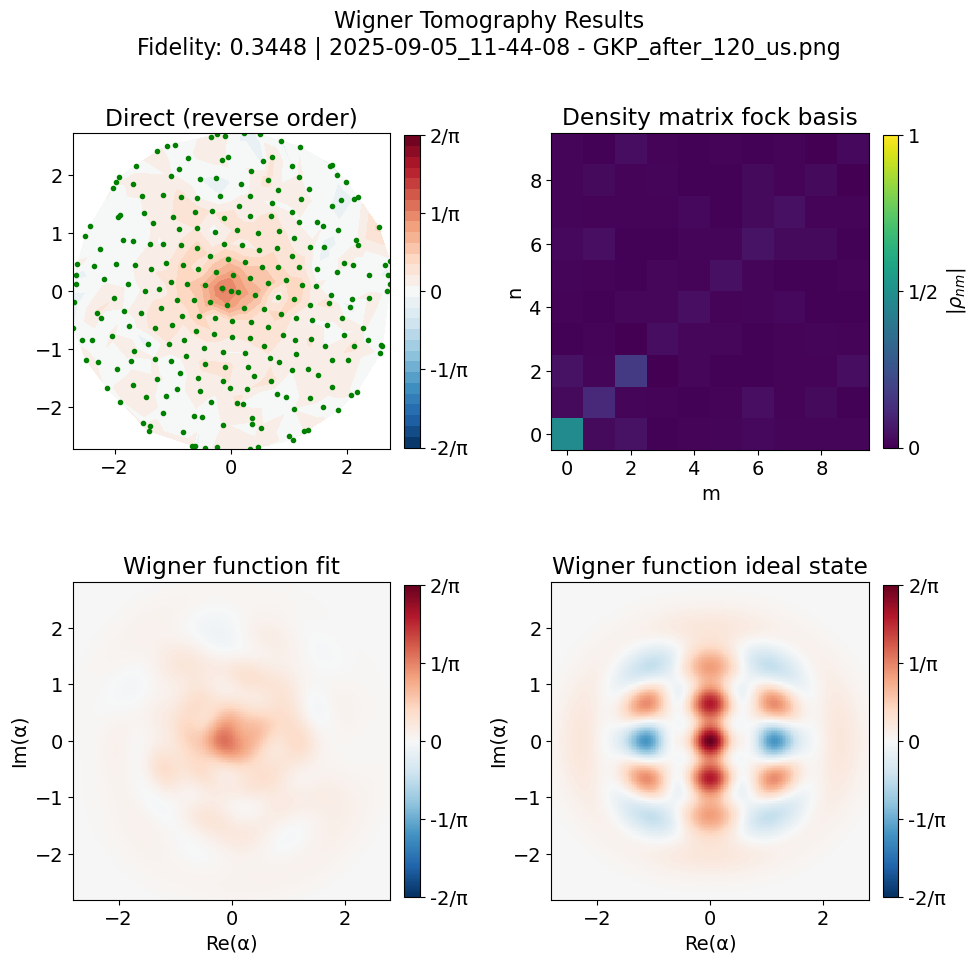

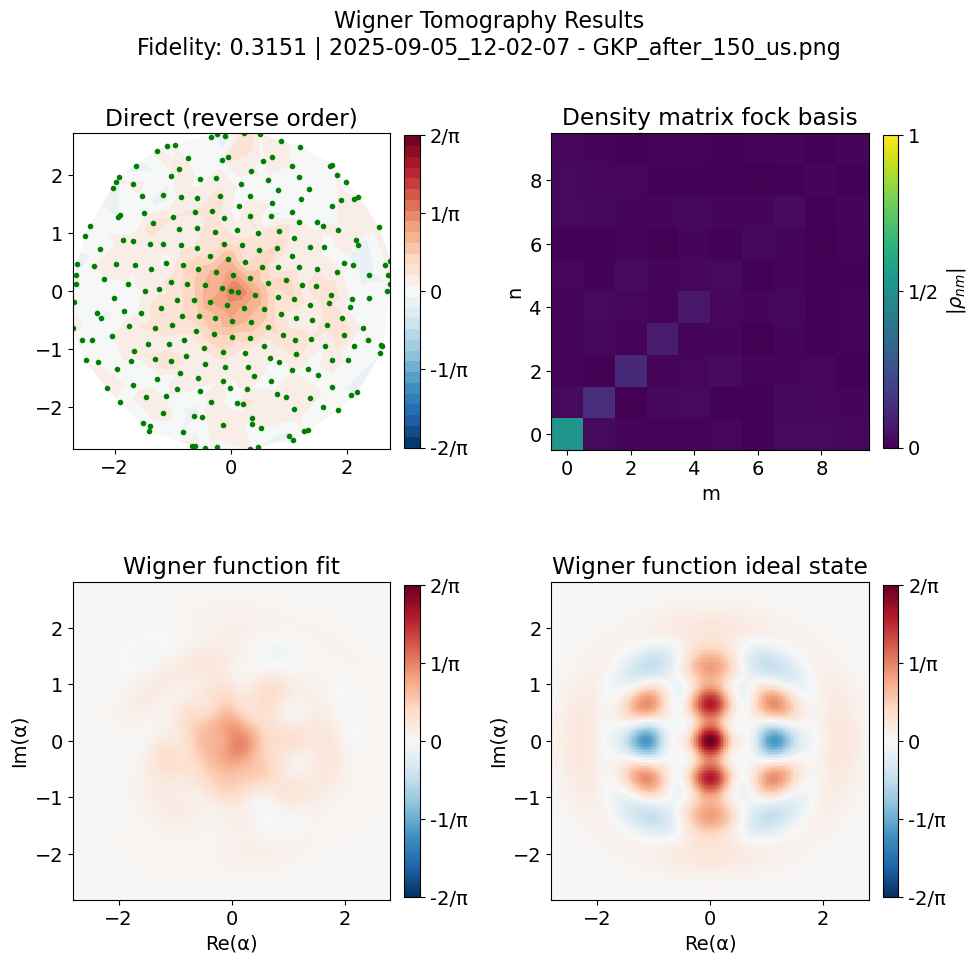

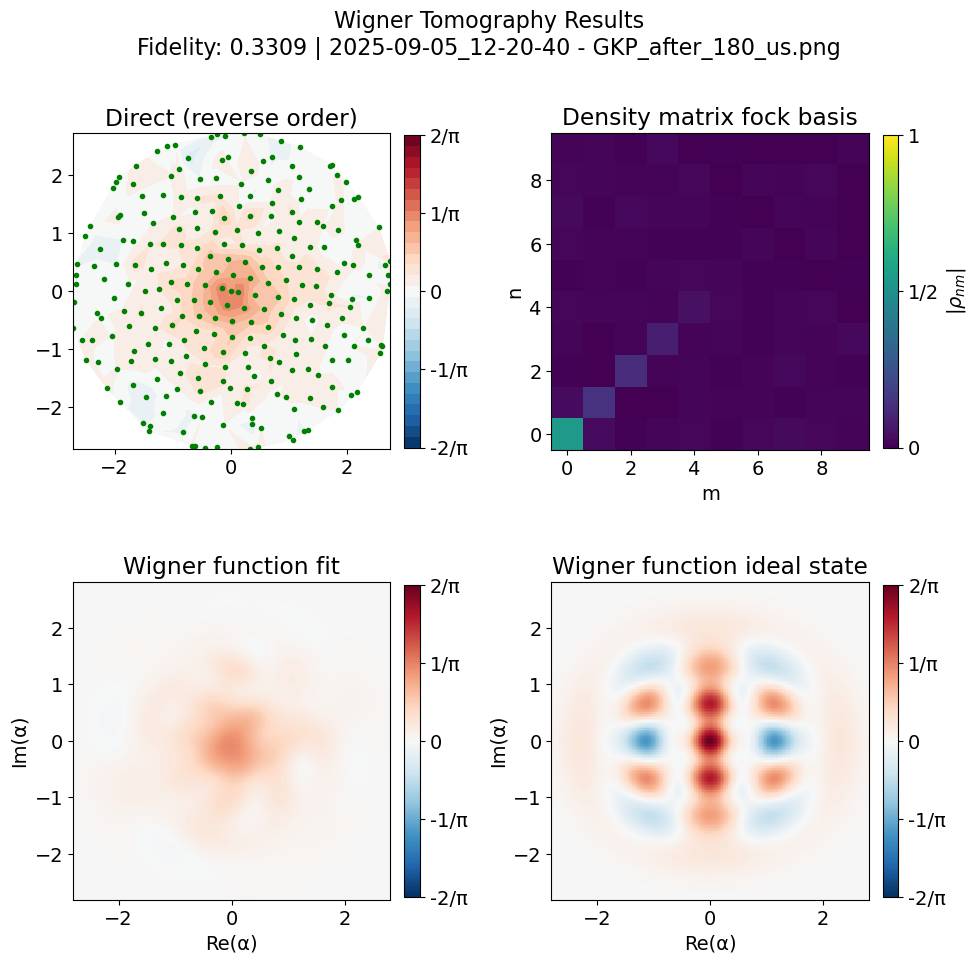

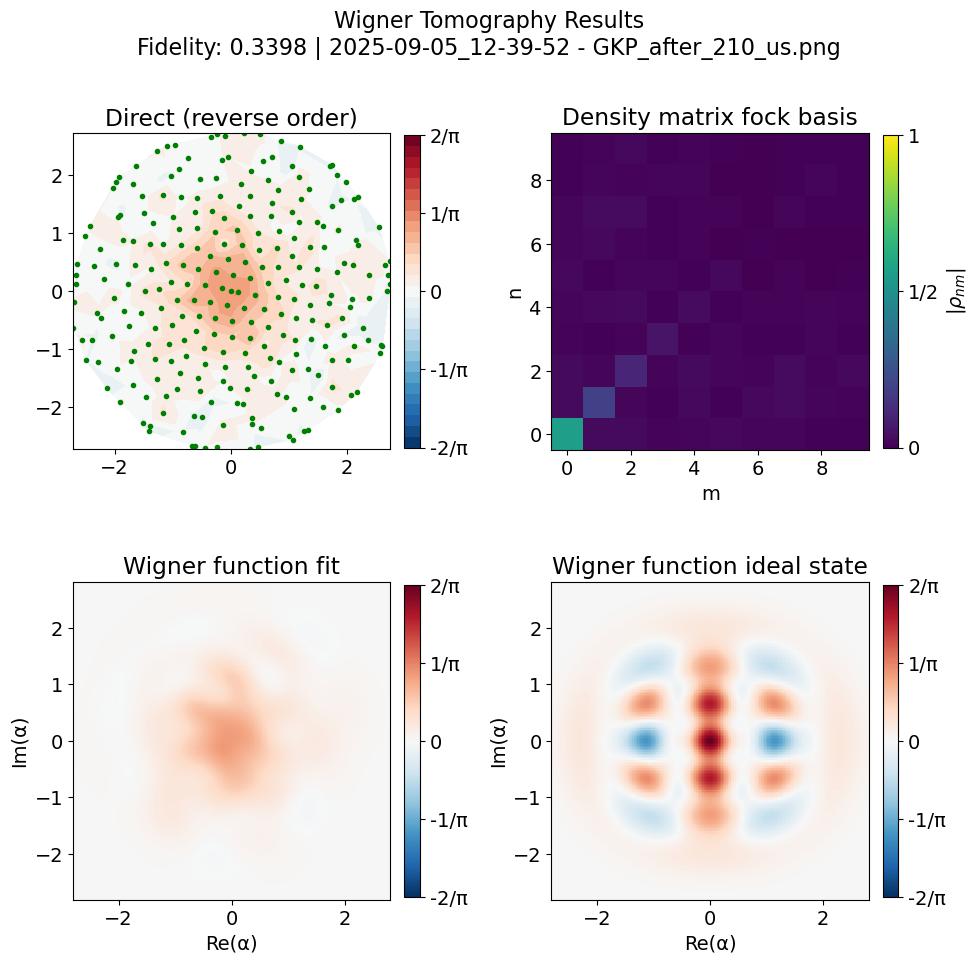

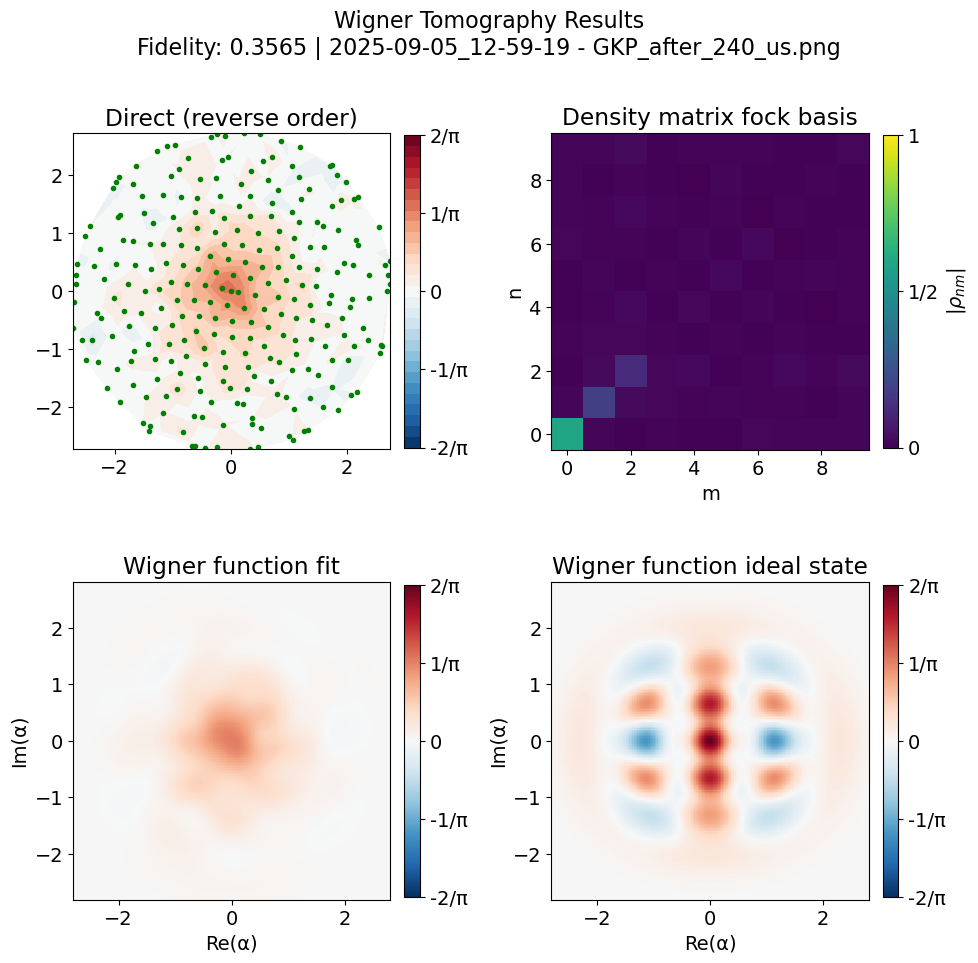

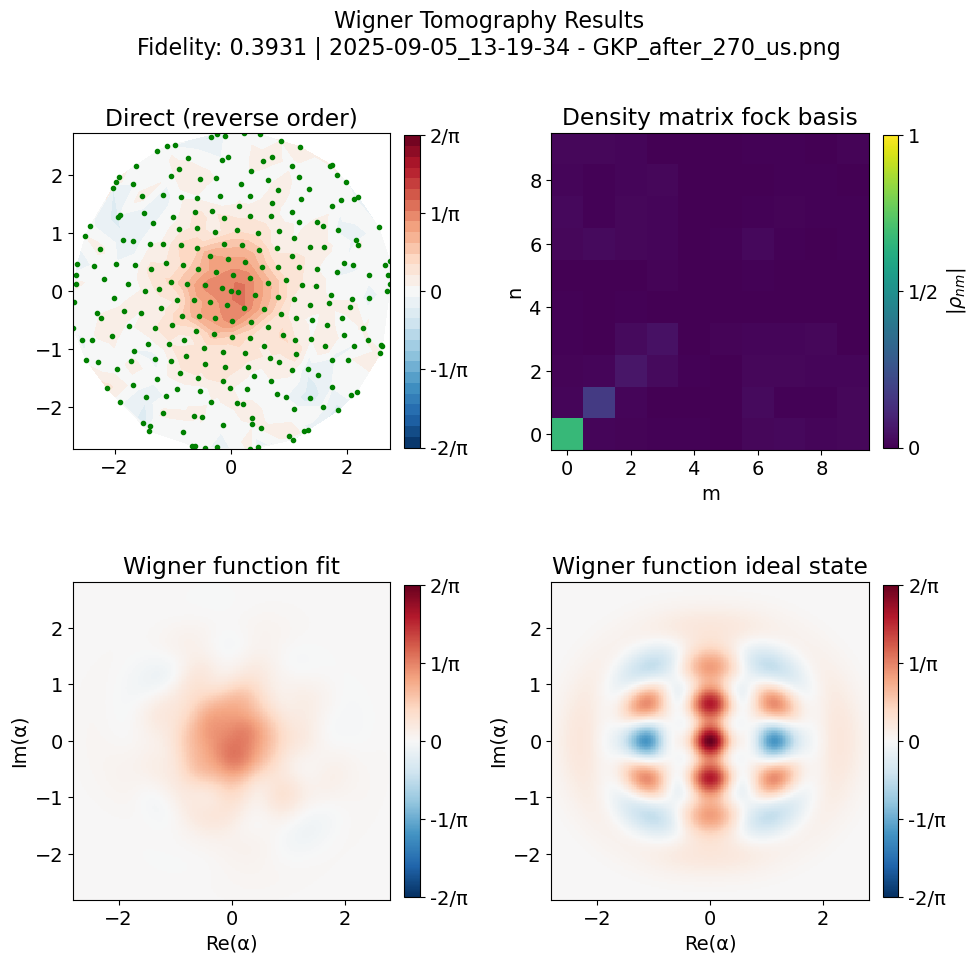

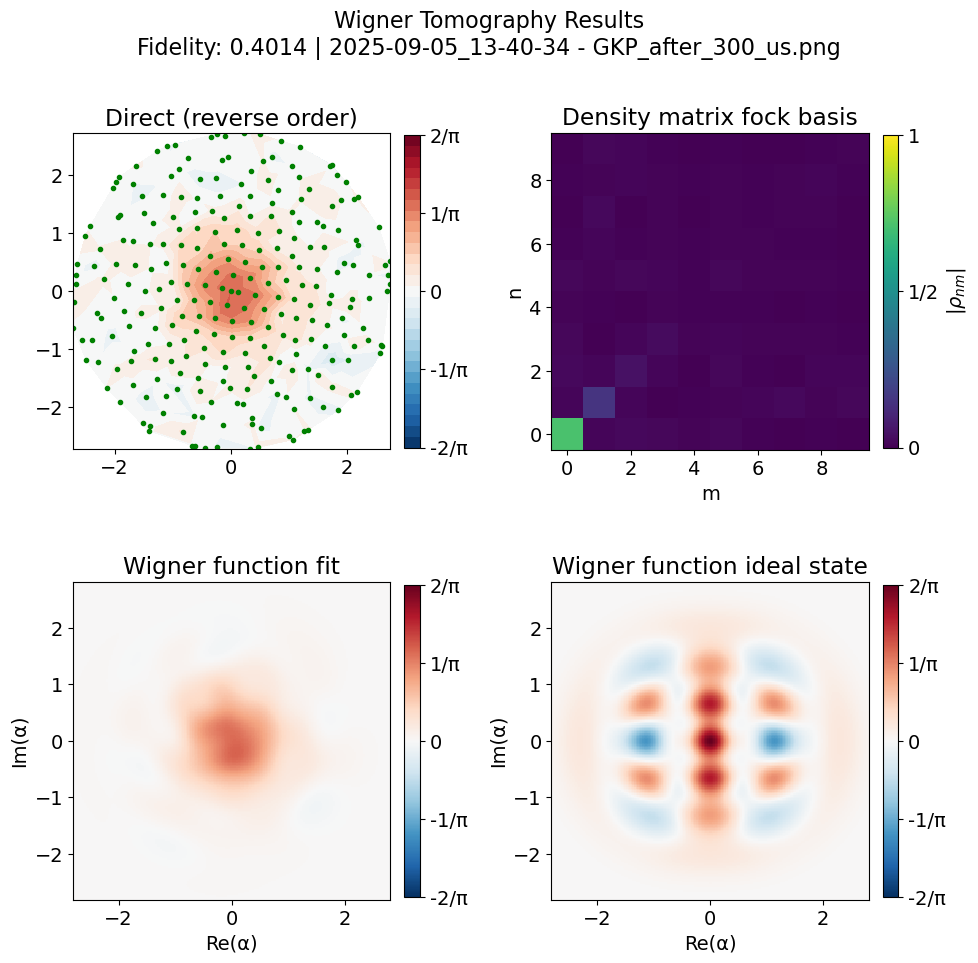

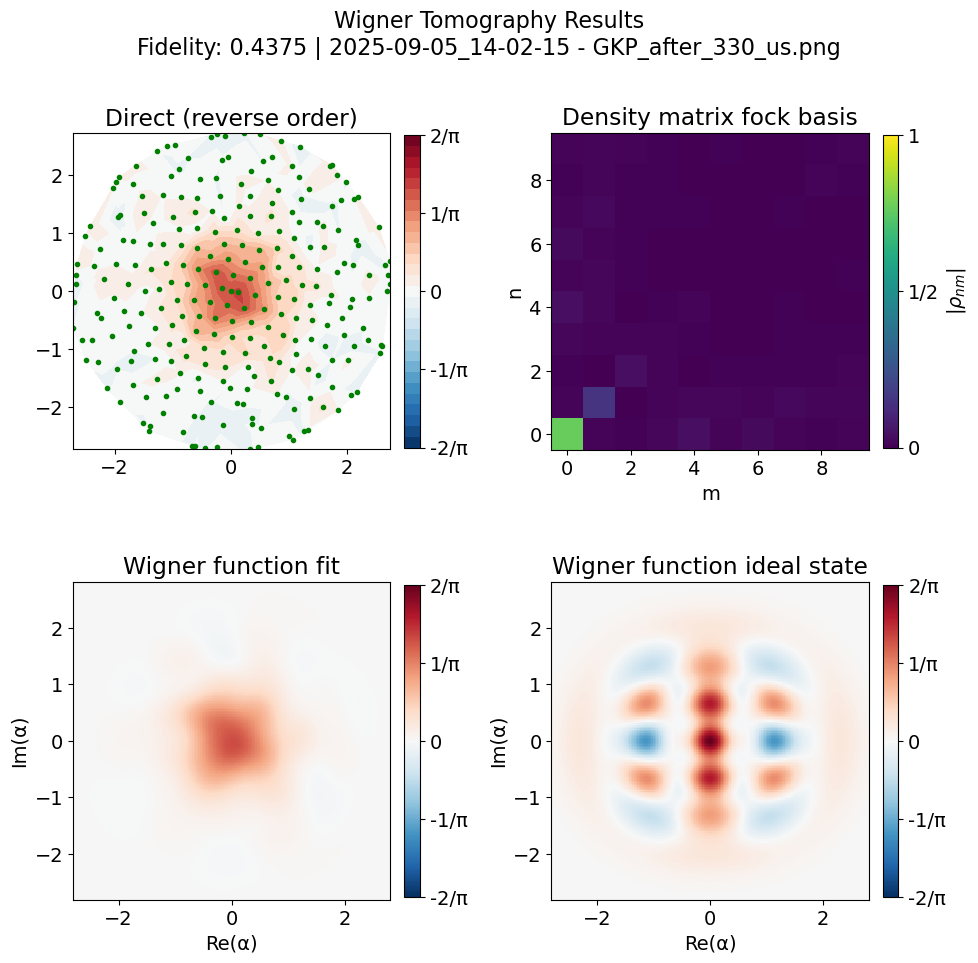

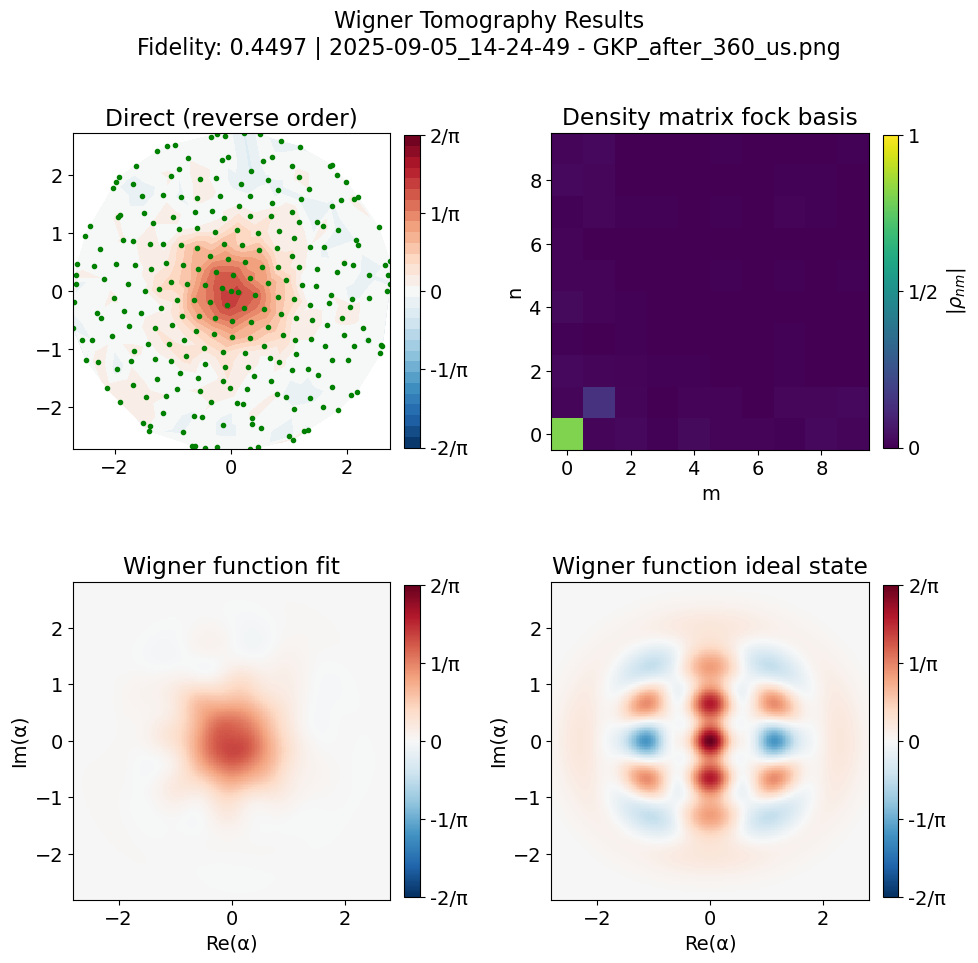

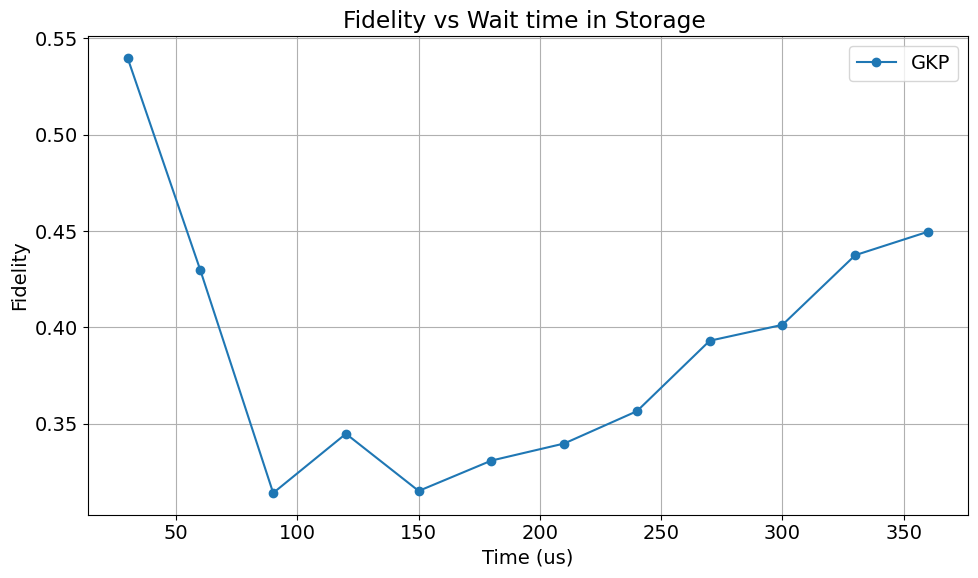

In [754]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

s = 12
interval = 30
time = interval*np.linspace(1,s,s).astype(int)

prepulse = [
            ['optimal_control', 'test', '2', [0, 0]], 
            ]
gain_qb, gain_cav = mm_base_calib.get_gain_optimal_pulse(prepulse[0])
print(f'Gain for qubit: {gain_qb}, Gain for cavity: {gain_cav}')
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][0]= gain_qb
expts_base_inst.config_thisrun.device.optimal_control[prepulse[0][1]][prepulse[0][2]]['gain'][1]= gain_cav

wigner_gkp_t1_data = []
fid_T1_results = []
        
for t in range(s): 
    prep_man_pi = prepulse
    prep_man_pi.append(['storage', 'M1-S1', 'pi', 0])  
    for r in range(t+1):
        prep_man_pi.append(['wait', str(interval), '', ''])
        print("adding wait of " + str(interval) + " us")
    prep_man_pi.append(['storage', 'M1-S1', 'pi', 0])  

    pulse = mm_base_calib.get_prepulse_creator(prep_man_pi, cfg=expts_base_inst.config_thisrun).pulse.tolist()
    print(f'wating {interval*(t)} us for GKP in storage 1')

    wigner = do_wigner_tomography_1mode(
        config_thisrun=expts_base_inst.config_thisrun,
        expt_path=expts_base_inst.expt_path,
        config_path=expts_base_inst.config_file,
        displace_length=0.05,
        reps = 250,
        displacement_path=return_dict['path'],
        prepulse=True,
        pre_sweep_pulse=pulse,
        gate_based = False,
        # relax_delay=8000
        relax_delay=5000,
        pulse_correction=True
    )

    wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
    initial_state = get_hex_GKP(0.408,2,wigner_analysis.m)
    # allocated_counts = wigner_analysis.bin_ss_data()
    # p_e = allocated_counts # Probability of measuring the state |e
    # p_g = 1 - allocated_counts  # Probability of measuring the state |g
    results = wigner_analysis.wigner_analysis_results(wigner.data['parity'], initial_state=initial_state, rotate=True)
    print(results['fidelity'])
    fid_T1_results += [results['fidelity']]
    wigner.save_data()
    wigner_gkp_t1_data.append(wigner.data)
    fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = f'GKP after {interval*(t+1)} us')

print(f'GKP T1 results: ')
print(fid_T1_results)
print(time)
plt.figure(figsize=(10, 6))    
plt.plot(time, fid_T1_results, marker='o', label='GKP')
plt.xlabel('Time (us)')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs Wait time in Storage ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename = title.replace(' ', '_').replace(':', '') + '.png'
# self.save_plot(fig, filename=filename)

In [752]:
fid_results

[0.4190491519562153,
 0.33781767076938884,
 0.3313391653246507,
 0.36405843569473917,
 0.3851809157913467]

In [753]:
wigner_gkp_t1_data

[{'alpha': array([ 0.        +0.j        , -0.130822  +0.00952409j,
         -0.49388095-2.70244987j, -2.16034996-0.88013478j,
         -1.36410832+1.84229095j, -2.69473922+0.00609732j,
         -1.6542622 +0.59390643j, -0.33223659+2.72778125j,
         -1.17920566-1.19002299j, -0.33785249+0.80695318j,
          0.25920899-0.32489686j,  0.87624112+1.41554455j,
          1.09099244-2.49729258j,  1.16169734-0.80097565j,
         -2.02359765+1.18674335j,  2.67202417-0.12064862j,
          2.28216736+1.21567109j, -1.07600502+2.55834372j,
         -2.70792697-0.27513174j,  2.3506835 -0.43716547j,
         -2.66047022-0.44771373j, -2.61071564+0.94572154j,
          1.4601525 +1.81769904j, -0.82294136-1.04176305j,
          0.83105383+2.42445156j, -0.54333928-0.41778632j,
          1.67389754+1.03399315j,  1.68003859-1.84394541j,
         -0.64690139+0.61301909j, -0.95493019-0.18205588j,
         -0.33619754-1.29159683j,  0.18965758-1.6408228j ,
          1.5017548 -1.34261893j,  0.53301758-1

## Wigner Tomography of |0+2>

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_02_pulse = []
prep_02_pulse.append(['qubit', 'ge', 'hpi', 0]) # g0 + e0 
prep_02_pulse.append(['qubit', 'ef', 'pi', 0]) # g0 + f0 
prep_02_pulse.append(['qubit', 'ge', 'pi', 0])# e0 + f0
prep_02_pulse.append(['multiphoton', 'f0-g1', 'pi', 0]) # e0 + g1 
prep_02_pulse.append(['multiphoton', 'g0-e0', 'pi', 0]) # g0 + e1
prep_02_pulse.append(['multiphoton', 'e1-f1', 'pi', 0]) # g0 + f1 
prep_02_pulse.append(['multiphoton', 'f1-g2', 'pi', 0]) # g0 + g2
prep_02_pulse
## convert it to low level pulse 
pulse_02 = mm_base_dummy.get_prepulse_creator(prep_02_pulse).pulse.tolist()
pulse_02

## Wigner Tomography of |0> + |1>

### Debugging

##### Histogram Prepulse

In [ ]:
def do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    preloaded_pulses=False,
    use_arb_waveform=False,
    expts_base_inst=None,
    expt_path=None,
    config_path=None,
    config_thisrun=None,
    relax_delay=2500
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubits': qubits,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'preloaded_pulses': preloaded_pulses,
        'use_arb_waveform': use_arb_waveform
    }
    histogram_exp = expts_base_inst.meas.single_qubit.single_shot_prepulse.HistogramPrepulseExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='HistogramPrepulseExperiment', config_file=config_path
    )
    histogram_exp.cfg = AttrDict(deepcopy(config_thisrun))
    histogram_exp.cfg.expt = expt_cfg
    histogram_exp.go(analyze=False, display=False, progress=True, save=True)
    return histogram_exp


In [ ]:
historgam_exp = do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    expts_base_inst=expts_base_inst,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    config_thisrun=expts_base_inst.config_thisrun,
    prepulse=True,
    gate_based=True,
    pre_sweep_pulse=[['qubit', 'ge', 'hpi', 0]],  # Use the prepulse pulse created above
)

In [ ]:
historgam_exp.data['I'].shape

In [ ]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = historgam_exp.data['I']
y = historgam_exp.data['Q']



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -314
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

In [ ]:
# choose alphas along 3 axes 
alpha_list = np.linspace(0, 1, 10) 
phase_across_three_axes = np.array([0, 90, 180])  # in degrees
alphas = []
for phase in phase_across_three_axes:
    alphas.append(alpha_list * np.exp(1j * np.deg2rad(phase)))
alpha_list_full = np.concatenate(alphas)
alpha_list_full
f_path = expts_base_inst.expt_path + '\\alphas.npy'
np.save(f_path, alpha_list_full)


In [ ]:
alpha_list_full

In [ ]:
# Now doing wigner tomography at these 3 points of 0 + 1
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 5000,
    displacement_path=f_path,
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False,
    relax_delay=2500
)

In [ ]:
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=10, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g
wigner_expec = 2/np.pi * (p_g - p_e)  # Wigner expectation value

In [ ]:
wigner_expec

In [ ]:
import numpy as np

wigner_exp_01.data['alpha']
# the array above contains alphas along the three axes, for each axes plot the corresponding wigner exppec
# I expec 3 traces on a single plot, one for each angle 
import matplotlib.pyplot as plt

alphas = wigner_exp_01.data['alpha']
wigner_expec = 2/np.pi * (p_g - p_e)

# There are 3 axes, so split the data accordingly
num_axes = 3
N = len(alphas) // num_axes

plt.figure(figsize=(7, 5))
for i, phase in enumerate(phase_across_three_axes):
    idx = slice(i*N, (i+1)*N)
    print(idx)
    plt.plot(np.abs(alphas[idx]), wigner_expec[idx], 'o-', label=f'Phase {phase}°')
plt.xlabel('|α|')
plt.ylabel('Wigner expectation')
plt.title('Wigner expectation along three axes')
plt.legend()
plt.show()

In [ ]:
np.shape(wigner_exp_01.data['i0'])

In [ ]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = wigner_exp_01.data['i0'][0][0]
y = wigner_exp_01.data['q0'][0][0]



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -300
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [ ]:
# 

In [ ]:
wigner_exp_01.cfg.device.readout

### Normal

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

In [ ]:
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 1000,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False
)

In [ ]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=2, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

In [ ]:
plt.plot(np.abs(wigner_exp_01.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

In [ ]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+1')

In [ ]:
wigner_exp_02 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_02,
    gate_based = False
)

In [ ]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_02.data, config=wigner_exp_02.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = (fock(wigner_analysis.m, 2)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

In [ ]:
plt.plot(np.abs(wigner_exp_02.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

In [ ]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+2')

In [ ]:
from qutip import wigner, fock, displace
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.pyplot as plt




# Define parameters
N = 15  # Hilbert space dimension
n = 2 # Fock state |n>
xvec = np.linspace(-3, 3, 200)
yvec = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(xvec, yvec)
alpha = X + 1j * Y

# Create Fock state
psi = fock(N, n)

# Compute Wigner function
W = wigner(psi, xvec, yvec)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X, Y, W, cmap='RdBu_r', shading='auto', vmin=-2/np.pi, vmax=2/np.pi)
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
ax.set_title(f'Wigner function for Fock state |{n}>')
cb = fig.colorbar(c, ax=ax)
cb.set_label('Wigner function')
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
plt.show()

# Save Config

In [485]:
expts_base_inst.config_thisrun

{'device': {'qubit': {'T1': [433.0775501808963],
   'f_ge': [3569.7028312412162],
   'f_ef': [3426.624285537752],
   'ramp_sigma': [0.005],
   'ramp_sigma_num': [3.0],
   'pulses': {'pi_ge': {'gain': [3522],
     'sigma': [0.035],
     'length': [0.0],
     'type': ['gauss']},
    'hpi_ge': {'gain': [1740],
     'length': [0.0],
     'sigma': [0.035],
     'type': ['gauss']},
    'pi_ef': {'gain': [2931],
     'length': [0.0],
     'sigma': [0.035],
     'type': ['gauss']},
    'hpi_ef': {'gain': [1470], 'sigma': [0.035], 'type': ['gauss']},
    'slow_pi_ge': {'gain': [15],
     'sigma': [0.1],
     'length': [10],
     'type': ['flat_top']}},
   'T1_ef': [127.19717490775781]},
  'readout': {'trig_offset': [450],
   'frequency': [749.1893739821222],
   'gain': [800],
   'phase': [-246.31992176183314],
   'threshold': [-74.30708806457483],
   'threshold_list': [[-74.30708806457483]],
   'man1_drive_list': [0.0],
   'man2_drive_list': [0.0],
   'readout_length': [1.5],
   'relax_delay': 

In [486]:
expts_base_inst.recursive_compare(expts_base_inst.yaml_cfg, expts_base_inst.config_thisrun)

Key 'device.readout.phase' differs:
  Old value (config1): -256.74957872415234
  New value (config2): -246.31992176183314
Key 'device.readout.threshold' differs:
  Old value (config1): -48.909669965605076
  New value (config2): -74.30708806457483
Key 'device.readout.threshold_list' differs:
  Old value (config1): [-48.909669965605076]
  New value (config2): [-74.30708806457483]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9435999999999999, 0.05640000000000012, 0.1560312062412482, 0.8439687937587518]
  New value (config2): [0.9431999999999999, 0.05680000000000007, 0.04980000000000001, 0.9501999999999999]
Key 'device.readout.Ie' differs:
  Old value (config1): 11.013003771407295


IndexError: invalid index to scalar variable.

In [ ]:
expts_base_inst.config_thisrun

In [ ]:
expts_base_inst.handle_config_update(updateConfig_bool=True)